<a href="https://colab.research.google.com/github/huymanhnguyen0811/Microplastic-Fingerprinting/blob/main/Microplastic_project_Google_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Table of contents

* [Loading packages](#loading_packages)
    * [Section 1.1: Excel file name explanation](#excelexplain)
    * [Section 1.2: Loading functions](#functions)
* [STEP 1.1: Data import](#step1.1)
* [STEP 1.2: Filtering out limit of observations](#step1.2)
* [STEP 1.3A: Generate 1 grand data frame](#step1.3a)
* [STEP 1.3B: Collapsing compounds based on RT1, RT2, Ion1 threshold](#step1.3b)
* [STEP 2: Readjust compound RA (sample) by average blank](#step2)
* [STEP 3: Normalizing data accordingly to different data frames of interest on with the one with positive Area values and extracting negative values to be used as LOD](#step3)
* [STEP 4: Identify shared and unique compound groups across samples and conbine ATDGCMS and HPLCTOFMS info with shared df](#step4)
* [PCA](#pca)
* [HCA](#hca)
* [Wilcoxon test (pval correction) with HCA result](#wilcoxhca)
* [Random Forest](#rf)
* [LightGBM](#gbm)
* [SVM](#svm)
* [Penalized Multinomial Logistic Regression](#multinom)
* [Deep Neural Network](#dnn)

### Excel file name explanation <a class="anchor" id="excelexplain"></a>

- USSB are Store-bought samples
- USE are Environmental samples

### Loading packages <a class="anchor" id="loading_packages"></a>

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import openpyxl
import timeit
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, log_loss, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random
plt.rcParams['figure.figsize'] = [10, 10]

The line code below allows the use of R language in this Python environment.

Use the syntax %%R at the beginning of each code cell to start coding in R language

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Preprocessing For GC / HPLC / ICP data with R language**

In [ ]:
%%R
library(ggplot2)
library(vegan)
library(readxl)
library(tidyverse)
library(dplyr)
library(data.table)
library(tidyr)
library(writexl)

# Functions -------------------------------------------------------------------------------------------------------
# Grouping compounds based on RT1, RT2, and Ion1 - Version 1
grouping_comp <- function(data, rtthres, mzthres, type) {

  # create empty list, each sub-list is a compound group with following criteria:
  # rtthres: RT threshold window
  # mzthres: mz threshold window
  dat <- data[ , , drop = FALSE]  # Shallow copy to avoid modification of original data

  # Initialize the compound column filled with NA values
  dat$collapsed_compound <- NA
  i <- 1

  # Validate the 'type' parameter
  if (!(type %in% c("ATDGCMS", "HPLCTOFMS"))) {
    stop("Invalid type specified. Must be either 'ATDGCMS' or 'HPLCTOFMS'")
  }

  # Loop through each row to group compounds
  for (row in 1:nrow(dat)) {
    # filter data by index, ALWAYS DO THIS INSTEAD OF CREATE SUBSET DATAFRAME
    rt <- base::as.numeric(dat[row, "RT"])
    mz <- base::as.numeric(dat[row, "m.z"])

    idx <- which(
      dat$RT <= (rt + rtthres) & dat$RT >= (rt - rtthres) &
      dat$m.z <= (mz + mzthres) & dat$m.z >= (mz - mzthres) &
      is.na(dat$collapsed_compound)
    )

    if (length(idx) > 0) {
      dat[idx, "collapsed_compound"] <- paste0("Compound_", i, ".", type)
      i <- i + 1
    }
  }
  return(dat)
}


# Filtering similar and unique compound

comp_filter <- function(data) {
  all_other_compounds_idx <- c()
  all_unique_compounds_idx <- c()

  for (comp_grp in unique(data$collapsed_compound)) {
    # filter data by indexing, ALWAYS DO THIS INSTEAD OF CREATE SUBSET DATAFRAME
    idx <- which(grepl(comp_grp, data$collapsed_compound, fixed = TRUE))

    if (length(idx) < 2) {
      all_unique_compounds_idx <- c(all_unique_compounds_idx, idx)
    } else {
      all_other_compounds_idx <- c(all_other_compounds_idx, idx)
    }
  }
  return(list(all_other_compounds_idx, all_unique_compounds_idx))
}

### STEP 1.1: Data import

In [ ]:
# ATDGCMS
%cd /content/drive/MyDrive/ColabNotebooks/data/ATDGCMS

/content/drive/MyDrive/Colab Notebooks/data/ATDGCMS


In [ ]:
%%R
file_list1 <- list.files(pattern = '*.csv') %>%
  .[!str_detect(., "2022")] %>%
  .[!str_detect(., "USE_08")] %>%
  .[!str_detect(., "USE_10")] %>%
  .[!str_detect(., "USE_16")] %>%
  .[!str_detect(., "USE_17")] %>%
  .[!str_detect(., "USE_18")] %>%
  .[!str_detect(., "USE_19")] %>%
  .[!str_detect(., "USE_20")] %>%
  .[!str_detect(., "USE_21")]

# Blank samples
blank_list1 <- list.files(pattern = '*.csv') %>%
  .[str_detect(., "2022-")]

# Import samples to list
df_list1_step1.1 <- purrr::map(file_list1, read.csv)

df_list1_blank <- purrr::map(blank_list1, read.csv)

df_blank1 <- dplyr::bind_rows(df_list1_blank)

In [ ]:
# HPLCTOFMS
%cd /content/drive/MyDrive/ColabNotebooks/data/HPLCTOFMS

/content/drive/MyDrive/ColabNotebooks/data/HPLCTOFMS


In [ ]:
%%R

file_list2 <- list.files(pattern = '*.xls') %>%
  .[!str_detect(., "Blank")] %>%
  .[!str_detect(., "Info")]

# Blank samples
blank_list2 <- list.files(pattern = '*.xls') %>%
  .[str_detect(., "Blank")]

# Import samples to list
df_list2_step1.1 <- purrr::map(file_list2, read_xls, skip = 1)

df_list2_blank <- purrr::map(blank_list2, read_xls, skip = 1)

df_blank2 <- dplyr::bind_rows(df_list2_blank)

### STEP 1.2B Filtering out chemical noise (aka. setting limit of observations) of samples (NOT blanks)

In [ ]:
%%R
# ATDGCMS

list1_remaining_area <- list()
list1_removed_area <- list()
for (i in 1:length(df_list1_step1.1)) {
  list1_remaining_area[[i]] <- df_list1_step1.1[[i]] %>%
    filter(., Area > 100000)

  list1_removed_area[[i]] <- df_list1_step1.1[[i]] %>%
    filter(., Area <= 100000)
}

# HPLCTOFMS
list2_remaining_area <- list()
list2_removed_area <- list()
for (i in 1:length(df_list2_step1.1)) {
  list2_remaining_area[[i]] <- df_list2_step1.1[[i]] %>%
    filter(., Height > 5000)

  list2_removed_area[[i]] <- df_list2_step1.1[[i]] %>%
    filter(., Height <= 5000)
}

# STEP 1.3: Grouping compounds based on Retention time and molecular ions  -----------------------------------------------------------------------
# STEP 1.3A: Generate 1 grand data frame

# ATDGCMS
df1 <- bind_rows(list1_remaining_area) %>%
  select(-c("Start", "End", "Width", "Base.Peak", "Cpd", "Label", "Height", "Ions")) %>%
  # Change all ATDGCMS file name with underscore-separated to hyphen-separated
  dplyr::mutate(File = gsub("_", "-", File)) %>%
  mutate(type = "Sample")

df_blank1 <- df_blank1 %>%
  select(c("Area", "File", "m.z", "RT")) %>%
  mutate(type = "Blanks")

combined_df1 <- rbind(df1, df_blank1) %>%
  arrange(RT)

# HPLCTOFMS
df2 <- bind_rows(list2_remaining_area) %>%
  select(c("m/z", "RT", "Height", "File")) %>%
  dplyr::mutate(File = gsub("_", "-", File)) %>%
  mutate(type = "Sample")

df_blank2 <- df_blank2 %>%
  select(c("m/z", "RT", "Height", "File")) %>%
  mutate(type = "Blanks")

combined_df2 <- rbind(df2, df_blank2) %>%
  arrange(RT)

colnames(combined_df2)[[1]] <- "m.z"

### STEP 1.3B: Collapsing compounds based on RT1, RT2, Ion1 threshold

In [ ]:
%%R
# ATDGCMS
combined_df1_grouped <- grouping_comp(combined_df1,
                                      rtthres = 0.05,
                                      mzthres = 0.05,
                                      type = "ATDGCMS")

# Statistical Description for selecting rtthres and mzthres
# Hmisc::describe(combined_df2)

# HPLCTOFMS
combined_df2_grouped <- grouping_comp(combined_df2,
                                      rtthres = 0.1,
                                      mzthres = 0.0005,
                                      type = "HPLCTOFMS")

### Step 2: Readjust compound peak area (sample) by average blank peak area

In [ ]:
%%R
# ATDGCMS

# Take the blank away from the sample that run right before it
# If the compound appear in blank and not in sample -> negative values after blank subtraction -> remove those compounds

# Create list to store temp dfs
temp_list <- list()
i <- 1
# Iterate through each collapsed_compound
for (comp in unique(combined_df1_grouped$collapsed_compound)) {
  temp <- combined_df1_grouped[which(combined_df1_grouped$collapsed_compound == comp),]
  # if compound does not exist in blanks then skip the compounds
  if (identical(which(temp$type == "Blanks"), integer(0))) {
    temp_list[[i]] <- temp
    i <- i + 1
    next
  }
  else {
    # Calculate avg_blank for that compound across all blanks
    avg_blank <- mean(temp[which(temp$type == "Blanks"),]$Area)
    # Then take out all the compound belong to blank from the df
    temp <- temp[which(temp$type != "Blanks"),]
    # iterate through each sample
    for (sample in unique(temp$File)) {
      # Adjust RA for each compound of each sample = RA (sample) - avg_blank
      temp[which(temp$File == sample),]$Area <- temp[which(temp$File == sample),]$Area - avg_blank
    }
  }
  # Append current temp df to temp_list
  temp_list[[i]] <- temp
  i <- i + 1
}

adjusted_df1 <- bind_rows(temp_list)

# HPLCTOFMS

# Create list to store temp dfs
temp_list <- list()
i <- 1
# Iterate through each collapsed_compound
for (comp in unique(combined_df2_grouped$collapsed_compound)) {
  temp <- combined_df2_grouped[which(combined_df2_grouped$collapsed_compound == comp),]
  # if compound does not have blanks then append the compound to the list and move on to the next compounds in the loop
  if (identical(which(temp$type == "Blanks"), integer(0))) {
    temp_list[[i]] <- temp
    i <- i + 1
    next
  }
  else {
    # Calculate avg_blank for that compound across all blanks
    avg_blank <- mean(temp[which(temp$type == "Blanks"),]$Height)
    temp <- temp[which(temp$type != "Blanks"),]
    # iterate through each sample
    for (sample in unique(temp$File)) {
      # Adjust RA for each compound of each sample = RA (sample) - avg_blank
      temp[which(temp$File == sample),]$Height <- temp[which(temp$File == sample),]$Height - avg_blank
    }
  }
  # Append current temp df to temp_list
  temp_list[[i]] <- temp
  i <- i + 1
}

adjusted_df2 <- bind_rows(temp_list)

### STEP 3: Remove all detections with negative peak area and Normalizing data accordingly to different data frames of interest on with the one with positive Area values

In [ ]:
%%R
# ATDGCMS

# paste0("the number of compounds with negative Area values are: ", length(adjusted_df1$Area[adjusted_df1$Area < 0]))

temp_list <- list()
# neg_list <- list()
i <- 1
# Normalize Peak Area for each sample
for (sample in unique(adjusted_df1$File)) {
  df <- adjusted_df1[which(adjusted_df1$File == sample),] %>%
    filter(Area > 0) %>%
    mutate(Percent_Area = Area/sum(.$Area))
  temp_list[[i]] <- df

  i <- i + 1
}

# For positive values => combine data again to 1 grand data frame
comp_normalized1 <- dplyr::bind_rows(temp_list)

# HPLCTOFMS

# paste0("the number of compounds with negative Area values are: ", length(adjusted_df2$Height[adjusted_df2$Height < 0]))

temp_list <- list()
# neg_list <- list()
i <- 1
# Normalize Peak Area for each sample
for (sample in unique(adjusted_df2$File)) {
  df <- adjusted_df2[which(adjusted_df2$File == sample),] %>%
    dplyr::filter(Height > 0) %>%
    mutate(Percent_Height = Height/sum(.$Height))
  temp_list[[i]] <- df

  i <- i + 1
}

# Then combine data again to 1 grand data frame
comp_normalized2 <- dplyr::bind_rows(temp_list)

### STEP 4 + 5: Identify shared and unique compound groups across *samples* & Merging Sample info with shared df

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/data

/content/drive/MyDrive/ColabNotebooks/data


In [ ]:
%%R

p <- "Table_of_product_categorization_NewFileName.xlsx"

gc_list <- list()
hplc_list <- list()
gc_hplc_list <- list()

for (i in 1:length(excel_sheets(path = p))) {
  # Table of categorization
  sampinfo <- readxl::read_excel(path = p,
                                 sheet = excel_sheets(path = p)[i])

    # at least in 2 samples
  # ATDGCMS
  # joining data frame with sampinfo df
  dat1 <- left_join(x = comp_normalized1, #%>% select(.,-c(File)),
                    y = sampinfo,  # %>% select(.,-c(File)),
                    by = 'File')

  idx_list_filter1 <- comp_filter(dat1)

  shared_comp1<- dat1[idx_list_filter1[[1]],]


  # HPLCTOFMS
  # joining data frame with sampinfo df
  dat2 <- left_join(x = comp_normalized2, # %>% select(., -c(File)),
                    y = sampinfo, # %>% select(., -c(File)),
                    by = 'File')

  idx_list_filter2 <- comp_filter(dat2)

  shared_comp2 <- dat2[idx_list_filter2[[1]],]

  # Step 5: Merging Sample info with shared df ===========================================
  # ATDGCMS

  atdgcms <- shared_comp1 %>%
    filter(., !is.na(collapsed_compound)) %>%
    select('File', 'Suspected_Polymer', 'Category', 'Subcategory', 'collapsed_compound', 'm.z', 'RT', 'Percent_Area')

  colnames(atdgcms)[ncol(atdgcms)] <- 'Values'
  colnames(atdgcms)[5] <- 'Feature'

  gc_list[[i]] <- atdgcms

  # HPLCTOFMS

  hplctofms <- shared_comp2 %>%
    filter(., !is.na(collapsed_compound)) %>%
    select('File', 'Suspected_Polymer', 'Category', 'Subcategory', 'collapsed_compound', 'm.z', 'RT', 'Percent_Height')

  colnames(hplctofms)[ncol(hplctofms)] <- 'Values'
  colnames(hplctofms)[5] <- 'Feature'

  hplc_list[[i]] <- hplctofms

  ### COMBINATION OF HPLC AND ATDGC datasets
  gc_hplc <- rbind(atdgcms, hplctofms)

  gc_hplc_list[[i]] <- gc_hplc
}

### Export GC/HPLC/Combined df to excel as input for Python ML pipeline

In [ ]:
%%R

writexl::write_xlsx(x = gc_list, path = "gc_list_df.xlsx")
writexl::write_xlsx(x = hplc_list, path = "hplc_list_df.xlsx")
writexl::write_xlsx(x = gc_hplc_list, path = "gc_hplc_list_df.xlsx")

### Trace metal data

#### Data prepping


In [ ]:
%%R
metal <- readxl::read_excel("Trace metal/Trace metal data.xlsx")

p <- "Table_of_product_categorization_NewFileName.xlsx"

# Data Normalization
for (i in 1:nrow(metal)) {
  # Calculate the sum of values from column 2 to ncol
  sum_values <- sum(metal[i, 2:ncol(metal)])

  # Update each cell in column 2 to ncol by dividing by the sum
  metal[i, 2:ncol(metal)] <- metal[i, 2:ncol(metal)] / sum_values
}

# Merge with Sample Categorization information
metal_list <- list()

# Merge Categorization schemes with Trace metal data
for (i in 1:length(excel_sheets(path = p))) {
  # Table of categorization
  sampinfo <- readxl::read_excel(path = p,
                                 sheet = excel_sheets(path = p)[i])

  # joining data frame with sampinfo df
  dat <- left_join(x = metal,
                    y = sampinfo %>% select(., -NewFile),
                    by = 'File')

  metal_list[[i]] <- dat %>%
    select(., -c(Type)) %>%
    relocate(File, Suspected_Polymer, Category, Subcategory, .before = 1) %>%
    pivot_longer(., cols = 5:ncol(.), names_to = "Feature", values_to = "Values")

}

writexl::write_xlsx(x = metal_list, path = "icp_list_df.xlsx")

### Combine Trace metal data with GC & HPLC data

In [ ]:
%%R

gc_hplc_icp_list <- list()
for (i in 1:length(gc_hplc_list)) {
  gc_hplc_icp_list[[i]] <- rbind(gc_hplc_list[[i]] %>% select(., -c(m.z, RT)), metal_list[[i]])
}

writexl::write_xlsx(x = gc_hplc_icp_list, path = "gc_hplc_icp_list_df.xlsx")

### Data Import from R  <a class="anchor" id="Data Import from R"></a>

#### GC-MS data

In [ ]:
# Path to the Excel file
p = "gc_list_df.xlsx"

# Read the Excel file to get sheet names
excel_sheets = pd.ExcelFile(p).sheet_names

# Initialize a list to store DataFrames
gc_list = []

# Loop through each sheet and read into a DataFrame
for sheet in excel_sheets:
    df = pd.read_excel(p, sheet_name=sheet)
    gc_list.append(df)

#### HPLC_qTOF-MS data

In [ ]:
# Path to the Excel file
p = "hplc_list_df.xlsx"

# Read the Excel file to get sheet names
excel_sheets = pd.ExcelFile(p).sheet_names

# Initialize a list to store DataFrames
hplc_list = []

# Loop through each sheet and read into a DataFrame
for sheet in excel_sheets:
    df = pd.read_excel(p, sheet_name=sheet)
    hplc_list.append(df)

#### ICP-TRace-Metal data

In [ ]:
# Path to the Excel file
p = "icp_list_df.xlsx"

# Read the Excel file to get sheet names
excel_sheets = pd.ExcelFile(p).sheet_names

# Initialize a list to store DataFrames
icp_list = []

# Loop through each sheet and read into a DataFrame
for sheet in excel_sheets:
    df = pd.read_excel(p, sheet_name=sheet)
    icp_list.append(df)

In [ ]:
# # Separating Food contact samples from the rest
# icp_list_fcm = []
# icp_list_fcm.append(icp_list[0][icp_list[0]['Category'].isin(['Food contact material'])])
# icp_list_fcm.append(icp_list[1][icp_list[1]['Category'].isin(['Food contact material', 'Food contact material',
#                                                             'Plastic bottles and plastic bottle caps'])])
# icp_list_fcm.append(icp_list[2][icp_list[2]['Category'].isin(['Solid Food contact material', 'Liquid food contact material'])])
# icp_list_fcm.append(icp_list[3][icp_list[3]['Category'].isin(['Food packaging waste', 'Liquid food contact material',
#                                                             'Solid Food contact material', 'Plastic bottles and plastic bottle caps'])])

#### Combined GC-HPLC data

In [ ]:
# Path to the Excel file
p = "gc_hplc_list_df.xlsx"

# Read the Excel file to get sheet names
excel_sheets = pd.ExcelFile(p).sheet_names

# Initialize a list to store DataFrames
gc_hplc_list = []

# Loop through each sheet and read into a DataFrame
for sheet in excel_sheets:
    df = pd.read_excel(p, sheet_name=sheet)
    gc_hplc_list.append(df)

#### Combined GC-HPLC-ICP (Metal) data

In [ ]:
# Path to the Excel file
p = "gc_hplc_icp_list_df.xlsx"

# Read the Excel file to get sheet names
excel_sheets = pd.ExcelFile(p).sheet_names

# Initialize a list to store DataFrames
gc_hplc_icp_list = []

# Loop through each sheet and read into a DataFrame
for sheet in excel_sheets:
    df = pd.read_excel(p, sheet_name=sheet)
    gc_hplc_icp_list.append(df)

### Random Forest <a class="anchor" id="rf"></a>

#### RandomGridSearchCV - RF

In [ ]:
def rfsrc_result(dat_list,
                 # sig_comp_list,
                 type,
                 list_ele,
                 split_train):

    # Input data frame no need to have sample name (aka. 'NewFile' column because here it either meaningless or neaerly impossible to classfiy on sample-by-sample level
    dat = dat_list[list_ele]
    # Select relevant columns
    dat = dat[['File', type, 'Feature', 'Values']] #

    # Group by and take the mean of 'Values'
    dat = dat.groupby(['File', type, 'Feature']).agg({'Values': 'mean'}).reset_index() #

    # Pivot the table
    dat = dat.pivot_table(index=['File', type], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #

    # Set 'File' as index (equivalent to rownames in R)
    dat.set_index('File', inplace=True)

    # Iterate through each row and replace NaNs
    for idx, row in dat.iterrows():
        na_indices = row.isna()
        na_count = na_indices.sum()

        if na_count > 0:
            dat.loc[idx, na_indices.index[na_indices]] = 0 # random_values

    # Keep only significant comp from Wilcoxon test
    # sig_comp = sig_comp_list[list_ele]['comp'].unique()
    # df = dat[np.append(sig_comp, 'Category')]

    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat[type].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat[type].astype(str).map(class_counts) > 1]

    # Extract the features and labels
    X = dat.drop(columns=[type])
    y = dat[type]

    # Then, split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split_train, stratify = y, random_state=123)

    param_grid = {
    'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000,
    'max_features': ['sqrt', 'log2']
    }

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf)
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)[type].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)[type].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)

    grid = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid,
                            # number of cv = number of member of classes with least no. of members
                            cv = cv,
                            scoring = 'balanced_accuracy',
                            n_jobs = -1, random_state=123).fit(X_train, y_train).best_params_

    rf = RandomForestClassifier(n_estimators = grid['n_estimators'], max_features = grid['max_features'], random_state=123, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Prediction results
    # For test set
    predictions_test = rf.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=rf.classes_)
    pred_df_test['File'] = X_test.index.get_level_values('File').values

    # Assign true and predicted labels
    # For test set
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)

    # Balanced accuracy score
    print("Balanced Accuracy (testing) of RF:" + str(balanced_accuracy_score(y_true_test, y_pred_test)))

    # Generate confusion matrix of test set
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=rf.classes_)

    print(classification_report(y_true_test, y_pred_test))

    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=rf.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # # Category Prediction probability of each sample of test set
    # newdat = pd.melt(pred_df_test, id_vars=['NewFile'], var_name='Category', value_name='prob')
    # sns.barplot(x='NewFile', y='prob', hue='Category', data=newdat, palette="Set2")
    # plt.xticks(rotation=90)
    # plt.show()

    # Plot feature importance
    feat_imp = pd.DataFrame({'feature_score': rf.feature_importances_, # Feature scores range in [0,1] and sum up to 1.
                             'feature_name': dat.drop(columns=[type]).columns}).sort_values('feature_score')

    # Plot the top 25 most important features
    plt.barh(range(25), feat_imp.tail(n = 25).feature_score)
    plt.yticks(range(25), feat_imp.tail(n = 25).feature_name)
    plt.xlabel('Importance')
    plt.title('Variable Importance')
    plt.show()

    return rf

#### Classification by Category

##### GC + HPLC data

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\3074517068.py:16: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', type], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.7055555555555555
                                         precision    recall  f1-score   support

                  Food contact material       0.75      1.00      0.86        39
                          Miscellaneous       1.00      0.78      0.88        18
                    Mixed plastic waste       1.00      1.00      1.00         4
Plastic bottles and plastic bottle caps       0.00      0.00      0.00         7
                                   Toys       0.90      0.75      0.82        12

                               accuracy                           0.82        80
                              macro avg       0.73      0.71      0.71        80
                           weighted avg       0.78      0.82      0.79        80



C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

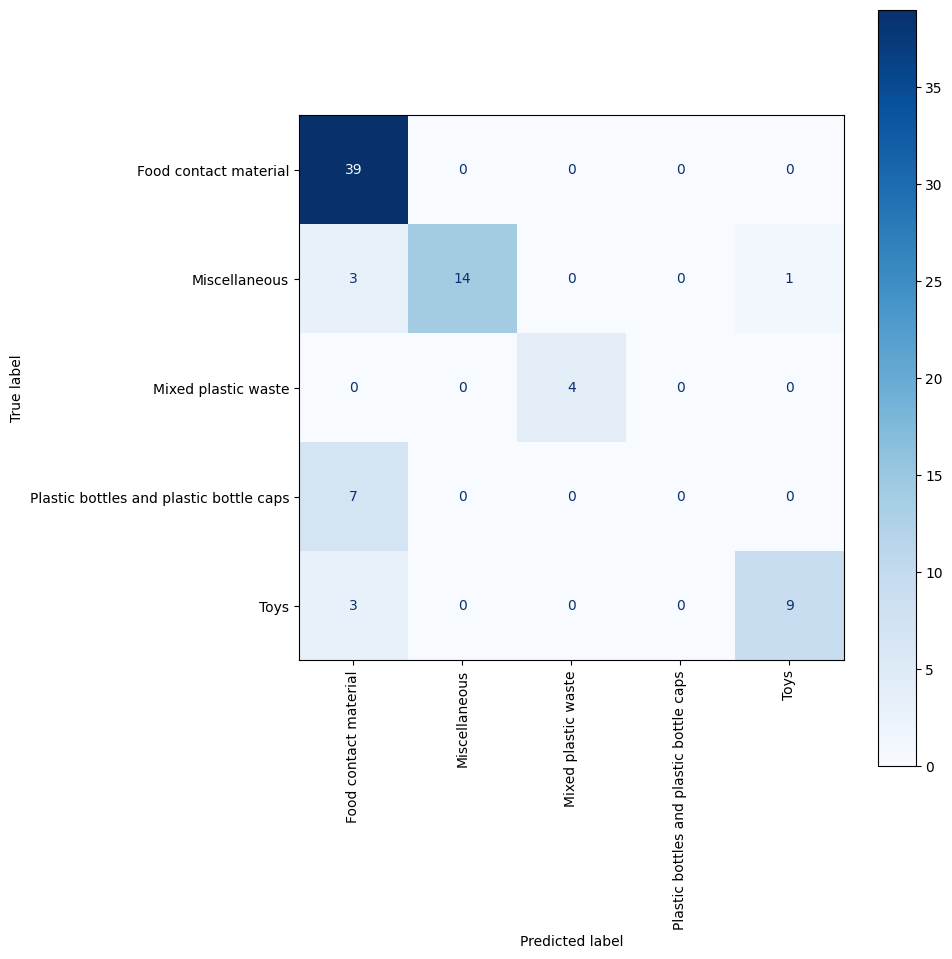

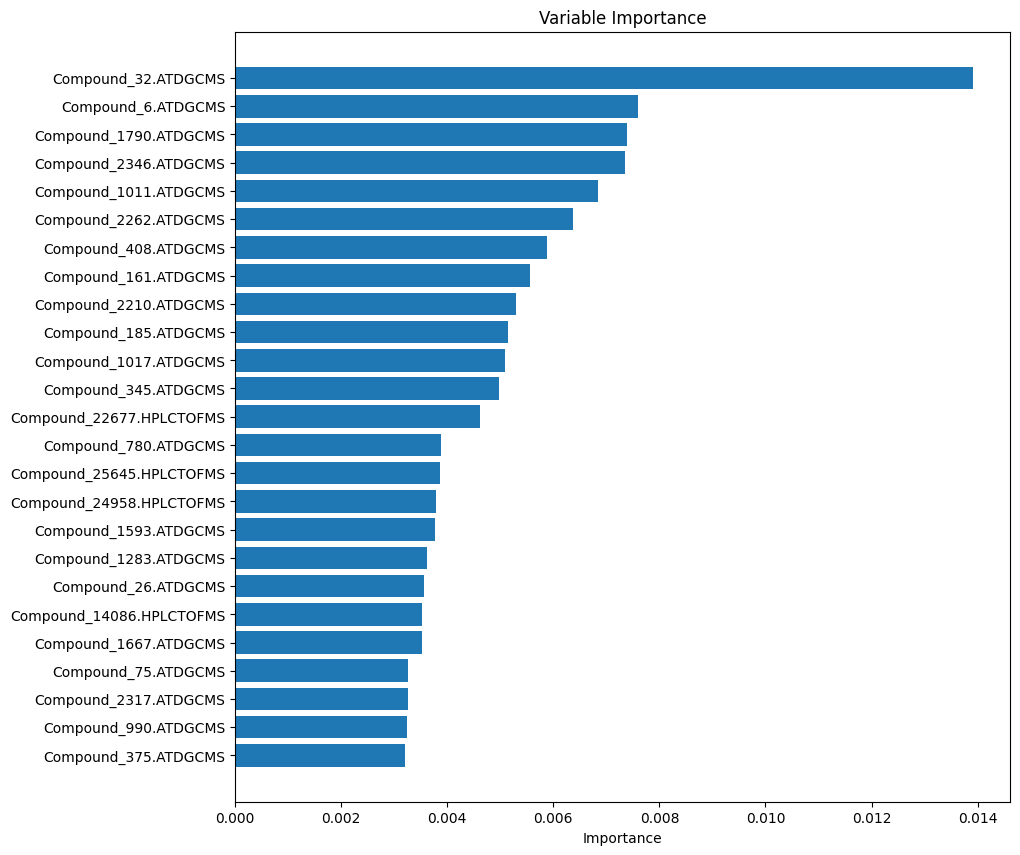

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\3074517068.py:16: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', type], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


In [ ]:
for i in range(4):
    clf = rfsrc_result(gc_hplc_list,
                                    # sig_comp_list = significant_comp,
                       type = 'Category',
                        list_ele=i,
                        split_train = 0.5)

##### GC + HPLC + ICP data

In [ ]:
for i in range(4):
    clf = rfsrc_result(gc_hplc_icp_list,
                                    # sig_comp_list = significant_comp,
                       type = 'Category',
                        list_ele=i,
                        split_train = 0.5)

##### ICP data

In [ ]:
for i in range(4):
    clf = rfsrc_result(icp_list,
                                    # sig_comp_list = significant_comp,
                       type = 'Category',
                        list_ele=i,
                        split_train = 0.5)

#### Classification By Subcategory

##### GC + HPLC data

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.8276430976430976
                         precision    recall  f1-score   support

               Balloons       0.88      1.00      0.93         7
            Bottle caps       1.00      0.80      0.89         5
         Cigarillo tips       0.83      1.00      0.91         5
      Fabric face masks       1.00      0.80      0.89         5
     Fishing bait trays       0.50      0.60      0.55         5
        Food containers       0.50      0.60      0.55         5
         Food packaging       1.00      1.00      1.00         4
          Food wrappers       1.00      0.75      0.86         4
      Plastic Toy balls       1.00      0.60      0.75         5
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.67      0.91      0.77        11
Plastic drinking straws       1.00      0.56      0.71         9
 Polystyrene food waste       0.67      1.00      0.80         4
  Various plastic waste       1.00  

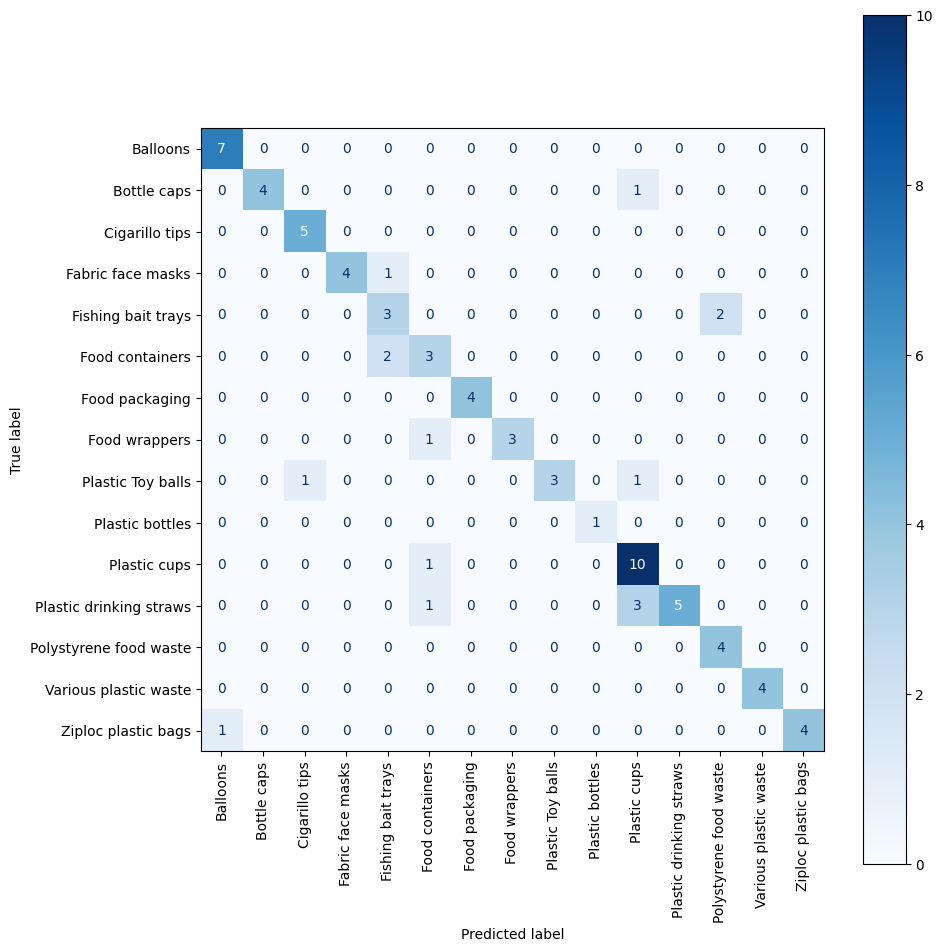

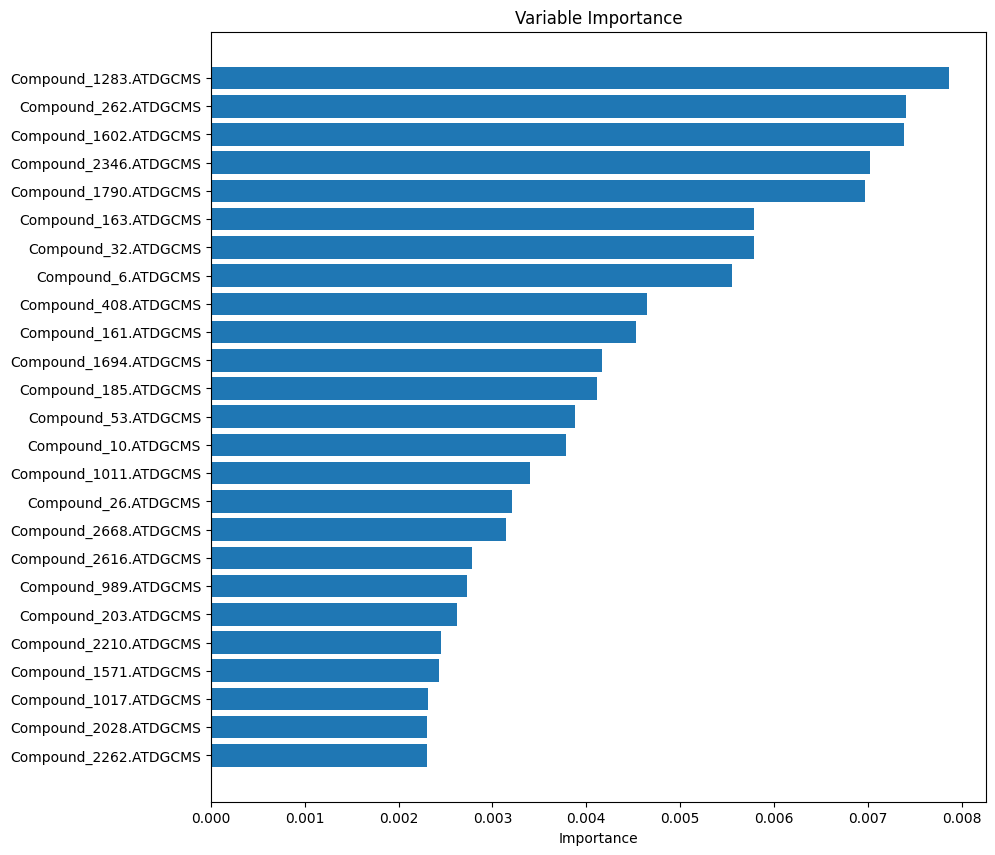

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.8276430976430976
                         precision    recall  f1-score   support

               Balloons       0.88      1.00      0.93         7
            Bottle caps       1.00      0.80      0.89         5
         Cigarillo tips       0.83      1.00      0.91         5
      Fabric face masks       1.00      0.80      0.89         5
     Fishing bait trays       0.50      0.60      0.55         5
        Food containers       0.50      0.60      0.55         5
         Food packaging       1.00      1.00      1.00         4
          Food wrappers       1.00      0.75      0.86         4
      Plastic Toy balls       1.00      0.60      0.75         5
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.67      0.91      0.77        11
Plastic drinking straws       1.00      0.56      0.71         9
 Polystyrene food waste       0.67      1.00      0.80         4
  Various plastic waste       1.00  

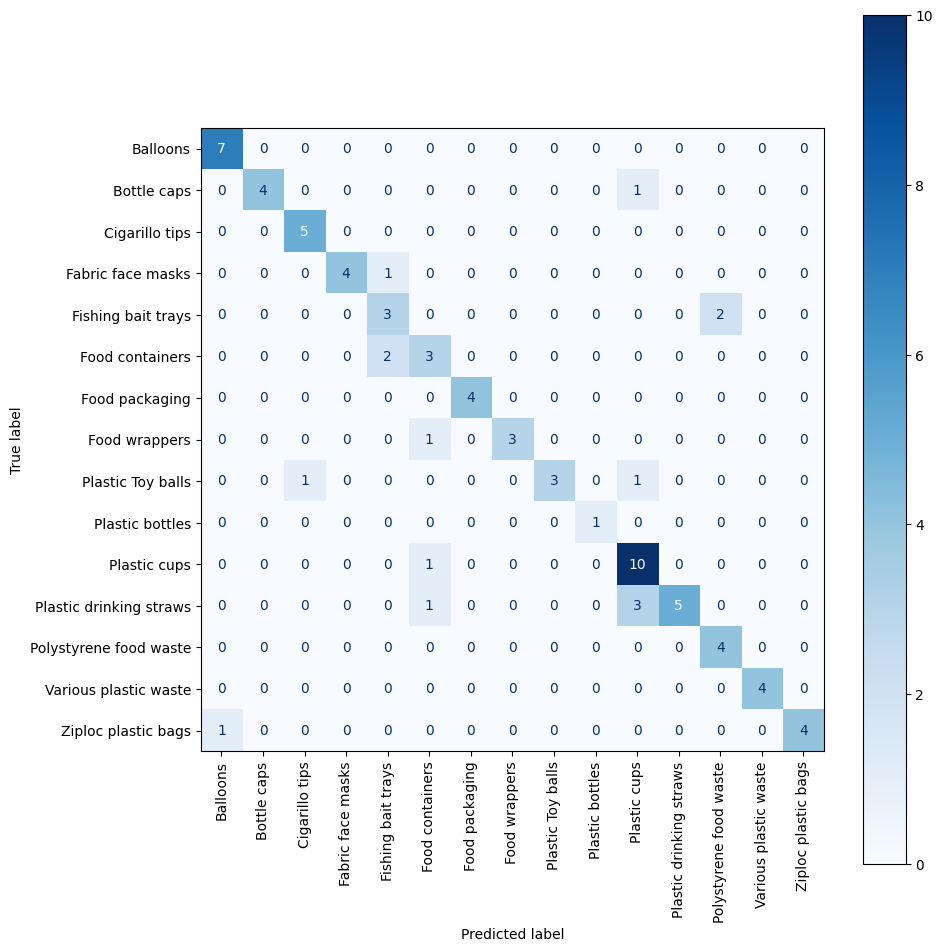

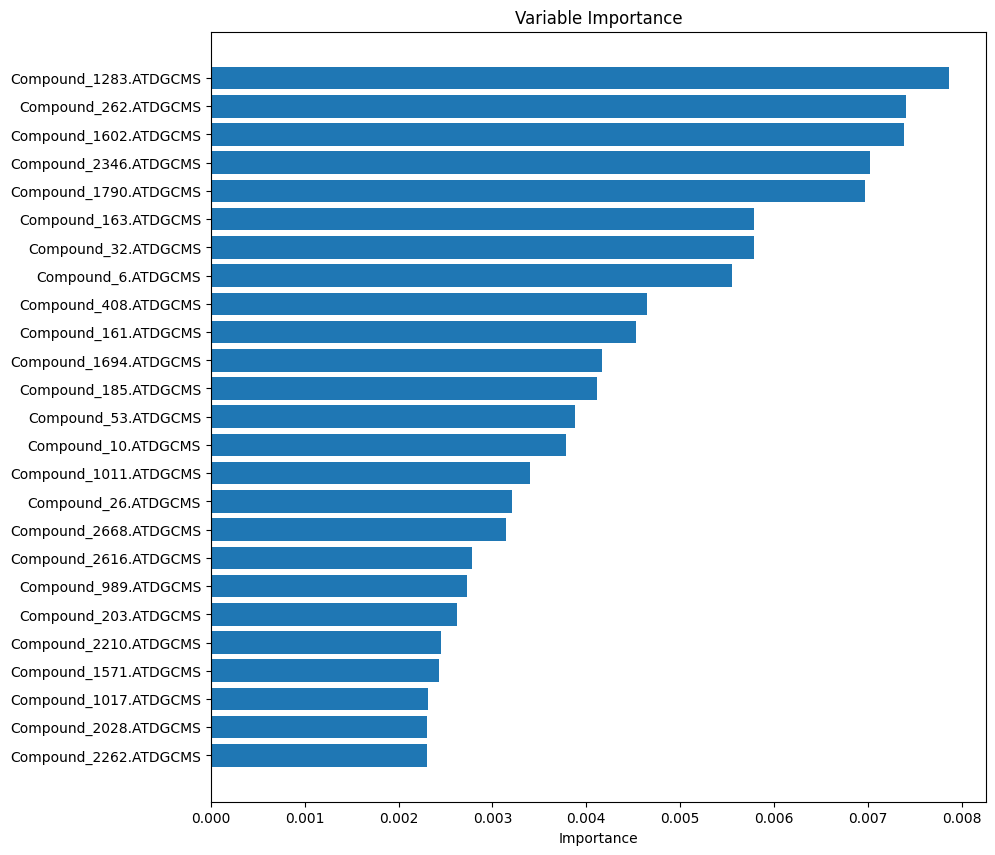

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.8276430976430976
                         precision    recall  f1-score   support

               Balloons       0.88      1.00      0.93         7
            Bottle caps       1.00      0.80      0.89         5
         Cigarillo tips       0.83      1.00      0.91         5
      Fabric face masks       1.00      0.80      0.89         5
     Fishing bait trays       0.50      0.60      0.55         5
        Food containers       0.50      0.60      0.55         5
         Food packaging       1.00      1.00      1.00         4
          Food wrappers       1.00      0.75      0.86         4
      Plastic Toy balls       1.00      0.60      0.75         5
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.67      0.91      0.77        11
Plastic drinking straws       1.00      0.56      0.71         9
 Polystyrene food waste       0.67      1.00      0.80         4
  Various plastic waste       1.00  

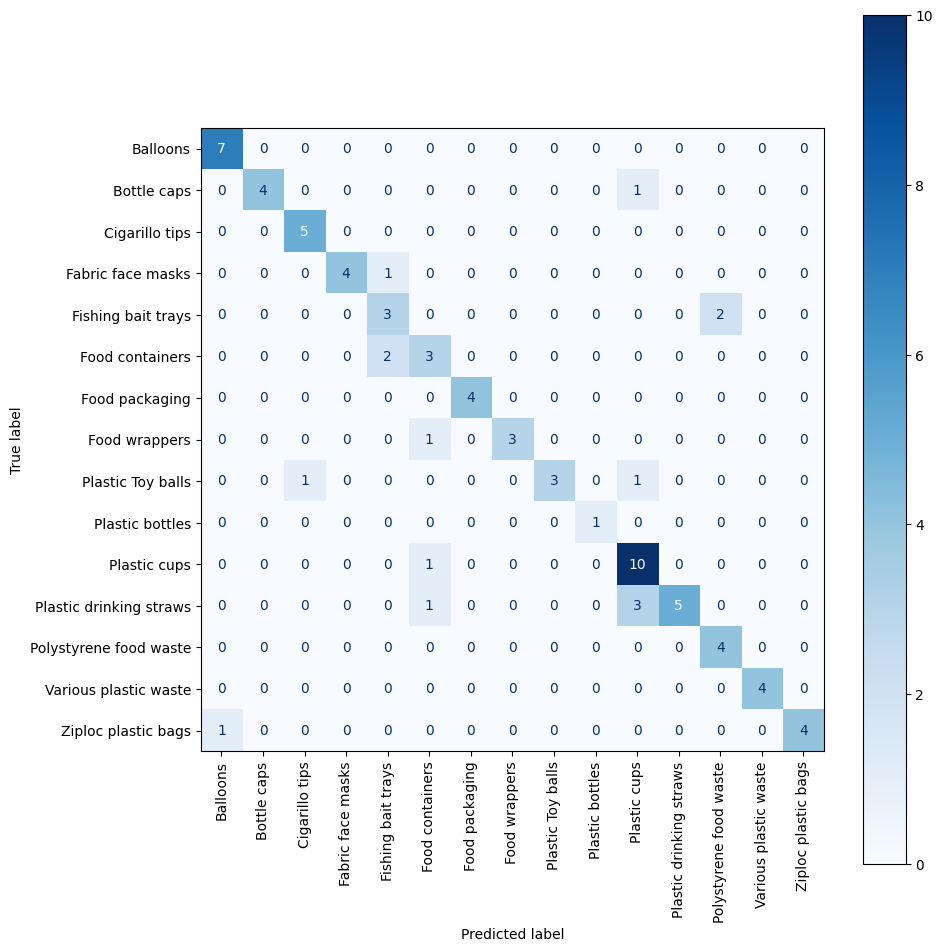

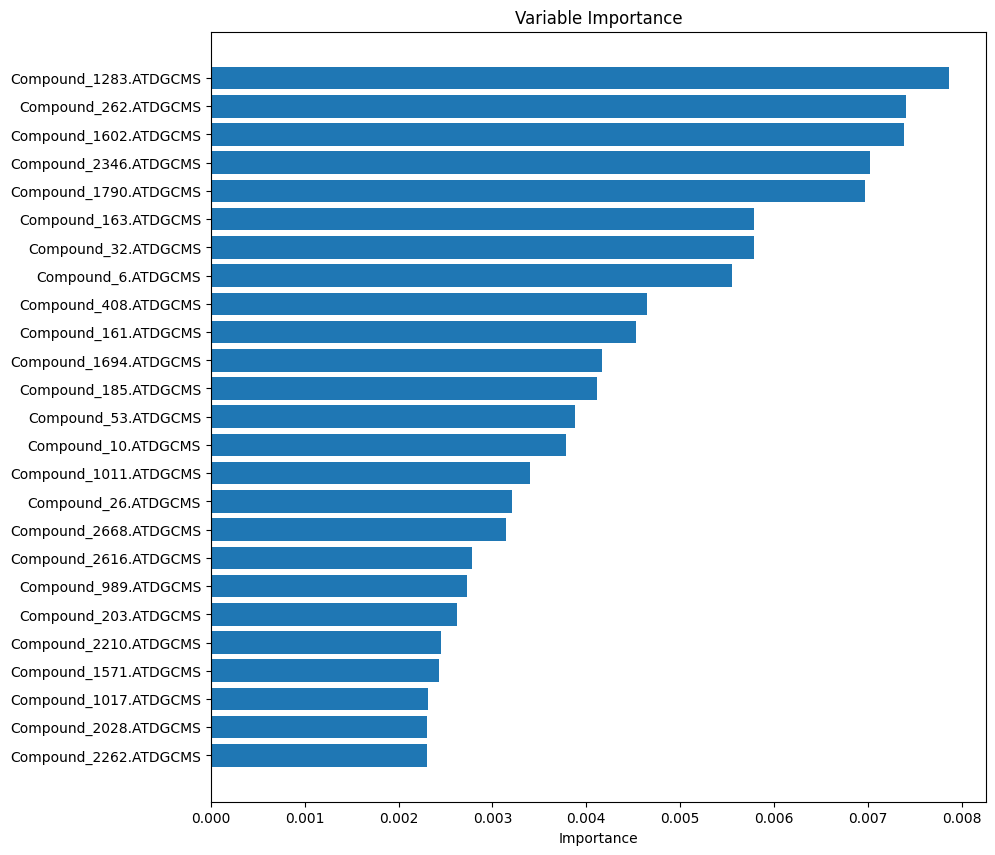

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.8276430976430976
                         precision    recall  f1-score   support

               Balloons       0.88      1.00      0.93         7
            Bottle caps       1.00      0.80      0.89         5
         Cigarillo tips       0.83      1.00      0.91         5
      Fabric face masks       1.00      0.80      0.89         5
     Fishing bait trays       0.50      0.60      0.55         5
        Food containers       0.50      0.60      0.55         5
         Food packaging       1.00      1.00      1.00         4
          Food wrappers       1.00      0.75      0.86         4
      Plastic Toy balls       1.00      0.60      0.75         5
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.67      0.91      0.77        11
Plastic drinking straws       1.00      0.56      0.71         9
 Polystyrene food waste       0.67      1.00      0.80         4
  Various plastic waste       1.00  

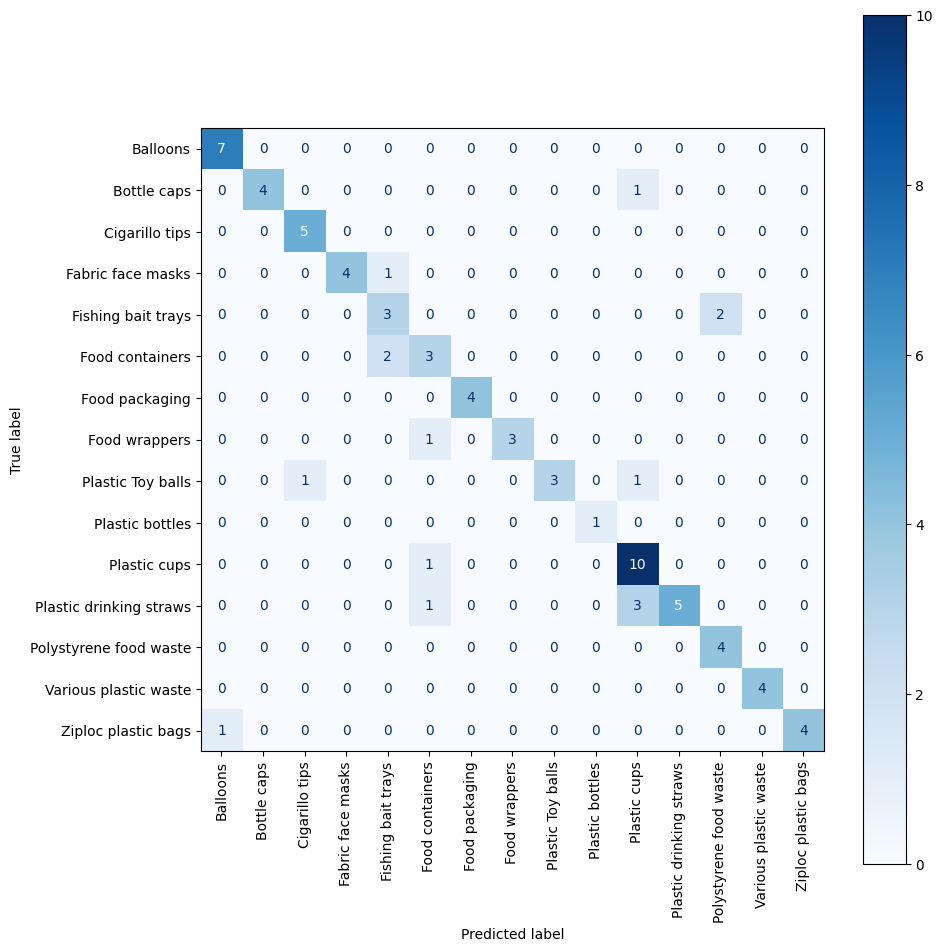

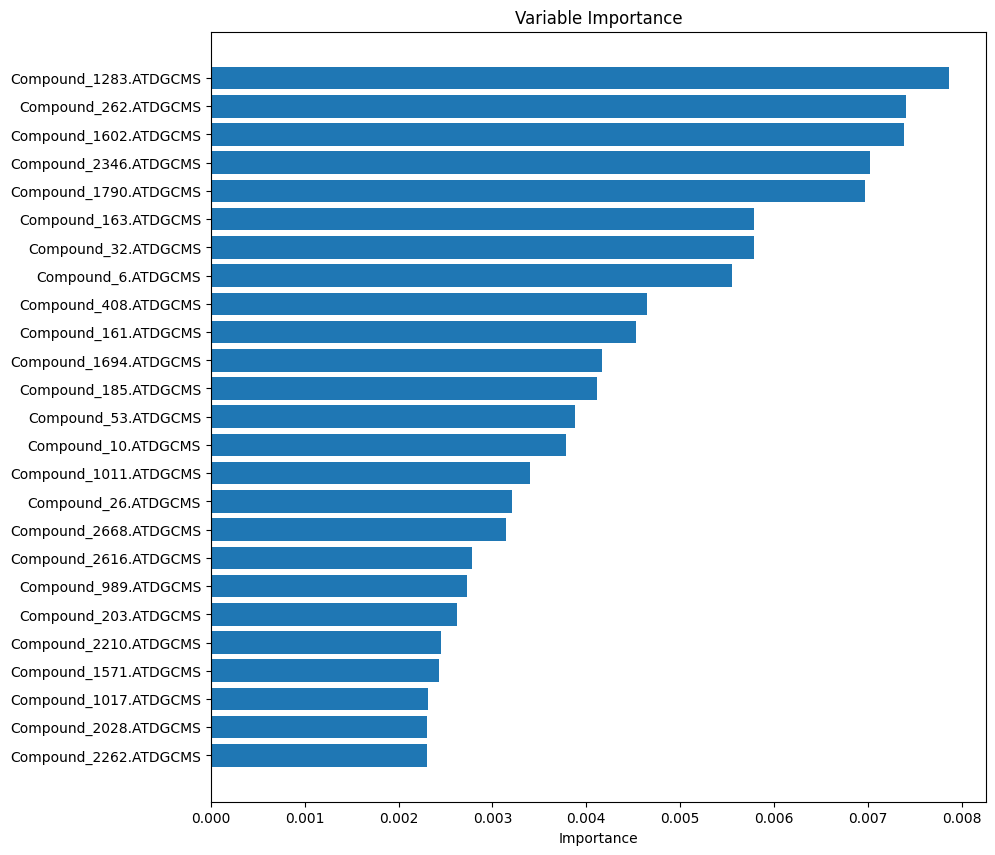

In [ ]:
clf = rfsrc_result(gc_hplc_list,
                                # sig_comp_list = significant_comp,
                   type = 'Subcategory',
                    list_ele=i,
                    split_train = 0.5)

##### GC + HPLC + ICP data

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.7945454545454547
                         precision    recall  f1-score   support

               Balloons       0.73      1.00      0.84         8
            Bottle caps       1.00      0.29      0.44         7
         Cigarillo tips       0.83      0.83      0.83         6
      Fabric face masks       0.86      1.00      0.92         6
     Fishing bait trays       0.67      0.67      0.67         6
        Food containers       1.00      0.71      0.83         7
         Food packaging       0.67      1.00      0.80         6
          Food wrappers       1.00      0.83      0.91         6
      Plastic Toy balls       1.00      0.83      0.91         6
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.64      0.82      0.72        11
Plastic drinking straws       0.75      0.60      0.67        10
 Polystyrene food waste       0.71      0.83      0.77         6
  Various plastic waste       0.62  

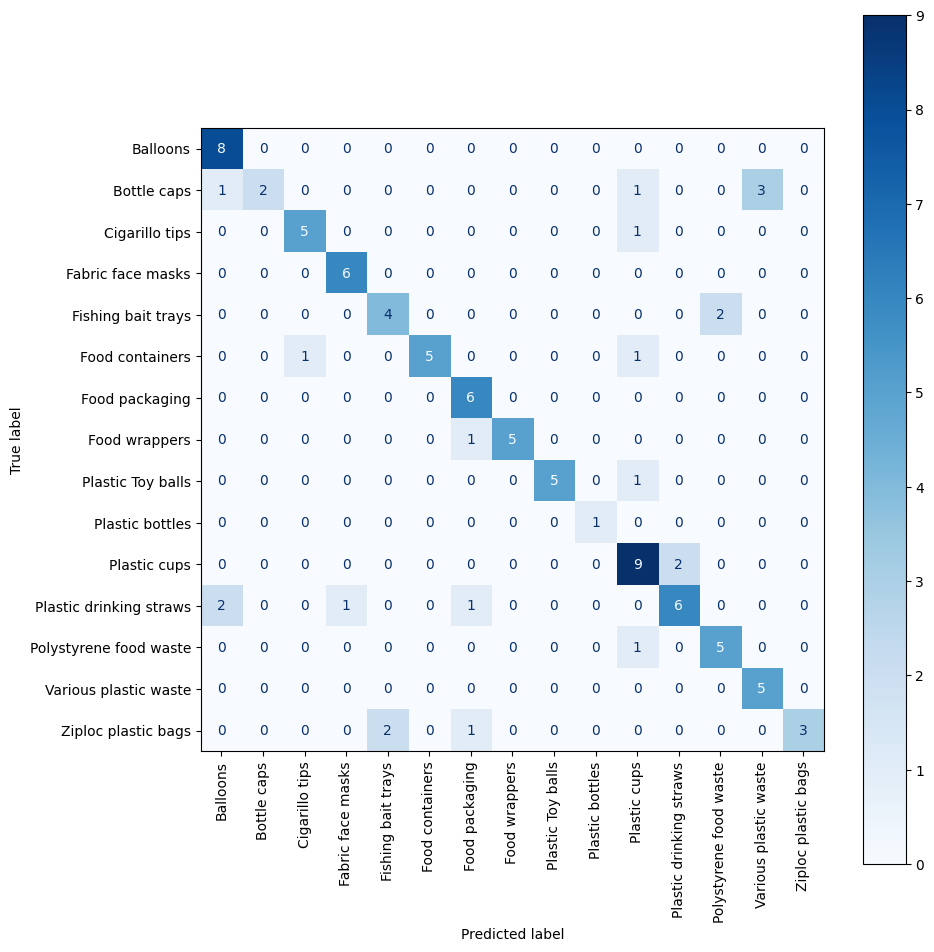

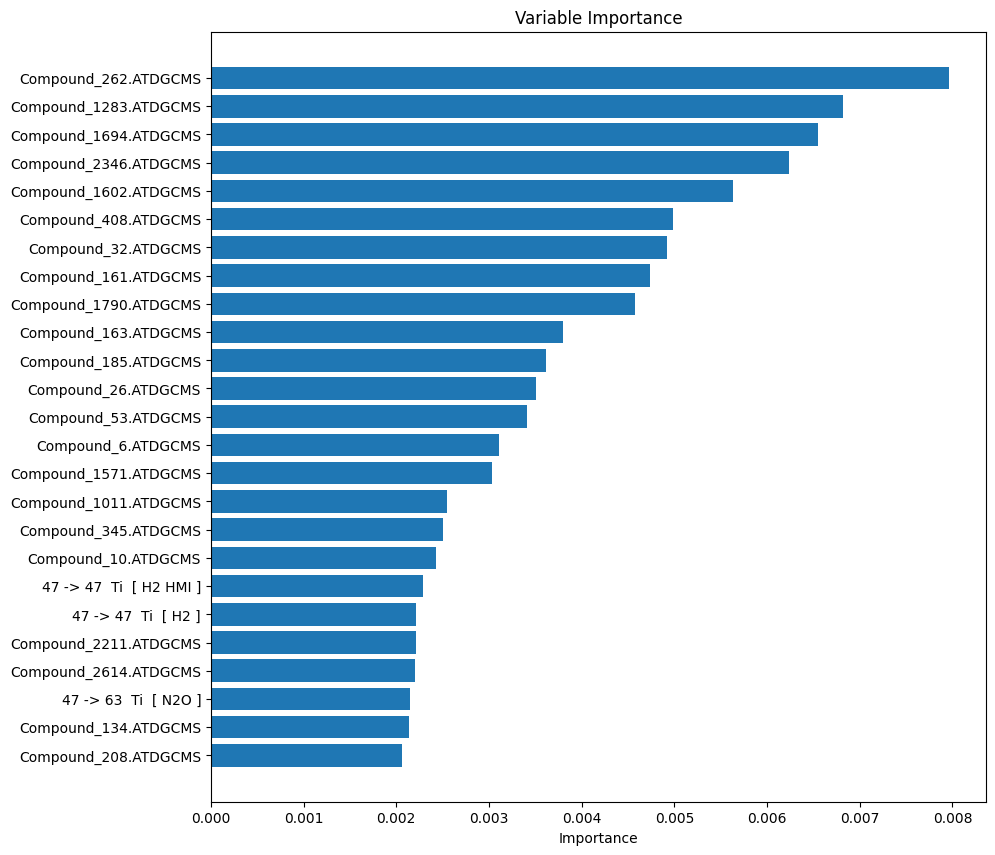

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Balanced Accuracy (testing) of RF:0.7945454545454547
                         precision    recall  f1-score   support

               Balloons       0.73      1.00      0.84         8
            Bottle caps       1.00      0.29      0.44         7
         Cigarillo tips       0.83      0.83      0.83         6
      Fabric face masks       0.86      1.00      0.92         6
     Fishing bait trays       0.67      0.67      0.67         6
        Food containers       1.00      0.71      0.83         7
         Food packaging       0.67      1.00      0.80         6
          Food wrappers       1.00      0.83      0.91         6
      Plastic Toy balls       1.00      0.83      0.91         6
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.64      0.82      0.72        11
Plastic drinking straws       0.75      0.60      0.67        10
 Polystyrene food waste       0.71      0.83      0.77         6
  Various plastic waste       0.62  

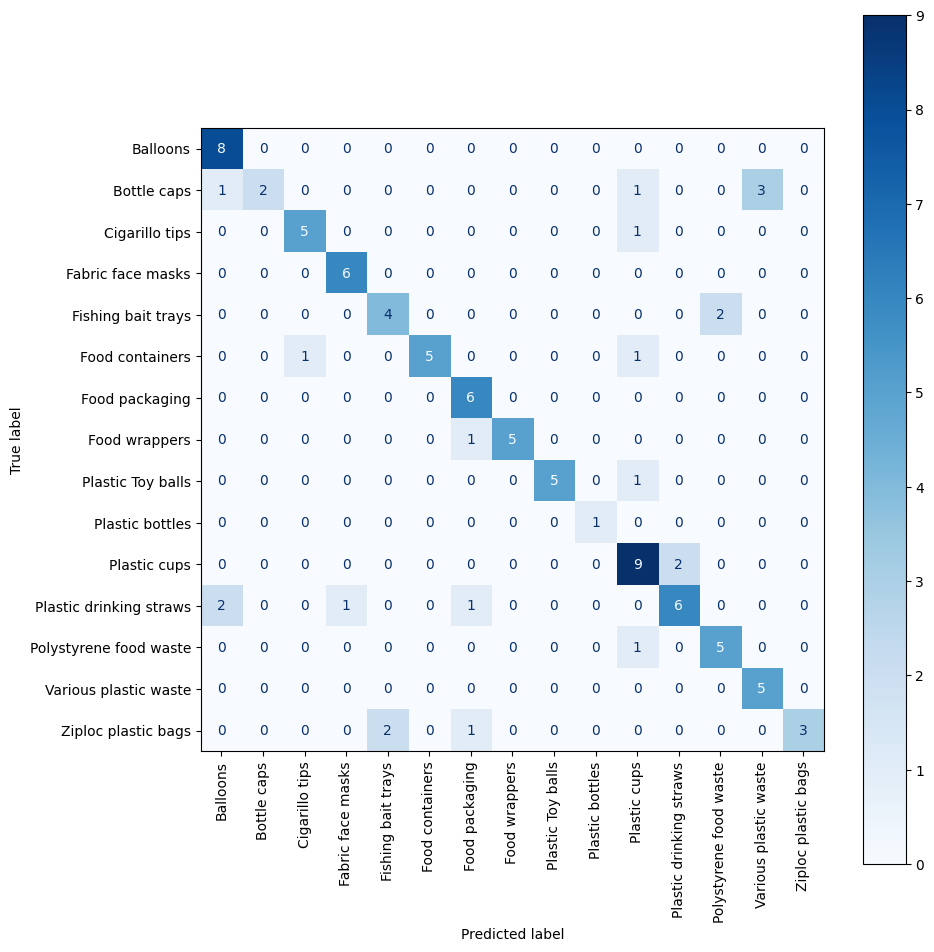

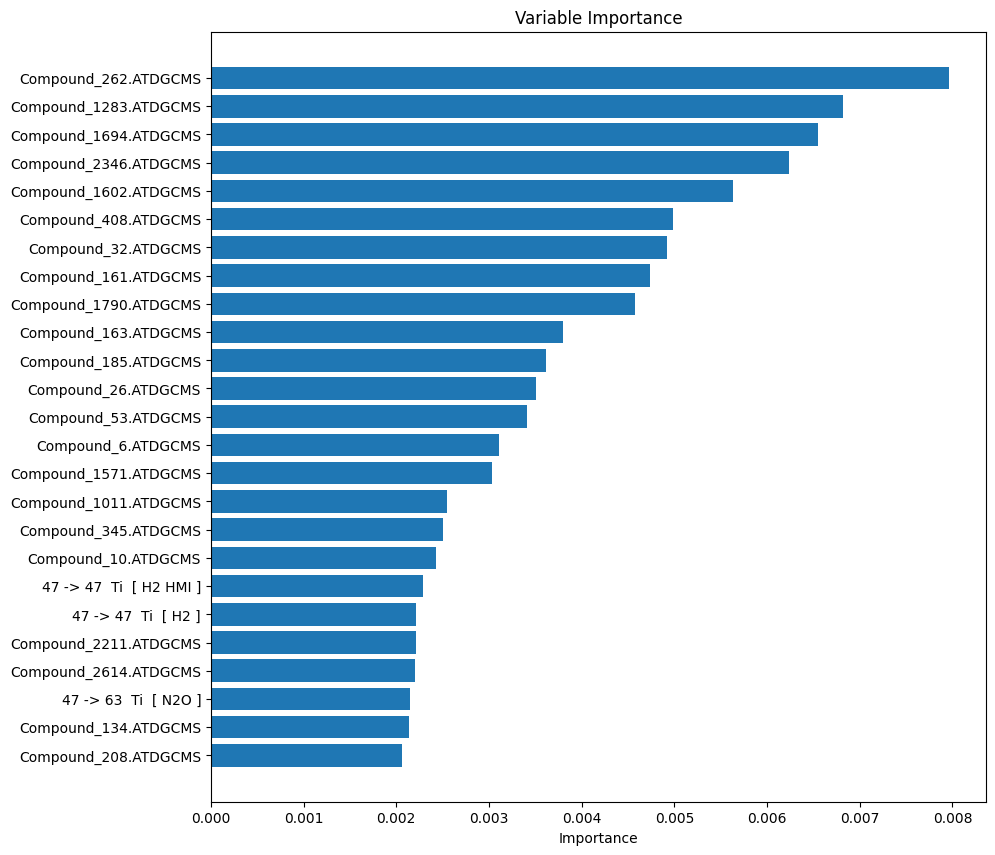

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.7945454545454547
                         precision    recall  f1-score   support

               Balloons       0.73      1.00      0.84         8
            Bottle caps       1.00      0.29      0.44         7
         Cigarillo tips       0.83      0.83      0.83         6
      Fabric face masks       0.86      1.00      0.92         6
     Fishing bait trays       0.67      0.67      0.67         6
        Food containers       1.00      0.71      0.83         7
         Food packaging       0.67      1.00      0.80         6
          Food wrappers       1.00      0.83      0.91         6
      Plastic Toy balls       1.00      0.83      0.91         6
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.64      0.82      0.72        11
Plastic drinking straws       0.75      0.60      0.67        10
 Polystyrene food waste       0.71      0.83      0.77         6
  Various plastic waste       0.62  

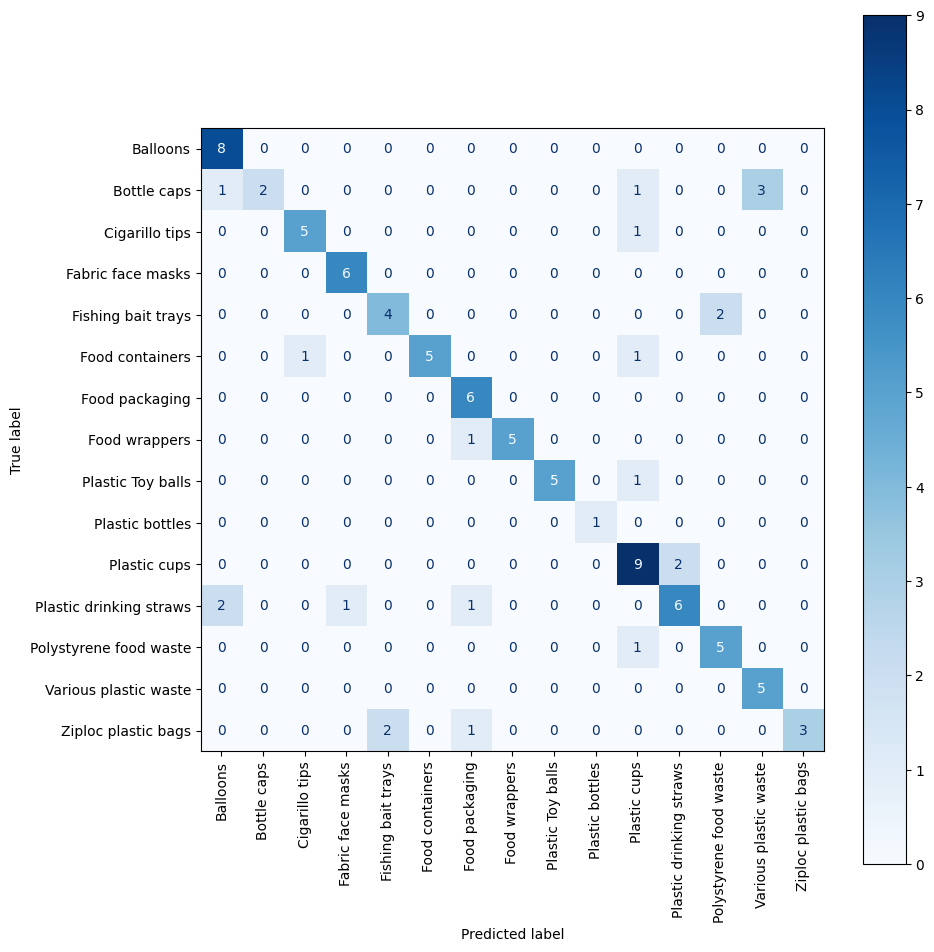

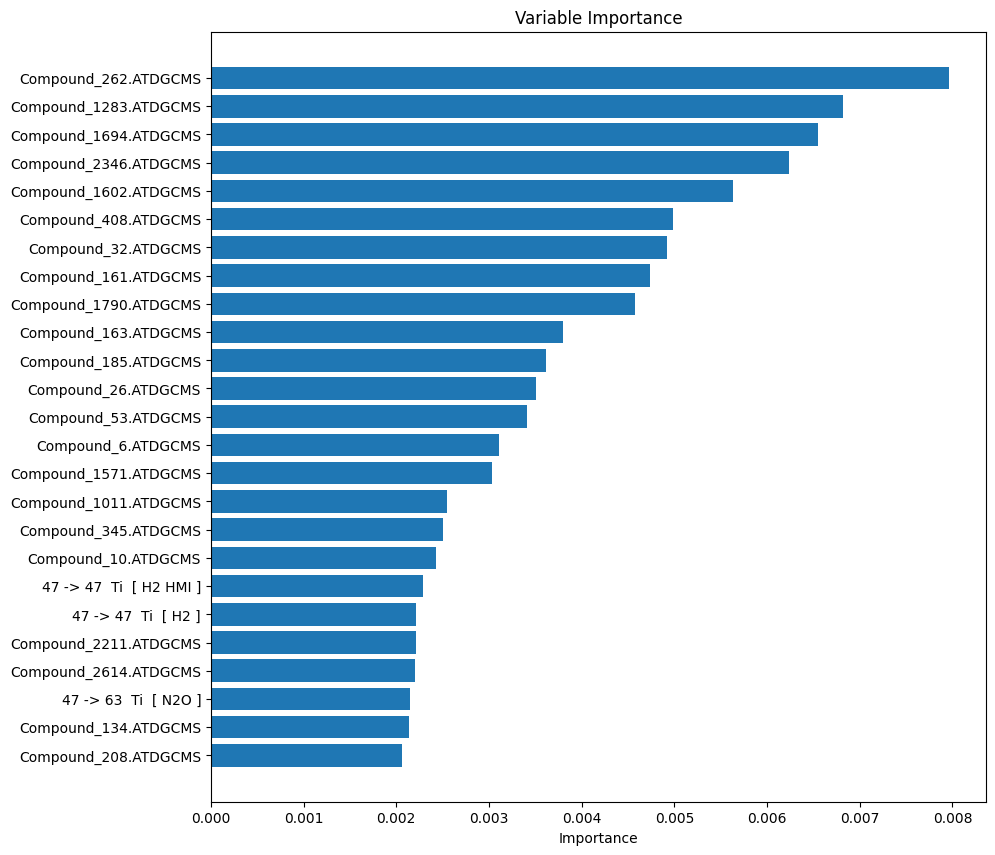

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\971992378.py:15: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index() #


Balanced Accuracy (testing) of RF:0.7945454545454547
                         precision    recall  f1-score   support

               Balloons       0.73      1.00      0.84         8
            Bottle caps       1.00      0.29      0.44         7
         Cigarillo tips       0.83      0.83      0.83         6
      Fabric face masks       0.86      1.00      0.92         6
     Fishing bait trays       0.67      0.67      0.67         6
        Food containers       1.00      0.71      0.83         7
         Food packaging       0.67      1.00      0.80         6
          Food wrappers       1.00      0.83      0.91         6
      Plastic Toy balls       1.00      0.83      0.91         6
        Plastic bottles       1.00      1.00      1.00         1
           Plastic cups       0.64      0.82      0.72        11
Plastic drinking straws       0.75      0.60      0.67        10
 Polystyrene food waste       0.71      0.83      0.77         6
  Various plastic waste       0.62  

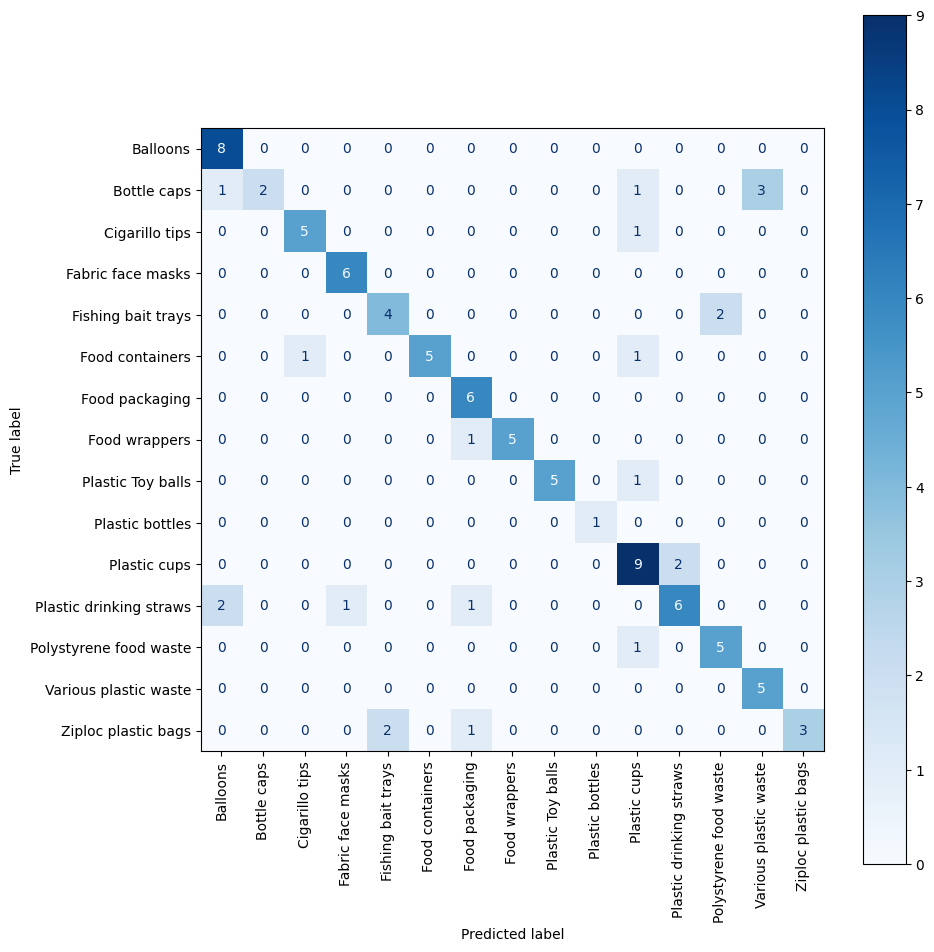

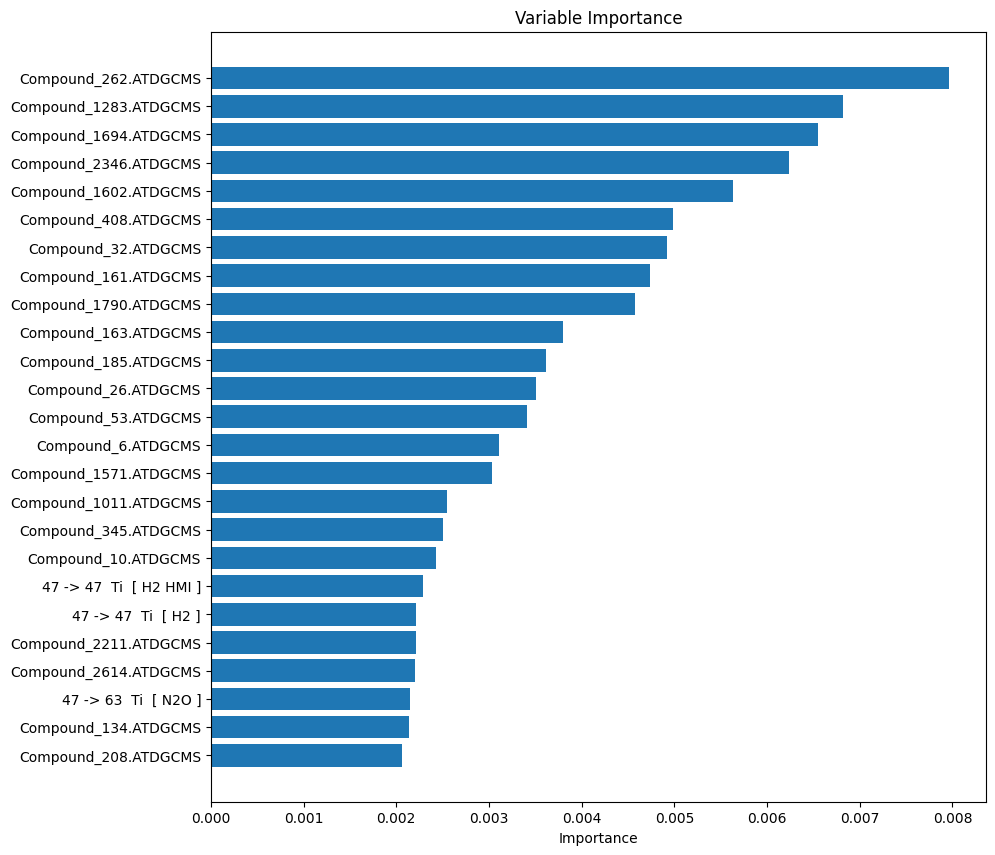

In [ ]:
clf = rfsrc_result(gc_hplc_icp_list,
                                    # sig_comp_list = significant_comp,
                   type = 'Subcategory',
                    list_ele=i,
                    split_train = 0.5)

### Gradient-Boosting Method <a class="anchor" id="gbm"></a>

In [ ]:
def gbm_result(dat_list,
               # sig_comp_list,
               list_ele, split_train):

    dat = dat_list[list_ele]
    # Select relevant columns
    dat = dat[['File', 'Subcategory', 'Feature', 'Values']]

    # Group by and take the mean of 'Values'
    dat = dat.groupby(['File', 'Subcategory', 'Feature']).agg({'Values': 'mean'}).reset_index()

    # Pivot the table
    dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

    # Set 'File' as index (equivalent to rownames in R)
    dat.set_index('File', inplace=True)

    # Keep only significant comp from Wilcoxon test
    # sig_comp = sig_comp_list[list_ele]['comp'].unique()
    # df = gc_hplc[np.append(sig_comp, 'Category')]

    # Iterate through each row and replace NaNs
    for idx, row in dat.iterrows():
        na_indices = row.isna()
        na_count = na_indices.sum()

        if na_count > 0:
            dat.loc[idx, na_indices.index[na_indices]] = 0

    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat['Subcategory'].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

    # Extract the features and labels
    X = dat.drop(columns=['Subcategory'])
    y = dat['Subcategory']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split_train, stratify = y,
                                                        random_state= 123 # random.randrange(999)
                                                       )

    param_grid = {
    'n_estimators':  [1, 10, 50, 100, 500, 1000, 5000, 10000], # Generate an array of 100 stepwise values from 0 to 1000,
    'max_features': ['sqrt', 'log2']
    }

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf)
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)['Subcategory'].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)['Subcategory'].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)

    grid = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=param_grid,
                            # number of cv = number of member of classes with least no. of members
                            cv = cv,
                            scoring = 'balanced_accuracy',
                            n_jobs = -1,
                            random_state= 123 # random.randrange(999)
                             ).fit(X_train, y_train).best_params_

    # Train the model
    gbm_model = GradientBoostingClassifier(n_estimators= grid['n_estimators'], max_features= grid['max_features'],
                                           random_state= 123, # random.randrange(999),
                                           max_depth = None, criterion= "friedman_mse")
    gbm_model.fit(X_train, y_train)

    # Prediction results
    # For test set
    predictions_test = gbm_model.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=gbm_model.classes_)
    pred_df_test['File'] = X_test.index.get_level_values('File').values

    # Assign true and predicted labels
    # For test set
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)

    # Balanced accuracy score
    print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_true_test, y_pred_test)))

    # Generate confusion matrix of test set
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=gbm_model.classes_)

    print(classification_report(y_true_test, y_pred_test))

    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=gbm_model.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Category Prediction probability of each sample
    # newdat = pd.melt(pred_df, id_vars=['File'], var_name='Category', value_name='prob')
    # sns.barplot(x='File', y='prob', hue='Category', data=newdat, palette="Set2")
    # plt.xticks(rotation=90)
    # plt.show()

    # Plot feature importance
    # feature importance scores will be in the range [0,1].
    # Higher scores mean the feature is more important. This is an array with shape (n_features,) whose values are positive and sum to 1.0
    feat_imp = pd.DataFrame({'feature_score': gbm_model.feature_importances_,
                             'feature_name': dat.drop(columns=['Subcategory']).columns}).sort_values('feature_score')

    # Plot the top 25 most important features
    plt.barh(range(25), feat_imp.tail(n = 25).feature_score)
    plt.yticks(range(25), feat_imp.tail(n = 25).feature_name)
    plt.xlabel('Importance')
    plt.title('Variable Importance')
    plt.show()

    return gbm_model

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.9166666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00         1
         Cigarillo tips       1.00      1.00      1.00         2
      Fabric face masks       1.00      1.00      1.00         2
     Fishing bait trays       1.00      1.00      1.00         2
        Food containers       1.00      1.00      1.00         1
         Food packaging       1.00      1.00      1.00         2
          Food wrappers       1.00      1.00      1.00         2
      Plastic Toy balls       1.00      1.00      1.00         2
Plastic drinking straws       1.00      1.00      1.00         1
 Polystyrene food waste       1.00      1.00      1.00         2
  Various plastic waste       0.67      1.00      0.80         2
    Ziploc plastic bags       1.00      1.00      1.00         2

               accuracy                           0.95        21
              macro avg       0.89      0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

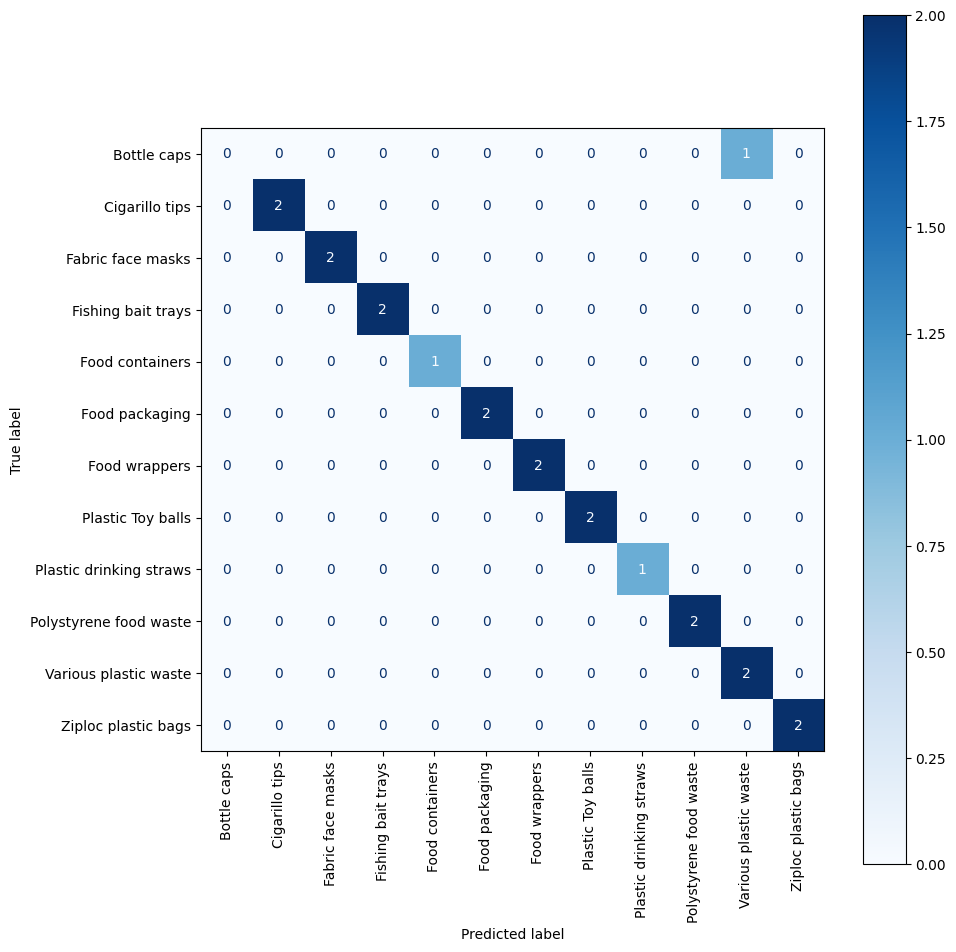

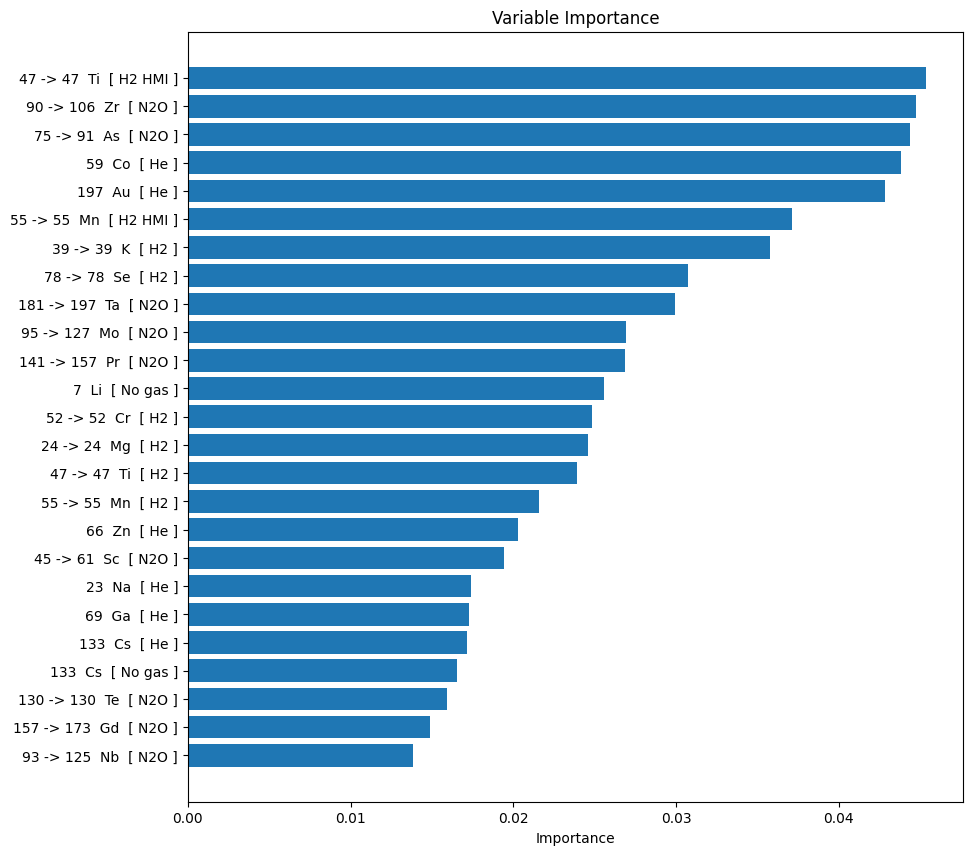

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.9166666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00         1
         Cigarillo tips       1.00      1.00      1.00         2
      Fabric face masks       1.00      1.00      1.00         2
     Fishing bait trays       1.00      1.00      1.00         2
        Food containers       1.00      1.00      1.00         1
         Food packaging       1.00      1.00      1.00         2
          Food wrappers       1.00      1.00      1.00         2
      Plastic Toy balls       1.00      1.00      1.00         2
Plastic drinking straws       1.00      1.00      1.00         1
 Polystyrene food waste       1.00      1.00      1.00         2
  Various plastic waste       0.67      1.00      0.80         2
    Ziploc plastic bags       1.00      1.00      1.00         2

               accuracy                           0.95        21
              macro avg       0.89      0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

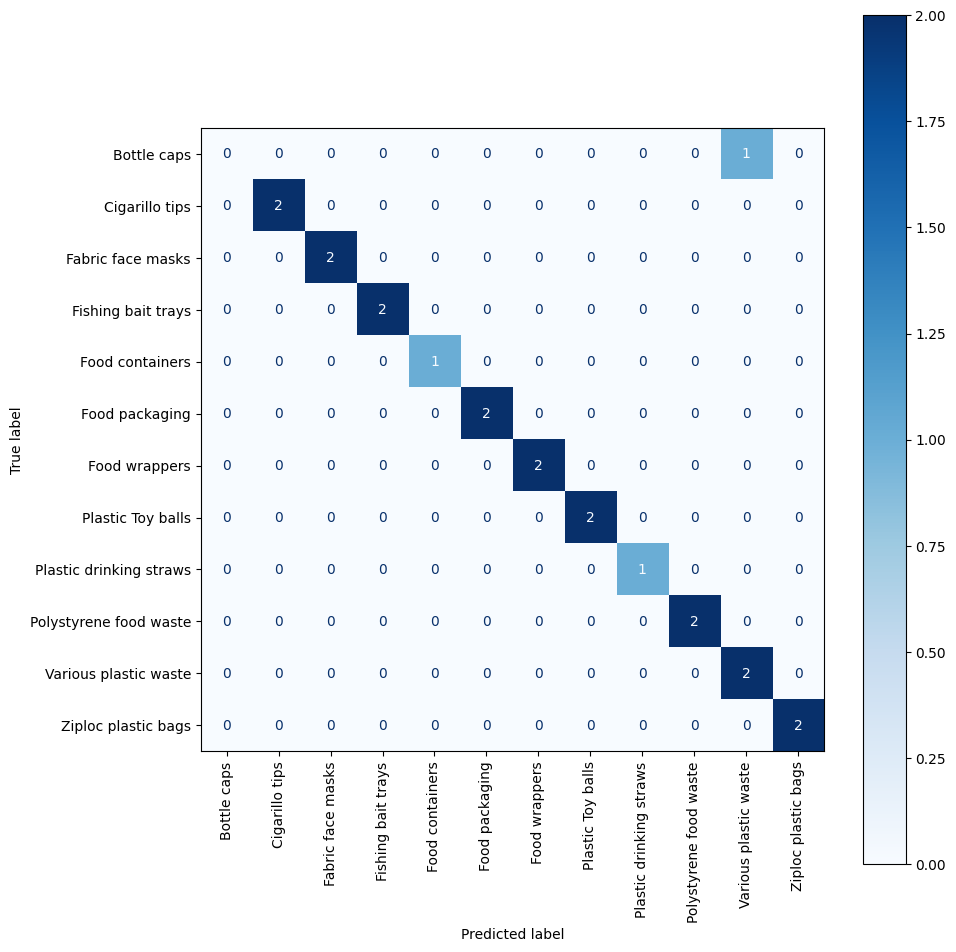

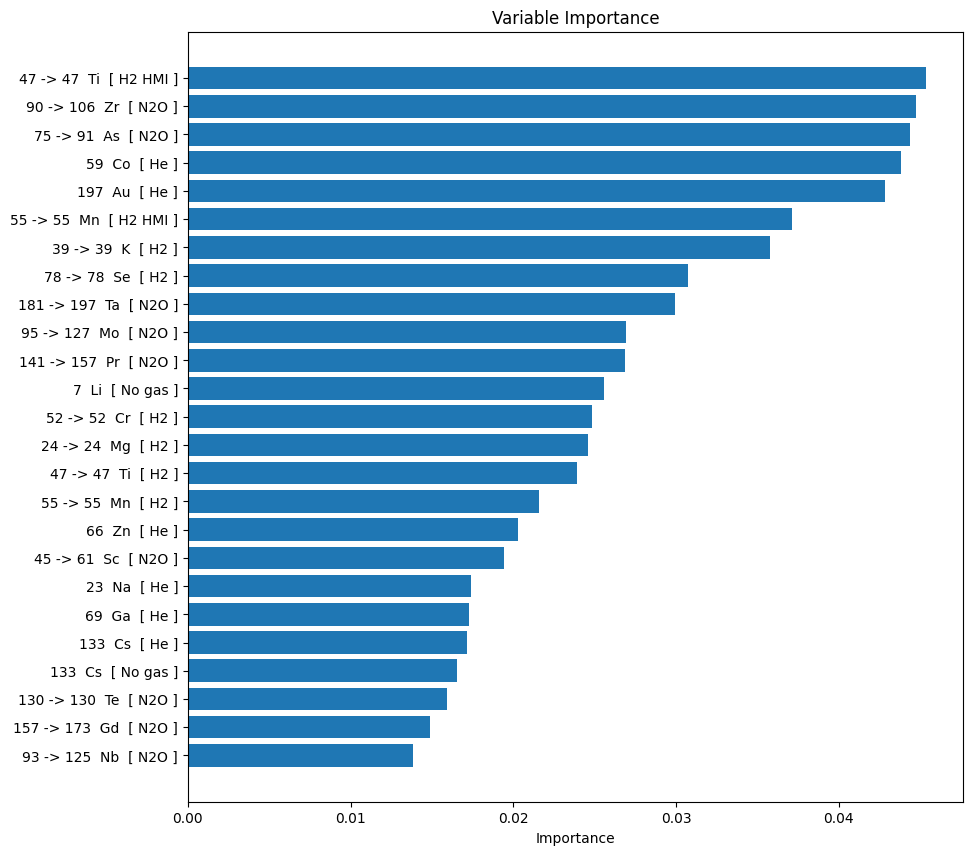

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.9166666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00         1
         Cigarillo tips       1.00      1.00      1.00         2
      Fabric face masks       1.00      1.00      1.00         2
     Fishing bait trays       1.00      1.00      1.00         2
        Food containers       1.00      1.00      1.00         1
         Food packaging       1.00      1.00      1.00         2
          Food wrappers       1.00      1.00      1.00         2
      Plastic Toy balls       1.00      1.00      1.00         2
Plastic drinking straws       1.00      1.00      1.00         1
 Polystyrene food waste       1.00      1.00      1.00         2
  Various plastic waste       0.67      1.00      0.80         2
    Ziploc plastic bags       1.00      1.00      1.00         2

               accuracy                           0.95        21
              macro avg       0.89      0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

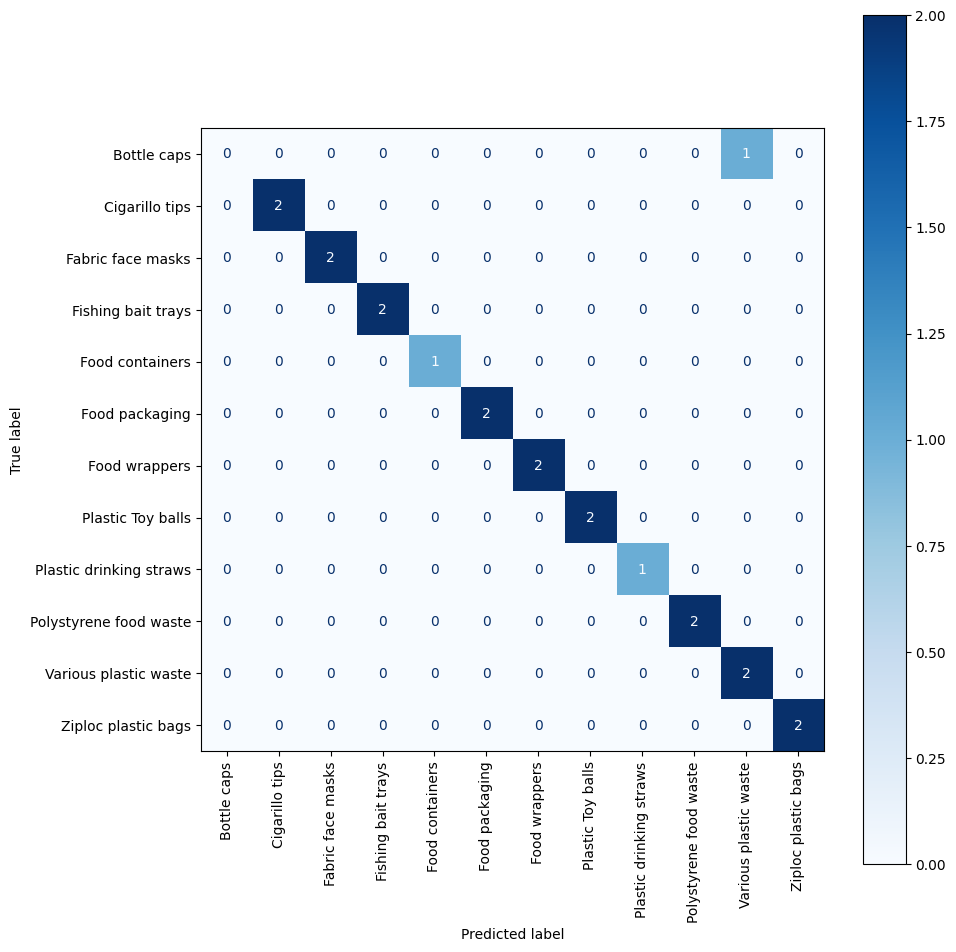

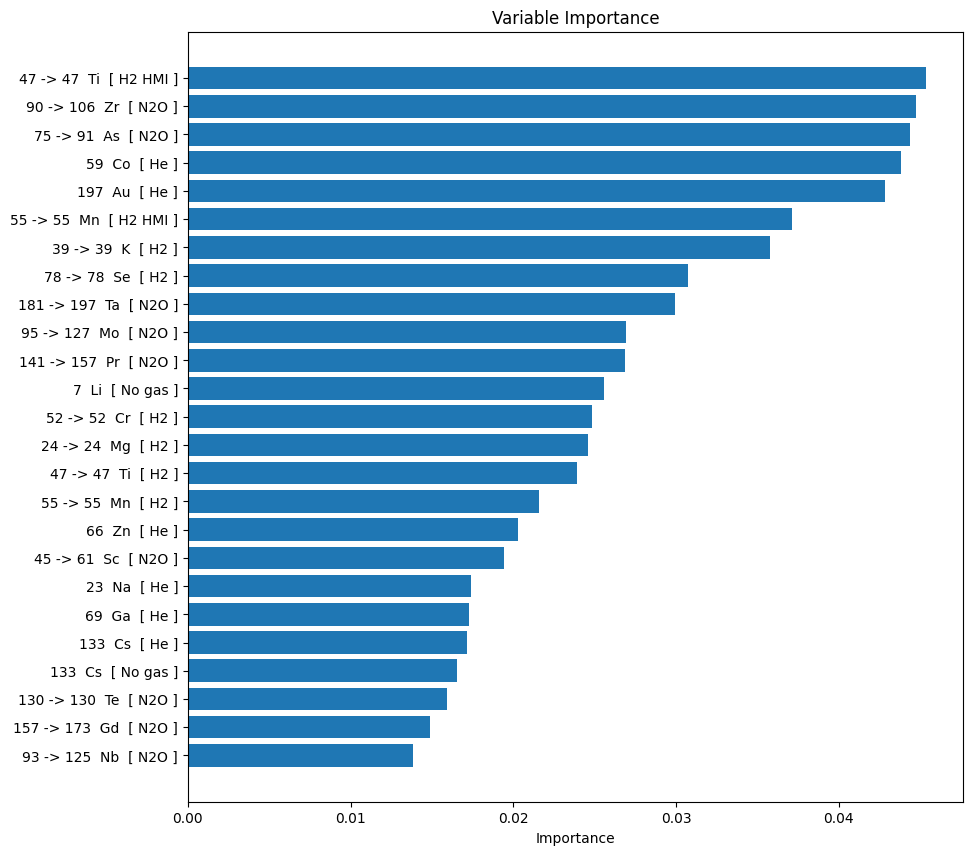

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.875
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00         1
         Cigarillo tips       1.00      1.00      1.00         2
      Fabric face masks       1.00      1.00      1.00         2
     Fishing bait trays       1.00      1.00      1.00         2
        Food containers       1.00      1.00      1.00         1
         Food packaging       1.00      0.50      0.67         2
          Food wrappers       1.00      1.00      1.00         2
      Plastic Toy balls       1.00      1.00      1.00         2
Plastic drinking straws       1.00      1.00      1.00         1
 Polystyrene food waste       1.00      1.00      1.00         2
  Various plastic waste       0.67      1.00      0.80         2
    Ziploc plastic bags       1.00      1.00      1.00         2

               accuracy                           0.90        21
              macro avg       0.89      0.88      0.87

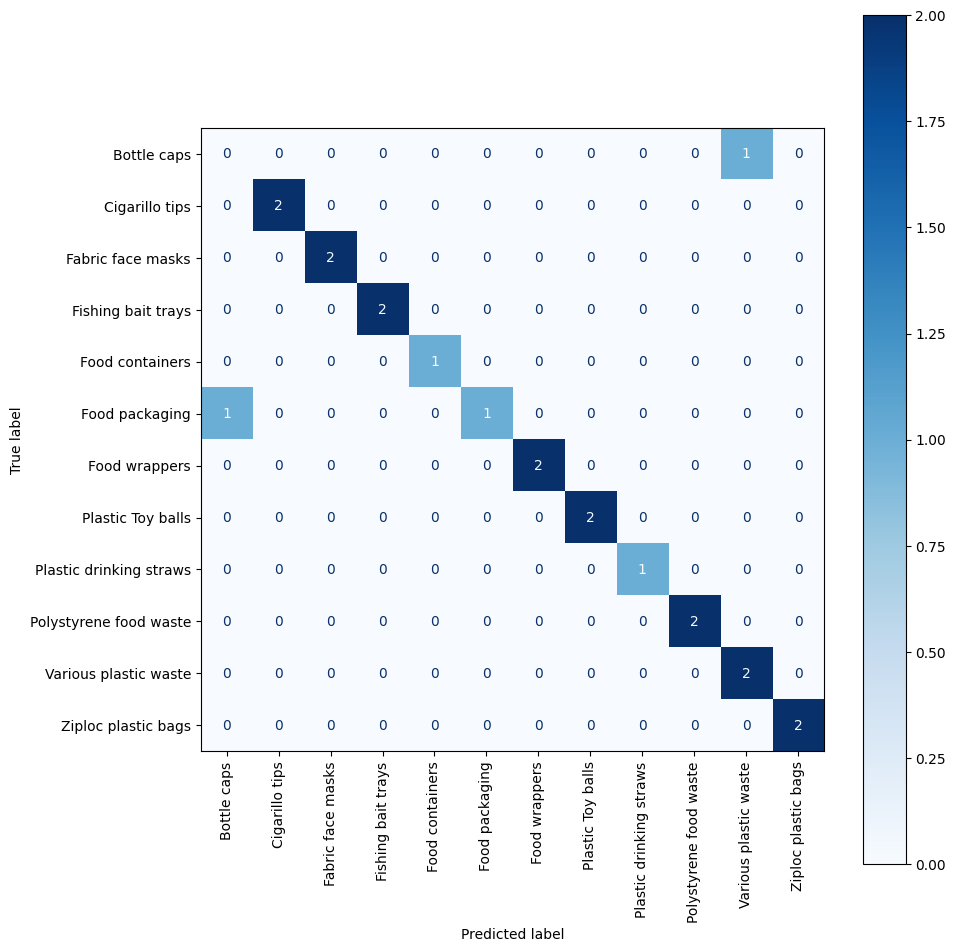

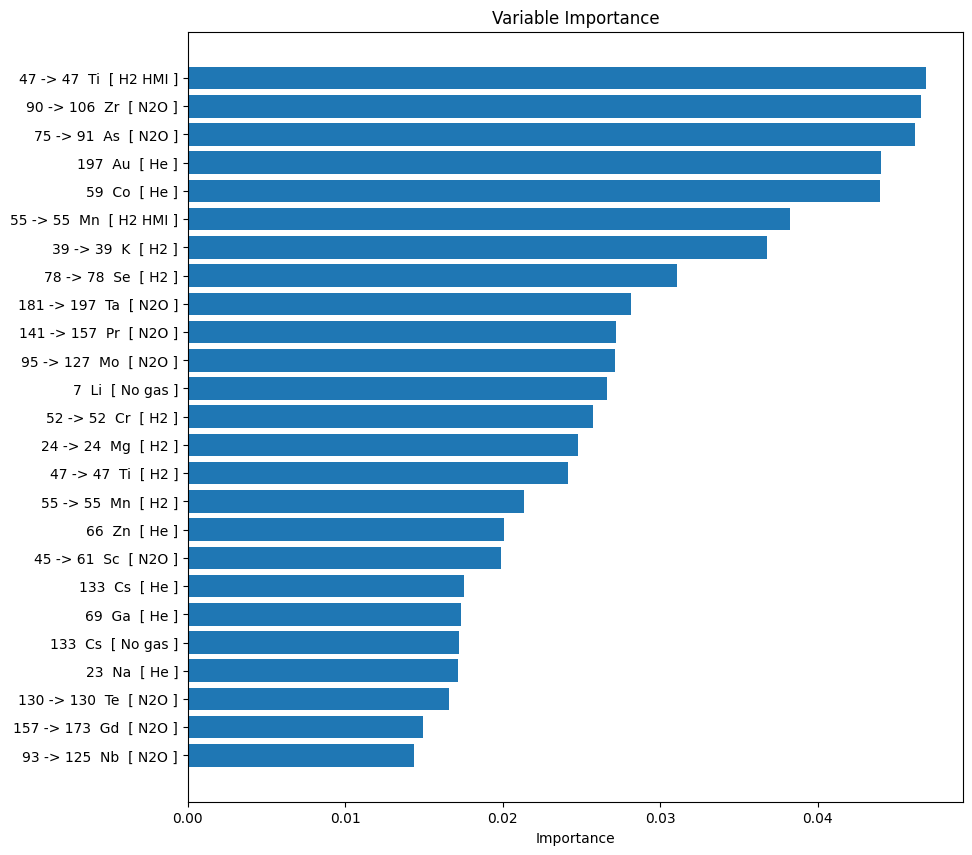

In [ ]:
for i in range(4):
    gbm = gbm_result(icp_list,
                           # sig_comp_list = significant_comp,
                           list_ele=i, split_train = 0.6)

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.6713573463573463
                         precision    recall  f1-score   support

               Balloons       0.73      0.89      0.80         9
            Bottle caps       1.00      0.56      0.71         9
         Cigarillo tips       0.67      0.57      0.62         7
      Fabric face masks       0.50      0.29      0.36         7
     Fishing bait trays       1.00      0.29      0.44         7
        Food containers       0.71      0.62      0.67         8
         Food packaging       1.00      0.57      0.73         7
          Food wrappers       1.00      0.86      0.92         7
      Plastic Toy balls       0.75      0.86      0.80         7
        Plastic bottles       1.00      1.00      1.00         2
           Plastic cups       0.61      0.85      0.71        13
Plastic drinking straws       0.58      0.58      0.58        12
 Polystyrene food waste       0.33      0.86      0.48         7
  Various plastic waste       0.86      0.

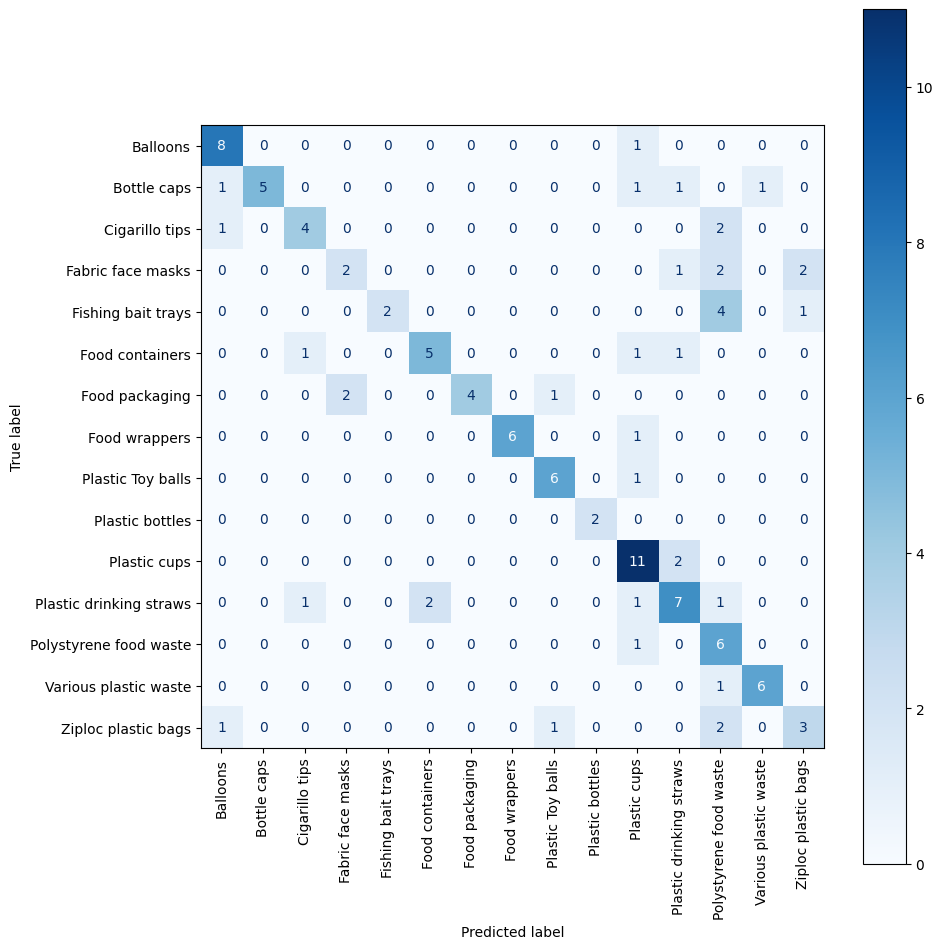

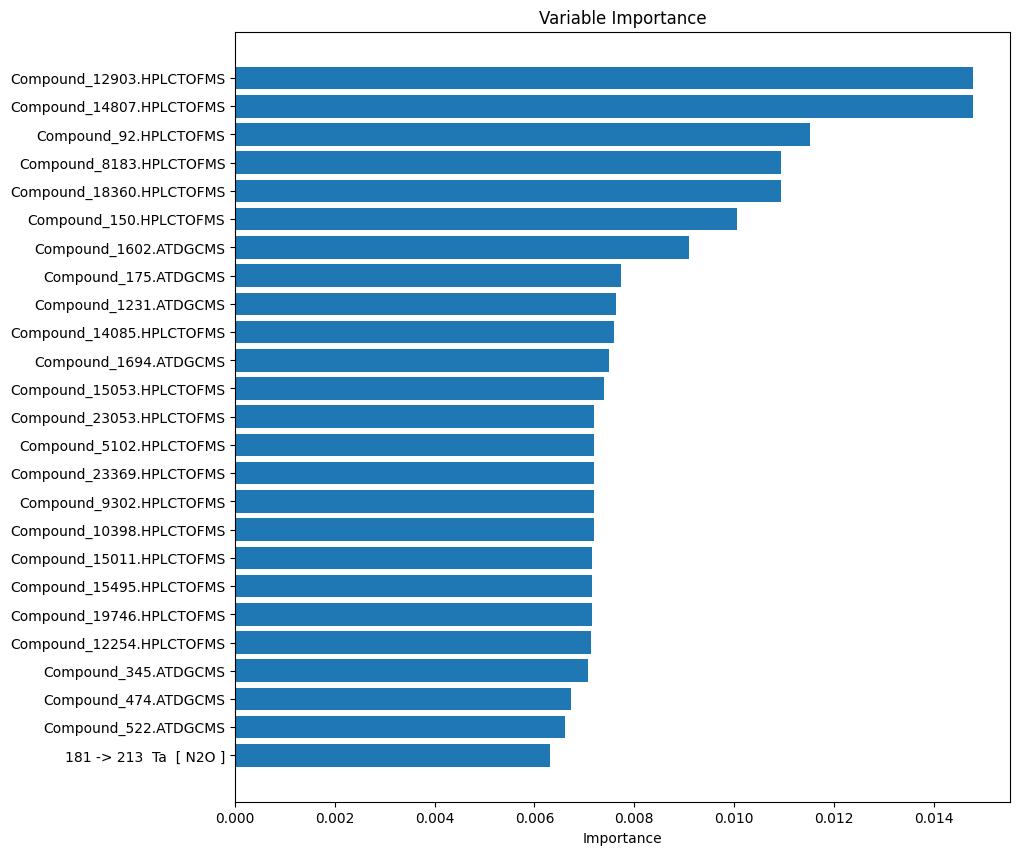

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.6713573463573463
                         precision    recall  f1-score   support

               Balloons       0.73      0.89      0.80         9
            Bottle caps       1.00      0.56      0.71         9
         Cigarillo tips       0.67      0.57      0.62         7
      Fabric face masks       0.50      0.29      0.36         7
     Fishing bait trays       1.00      0.29      0.44         7
        Food containers       0.71      0.62      0.67         8
         Food packaging       1.00      0.57      0.73         7
          Food wrappers       1.00      0.86      0.92         7
      Plastic Toy balls       0.75      0.86      0.80         7
        Plastic bottles       1.00      1.00      1.00         2
           Plastic cups       0.61      0.85      0.71        13
Plastic drinking straws       0.58      0.58      0.58        12
 Polystyrene food waste       0.33      0.86      0.48         7
  Various plastic waste       0.86      0.

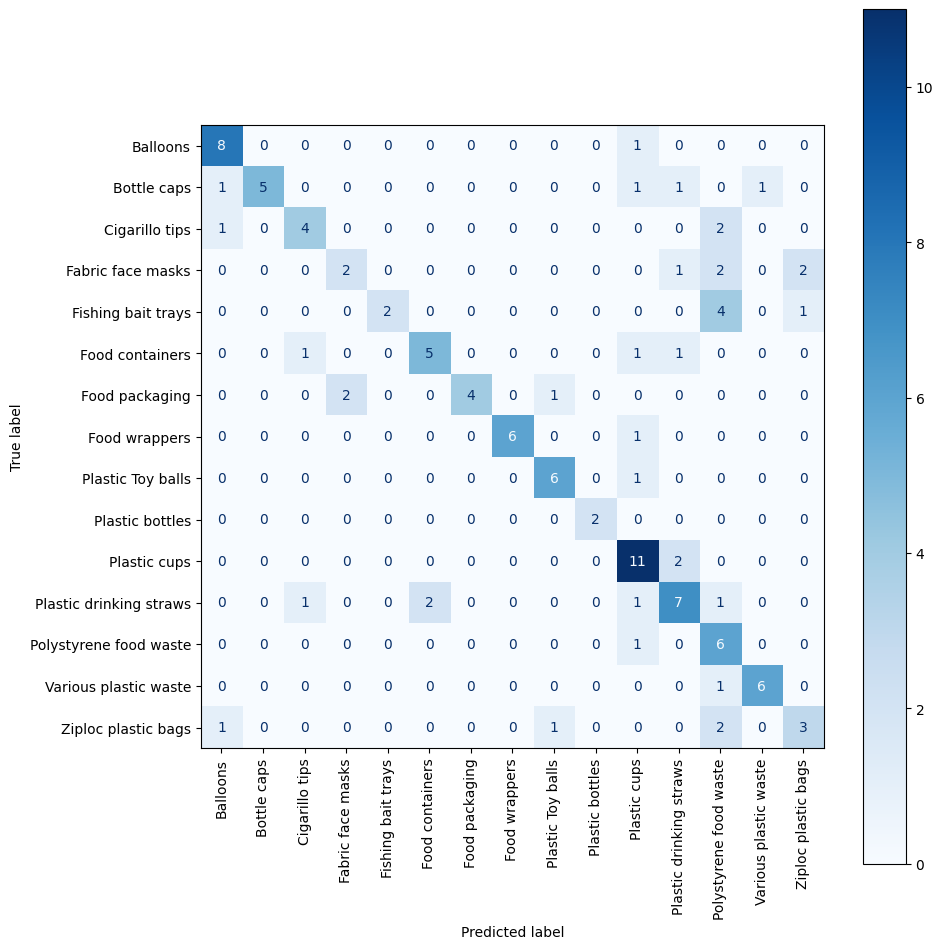

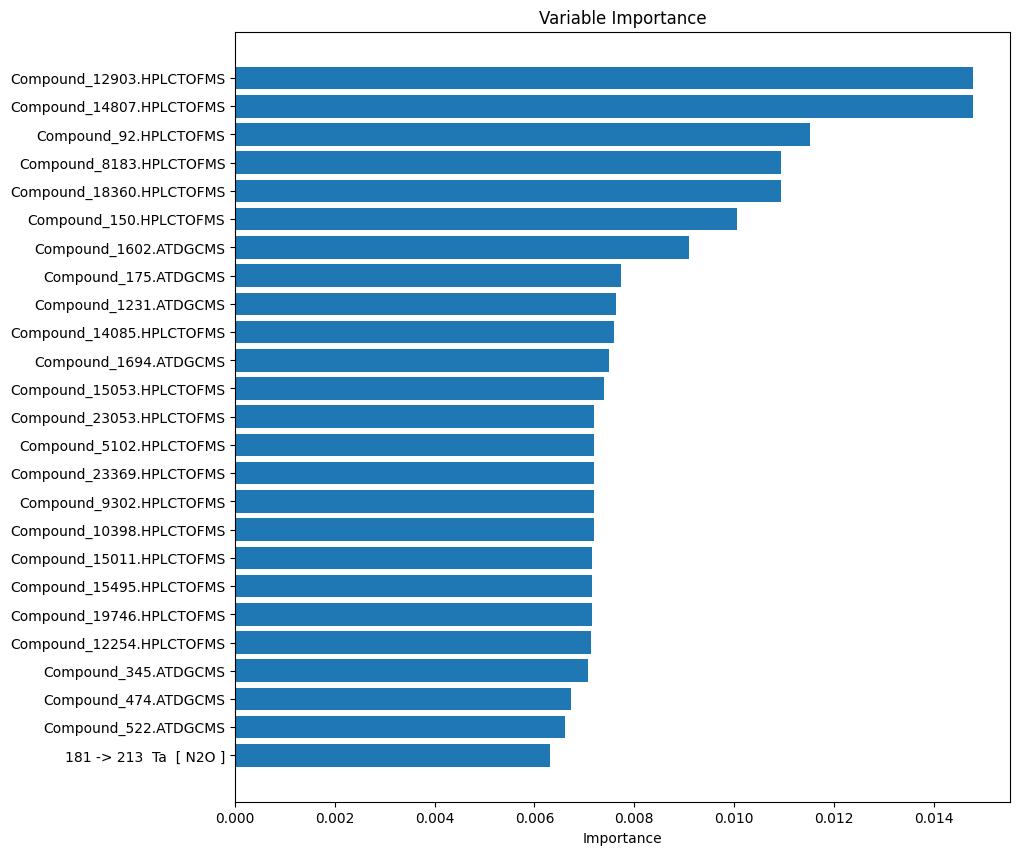

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.7285002035002036
                         precision    recall  f1-score   support

               Balloons       0.73      0.89      0.80         9
            Bottle caps       1.00      0.56      0.71         9
         Cigarillo tips       0.67      0.57      0.62         7
      Fabric face masks       0.83      0.71      0.77         7
     Fishing bait trays       0.42      0.71      0.53         7
        Food containers       0.83      0.62      0.71         8
         Food packaging       1.00      0.57      0.73         7
          Food wrappers       1.00      0.86      0.92         7
      Plastic Toy balls       1.00      0.86      0.92         7
        Plastic bottles       1.00      1.00      1.00         2
           Plastic cups       0.61      0.85      0.71        13
Plastic drinking straws       0.64      0.58      0.61        12
 Polystyrene food waste       0.50      0.86      0.63         7
  Various plastic waste       0.86      0.

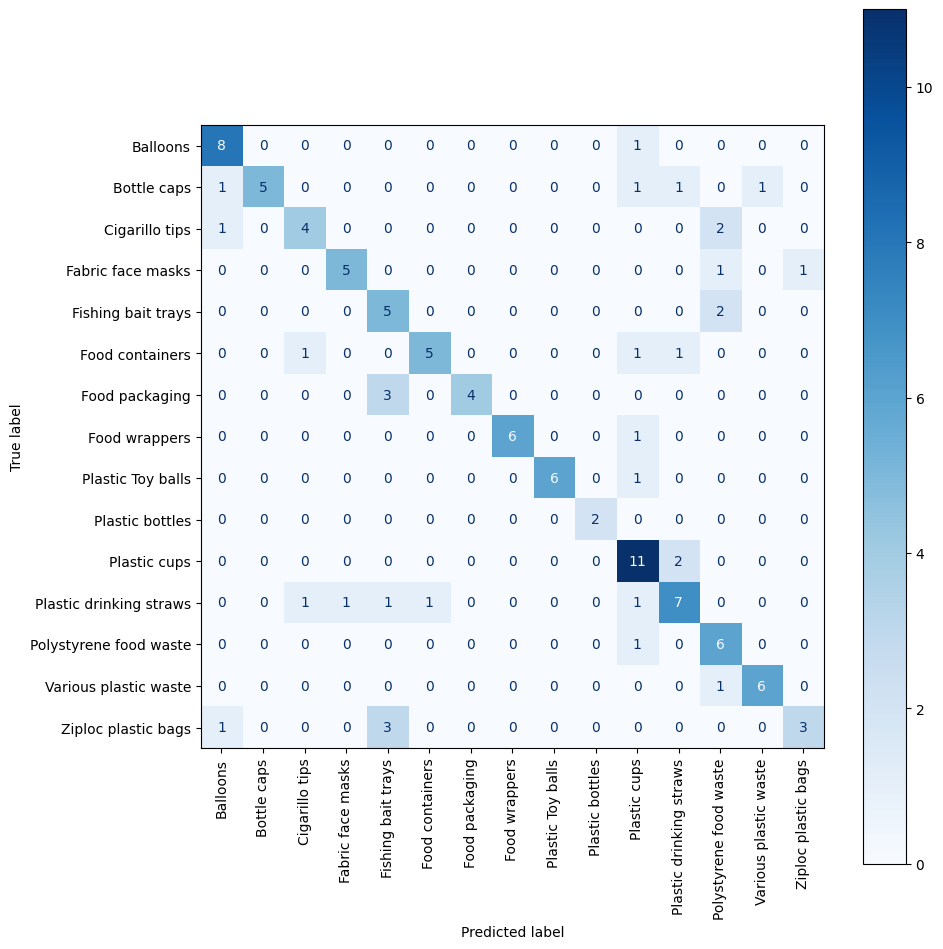

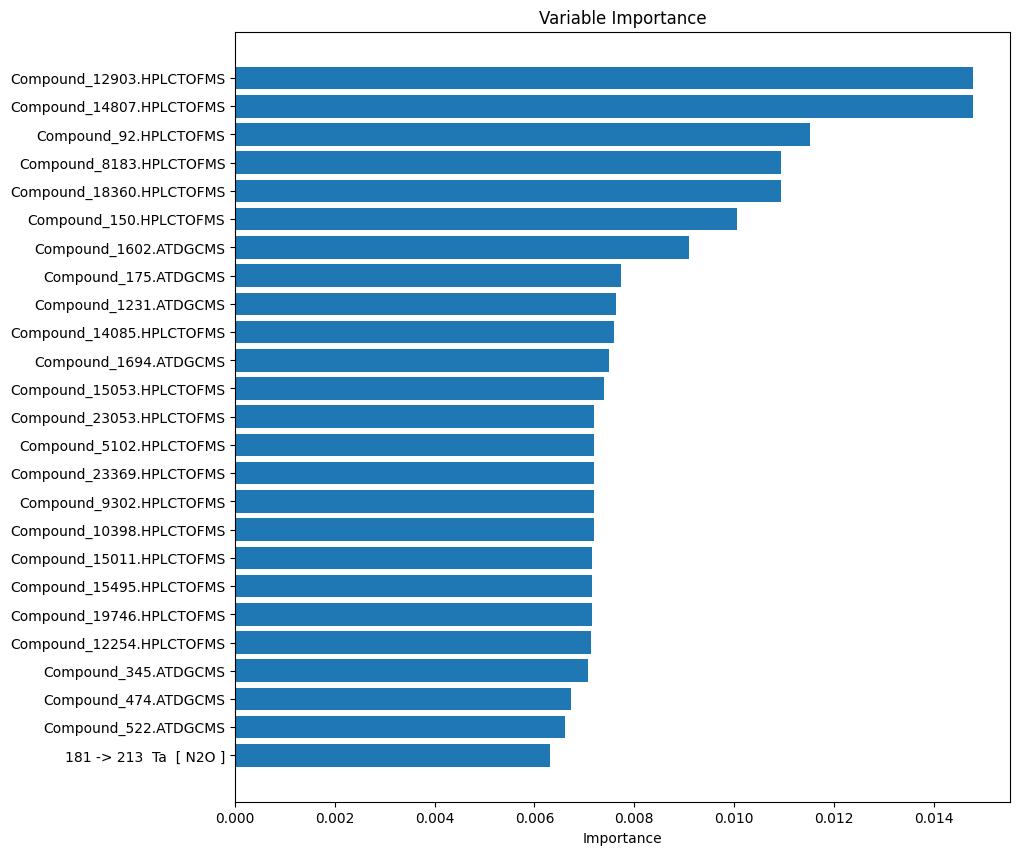

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\2847508061.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.6713573463573463
                         precision    recall  f1-score   support

               Balloons       0.73      0.89      0.80         9
            Bottle caps       1.00      0.56      0.71         9
         Cigarillo tips       0.67      0.57      0.62         7
      Fabric face masks       0.50      0.29      0.36         7
     Fishing bait trays       1.00      0.29      0.44         7
        Food containers       0.71      0.62      0.67         8
         Food packaging       1.00      0.57      0.73         7
          Food wrappers       1.00      0.86      0.92         7
      Plastic Toy balls       0.75      0.86      0.80         7
        Plastic bottles       1.00      1.00      1.00         2
           Plastic cups       0.61      0.85      0.71        13
Plastic drinking straws       0.58      0.58      0.58        12
 Polystyrene food waste       0.33      0.86      0.48         7
  Various plastic waste       0.86      0.

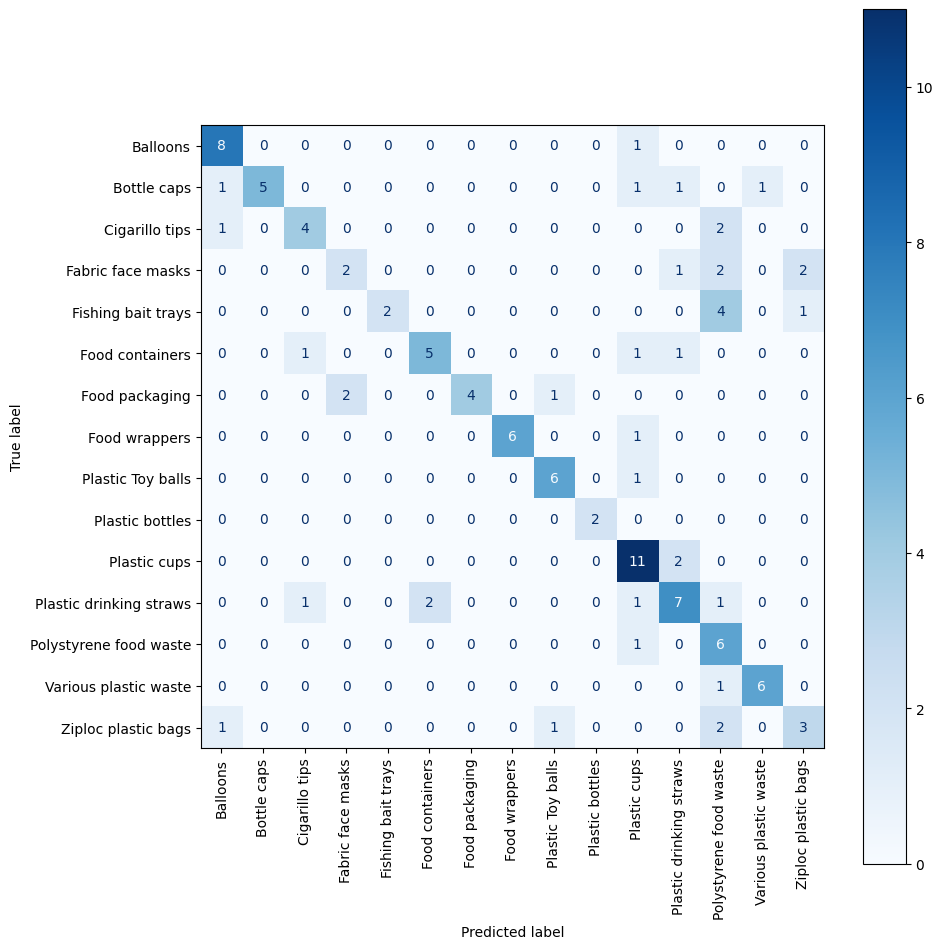

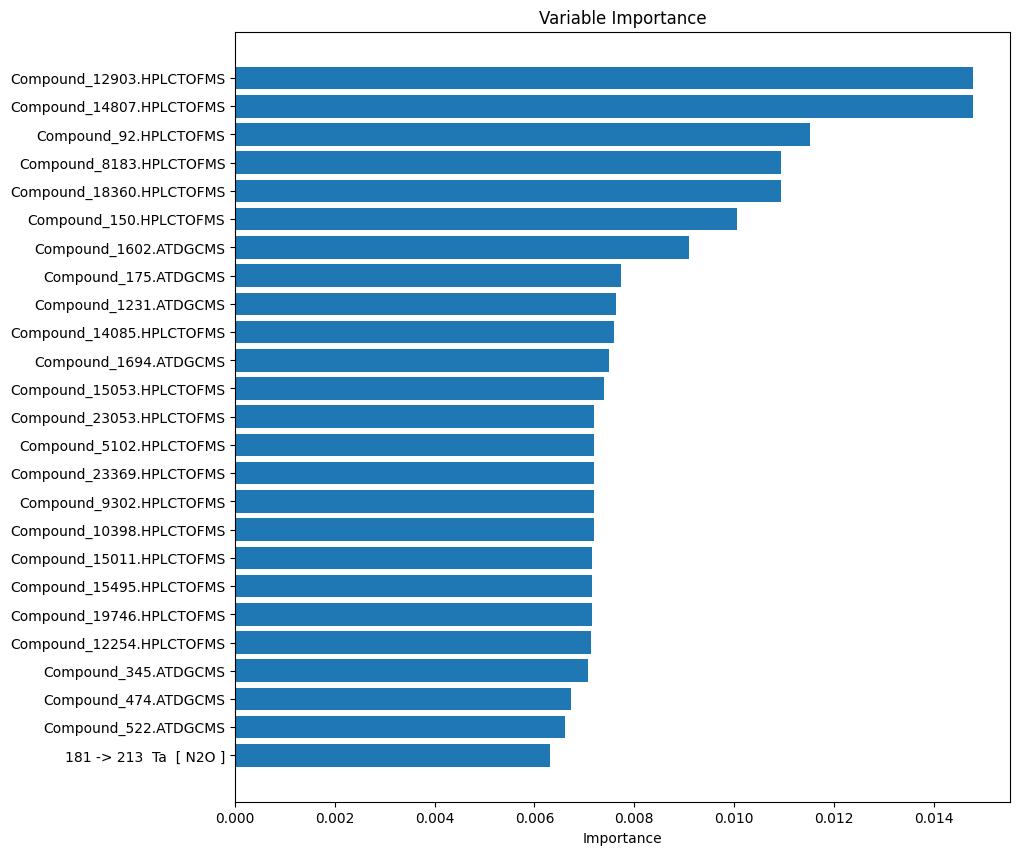

In [ ]:
for i in range(4):
    gbm = gbm_result(gc_hplc_icp_list,
                           # sig_comp_list = significant_comp,
                           list_ele=i, split_train = 0.6)

### Supported Vector Machine <a class="anchor" id="svm"></a>

In [ ]:
def f_importances(coef, names, ntop = 25):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    # take top n positive and top n negative effect features
    topimp = imp[:ntop] + imp[-ntop:]
    topnames = names[:ntop] + names[-ntop:]
    plt.barh(range(len(topnames)), topimp, align='center')
    plt.yticks(range(len(topnames)), topnames)
    plt.show()

def SVM_res(dat_list,
            # sig_comp_list,
            list_ele, split_train):

    dat = dat_list[list_ele]
    # Select relevant columns
    dat = dat[['File', 'Subcategory', 'Feature', 'Values']]

    # Group by and take the mean of 'Values'
    dat = dat.groupby(['File', 'Subcategory', 'Feature']).agg({'Values': 'mean'}).reset_index()

    # Pivot the table
    dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

    # Set 'File' as index (equivalent to rownames in R)
    dat.set_index('File', inplace=True)

    # Keep only significant comp from Wilcoxon test
    # sig_comp = sig_comp_list[list_ele]['comp'].unique()
    # df = gc_hplc[np.append(sig_comp, 'Category')]

    # Iterate through each row and replace NaNs
    for idx, row in dat.iterrows():
        na_indices = row.isna()
        na_count = na_indices.sum()

        if na_count > 0:
            dat.loc[idx, na_indices.index[na_indices]] = 0

    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat['Subcategory'].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

    # Extract the features and labels
    X = dat.drop(columns=['Subcategory'])
    y = dat['Subcategory']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split_train, stratify = y,
                                                        random_state= 123
                                                       )

    # Create the parameter grid based on the results of random search
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear', 'poly', 'sigmoid', 'rbf']}

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf)
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)['Subcategory'].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)['Subcategory'].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)

    # Create a GridSearchCV object and fit it to the training data
    svm_grid = RandomizedSearchCV(SVC(probability=True), param_distributions=param_grid,
                                  # number of cv = number of member of classes with least no. of members
                                  cv = cv,
                                  scoring = 'balanced_accuracy',
                                  n_jobs = -1, random_state=123).fit(X_train, y_train).best_params_

    svm_best = SVC(kernel = svm_grid['kernel'], gamma = svm_grid['gamma'], C=svm_grid['C'], probability = True)

    svm_best.fit(X_train, y_train)

    # Prediction results
    # For test set
    predictions_test = svm_best.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=svm_best.classes_)
    pred_df_test['File'] = X_test.index.get_level_values('File').values

    # Assign true and predicted labels
    # For test set
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)

    # Balanced accuracy score
    print("Balanced Accuracy (testing):" + str(balanced_accuracy_score(y_true_test, y_pred_test)))

    # Generate confusion matrix
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=svm_best.classes_)

    print(classification_report(y_true_test, y_pred_test))

    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=svm_best.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

    # Compute permutation importance if kernel = 'rbf'
    perimp = permutation_importance(svm_best, X_test, y_test,
                                    n_repeats=1, random_state=42, n_jobs = -1).importances_mean

        # Extract important features if kernel = 'linear'
    features_names = list(X_train.columns)
    f_importances(perimp,
    #         permutation_importance(svm_best, X_test, y_test,
    #                                          n_repeats=5, random_state=42, n_jobs = -1).importances_mean,
                  features_names)
    return svm_best

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Balanced Accuracy (testing):0.0
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00       1.0
         Cigarillo tips       0.00      0.00      0.00       2.0
      Fabric face masks       0.00      0.00      0.00       2.0
     Fishing bait trays       0.00      0.00      0.00       2.0
        Food containers       0.00      0.00      0.00       1.0
         Food packaging       0.00      0.00      0.00       2.0
          Food wrappers       0.00      0.00      0.00       2.0
      Plastic Toy balls       0.00      0.00      0.00       2.0
Plastic drinking straws       0.00      0.00      0.00       1.0
 Polystyrene food waste       0.00      0.00      0.00       2.0
  Various plastic waste       0.00      0.00      0.00       2.0
    Ziploc plastic bags       0.00      0.00      0.00       2.0

               accuracy                           0.00      21.0
              macro avg       0.00      0.00      0.00  

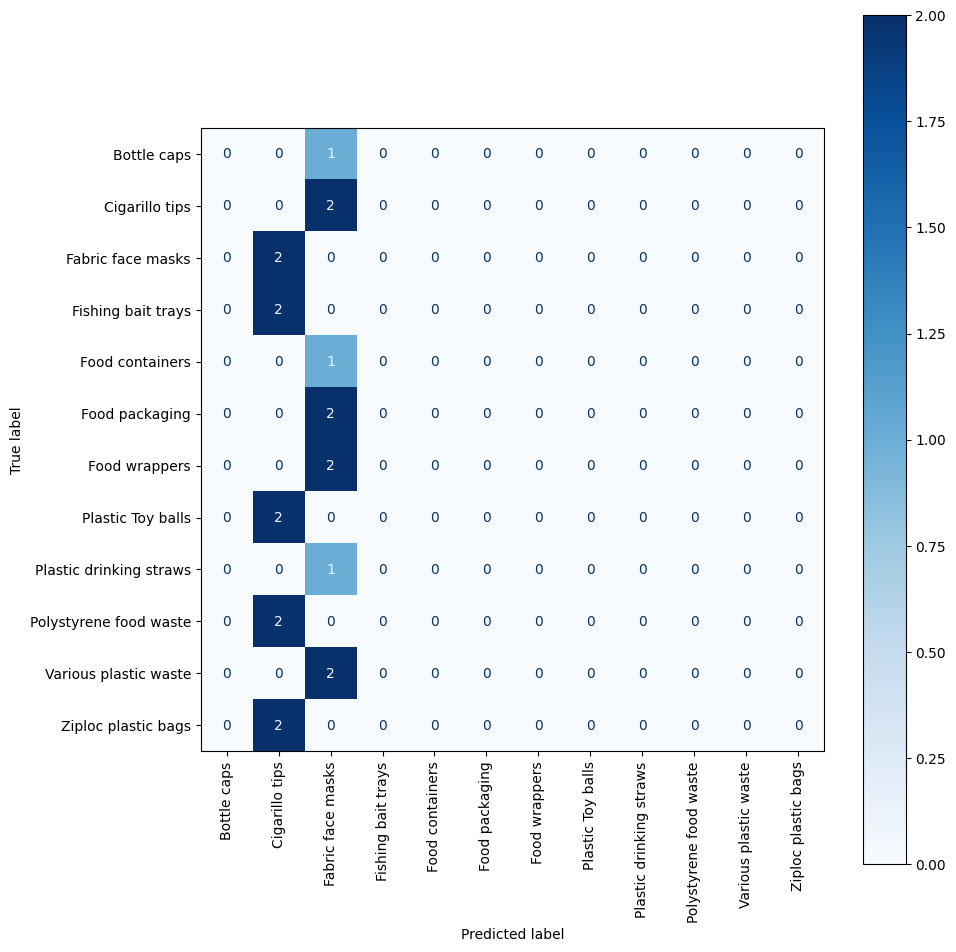

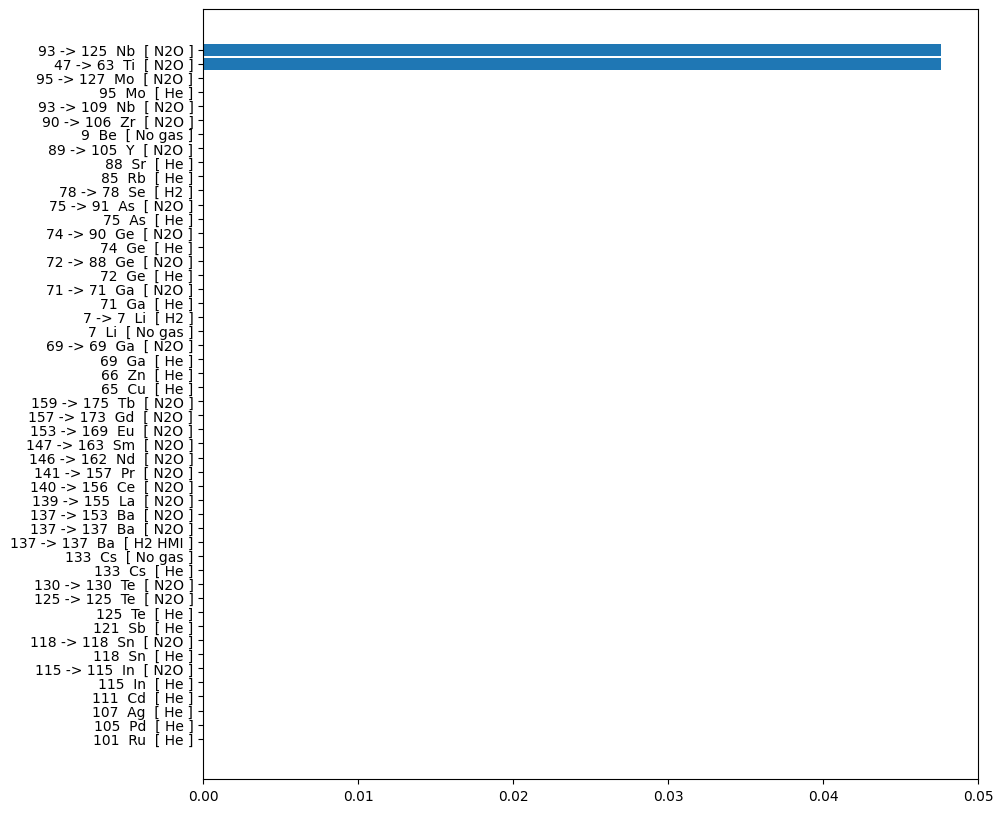

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Balanced Accuracy (testing):0.0
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00       1.0
         Cigarillo tips       0.00      0.00      0.00       2.0
      Fabric face masks       0.00      0.00      0.00       2.0
     Fishing bait trays       0.00      0.00      0.00       2.0
        Food containers       0.00      0.00      0.00       1.0
         Food packaging       0.00      0.00      0.00       2.0
          Food wrappers       0.00      0.00      0.00       2.0
      Plastic Toy balls       0.00      0.00      0.00       2.0
Plastic drinking straws       0.00      0.00      0.00       1.0
 Polystyrene food waste       0.00      0.00      0.00       2.0
  Various plastic waste       0.00      0.00      0.00       2.0
    Ziploc plastic bags       0.00      0.00      0.00       2.0

               accuracy                           0.00      21.0
              macro avg       0.00      0.00      0.00  

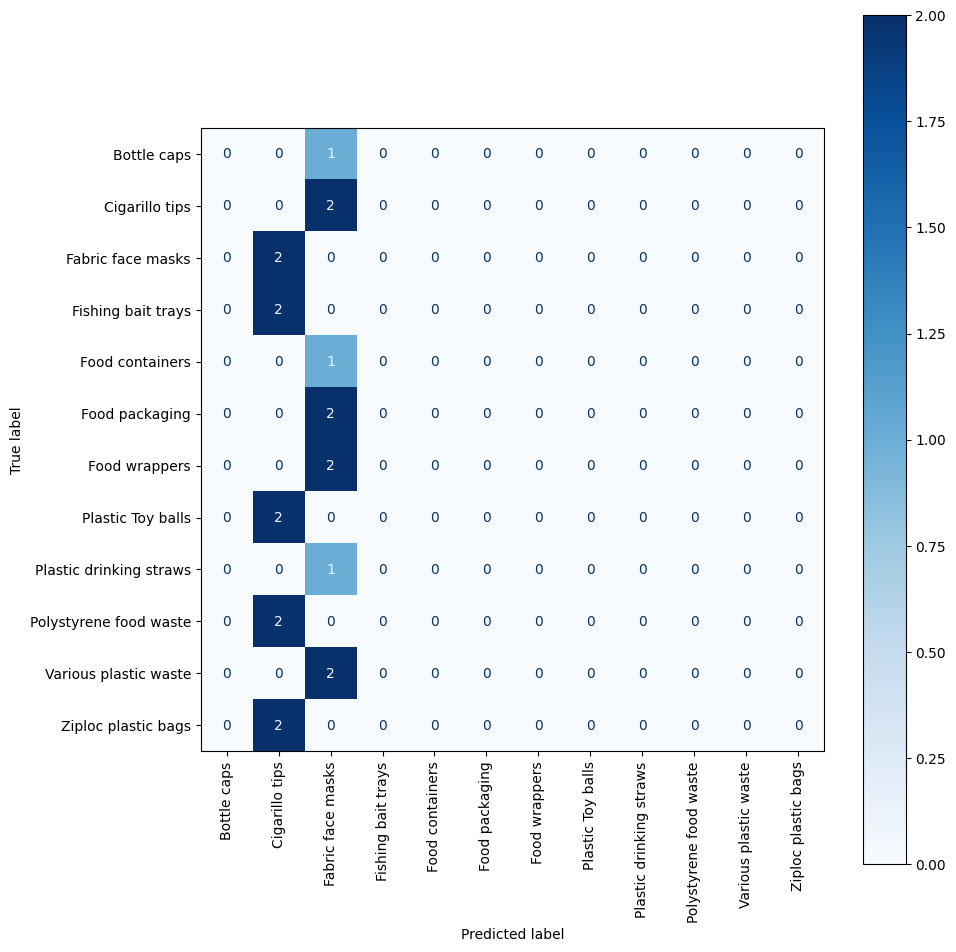

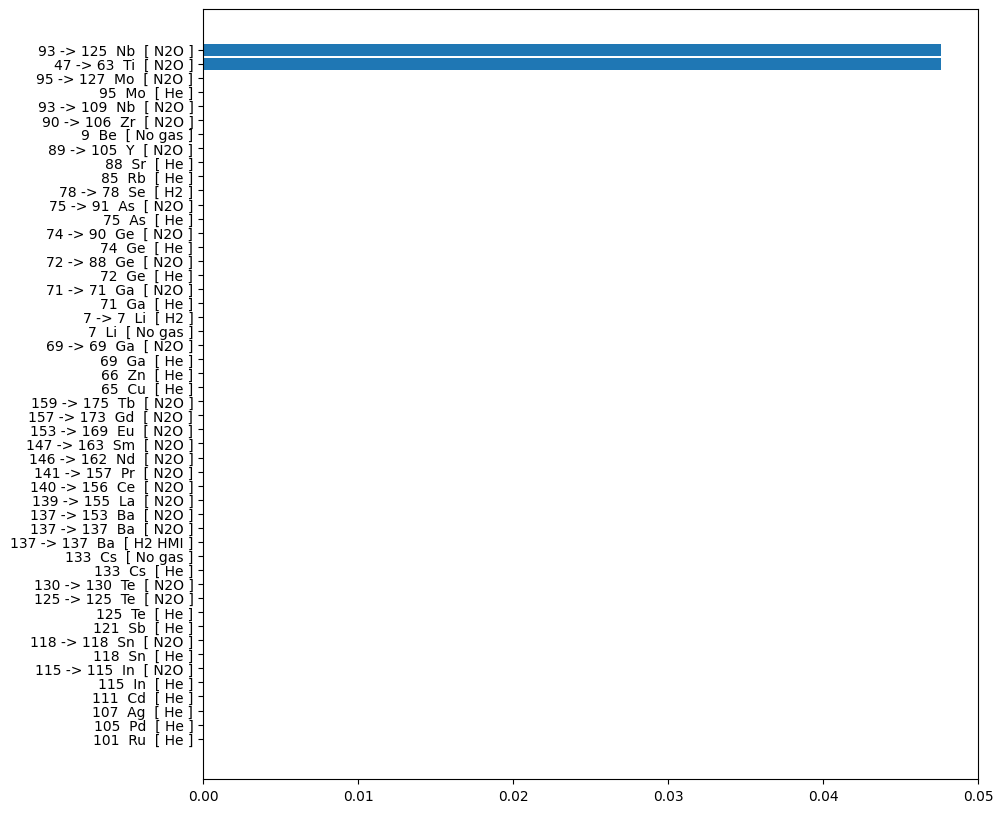

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Balanced Accuracy (testing):0.0
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00       1.0
         Cigarillo tips       0.00      0.00      0.00       2.0
      Fabric face masks       0.00      0.00      0.00       2.0
     Fishing bait trays       0.00      0.00      0.00       2.0
        Food containers       0.00      0.00      0.00       1.0
         Food packaging       0.00      0.00      0.00       2.0
          Food wrappers       0.00      0.00      0.00       2.0
      Plastic Toy balls       0.00      0.00      0.00       2.0
Plastic drinking straws       0.00      0.00      0.00       1.0
 Polystyrene food waste       0.00      0.00      0.00       2.0
  Various plastic waste       0.00      0.00      0.00       2.0
    Ziploc plastic bags       0.00      0.00      0.00       2.0

               accuracy                           0.00      21.0
              macro avg       0.00      0.00      0.00  

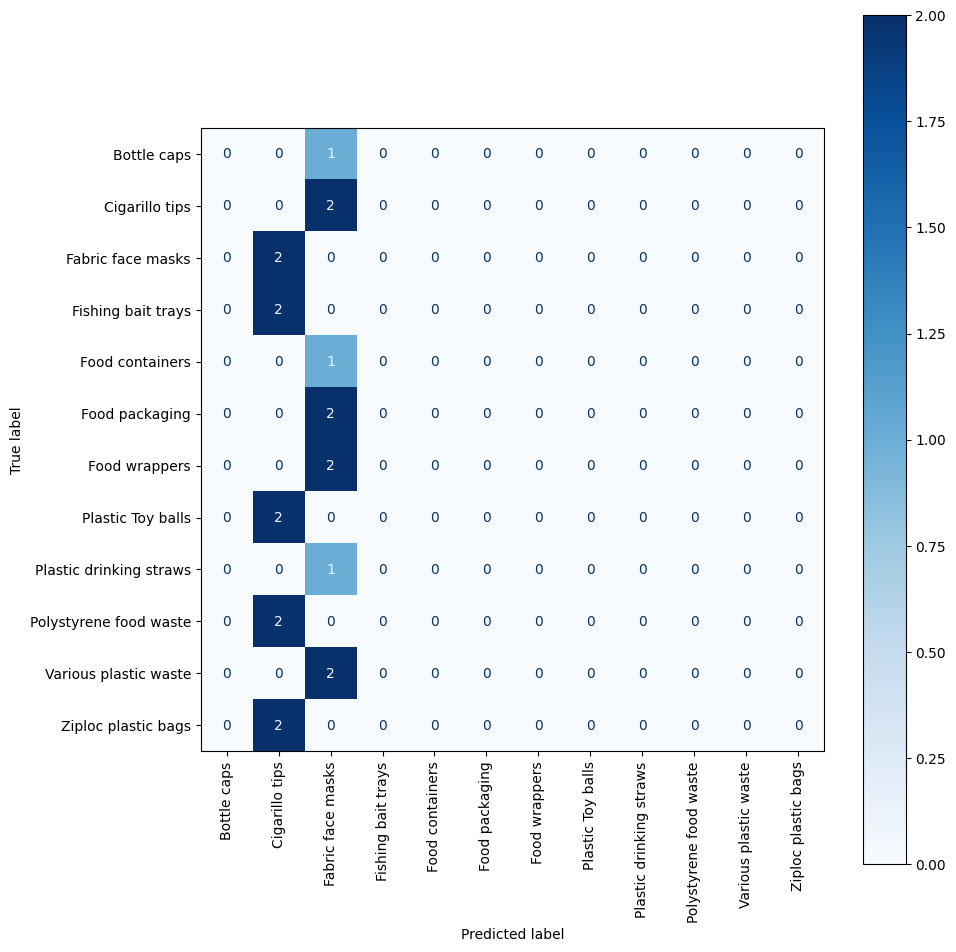

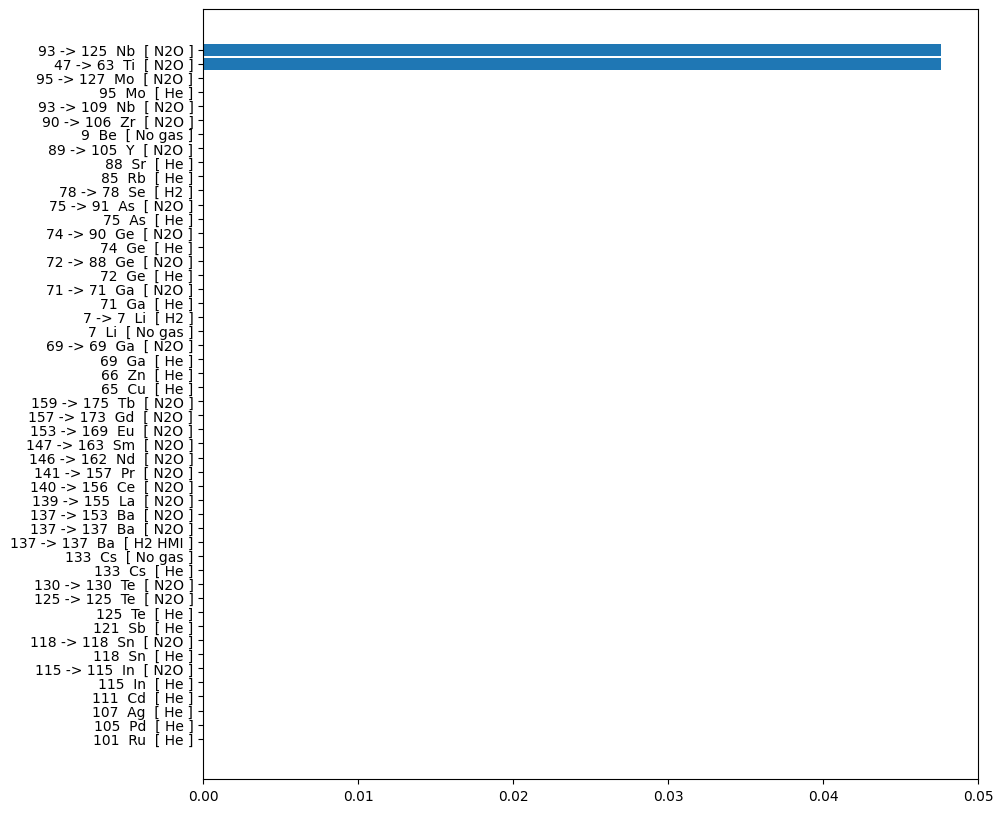

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Balanced Accuracy (testing):0.0
                         precision    recall  f1-score   support

            Bottle caps       0.00      0.00      0.00       1.0
         Cigarillo tips       0.00      0.00      0.00       2.0
      Fabric face masks       0.00      0.00      0.00       2.0
     Fishing bait trays       0.00      0.00      0.00       2.0
        Food containers       0.00      0.00      0.00       1.0
         Food packaging       0.00      0.00      0.00       2.0
          Food wrappers       0.00      0.00      0.00       2.0
      Plastic Toy balls       0.00      0.00      0.00       2.0
Plastic drinking straws       0.00      0.00      0.00       1.0
 Polystyrene food waste       0.00      0.00      0.00       2.0
  Various plastic waste       0.00      0.00      0.00       2.0
    Ziploc plastic bags       0.00      0.00      0.00       2.0

               accuracy                           0.00      21.0
              macro avg       0.00      0.00      0.00  

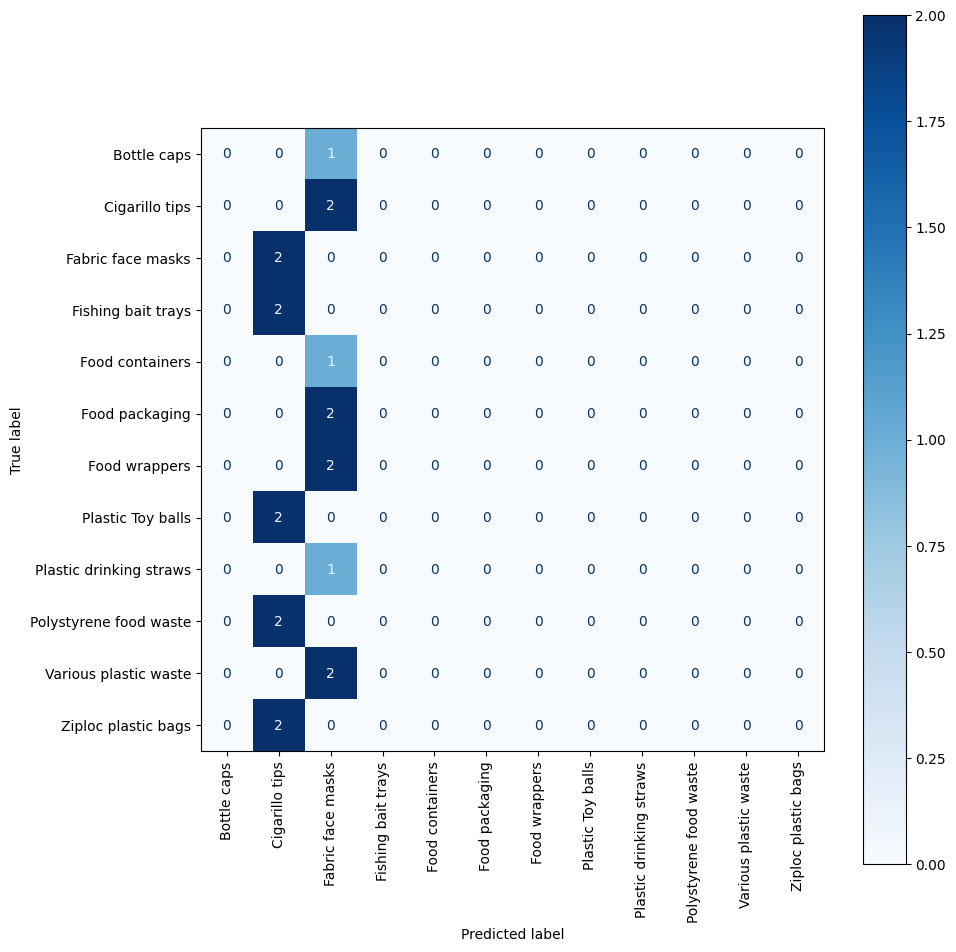

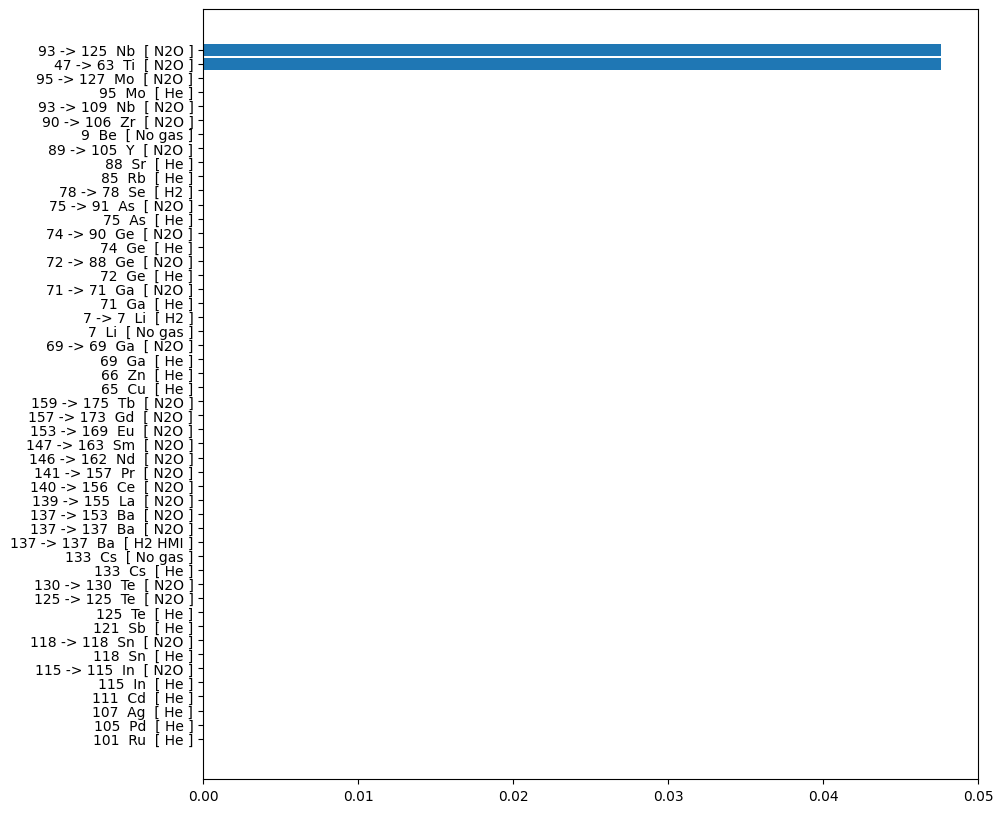

In [ ]:
for i in range(4):
    svm = SVM_res(icp_list,
                          # sig_comp_list = significant_comp,
                          list_ele = i,
                          split_train = 0.6)

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.422975172975173
                         precision    recall  f1-score   support

               Balloons       0.62      0.89      0.73         9
            Bottle caps       0.83      0.56      0.67         9
         Cigarillo tips       1.00      0.43      0.60         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.75      0.43      0.55         7
          Food wrappers       0.42      0.71      0.53         7
      Plastic Toy balls       0.86      0.86      0.86         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.71      0.77      0.74        13
Plastic drinking straws       0.38      0.42      0.40        12
 Polystyrene food waste       0.26      0.86      0.40         7
  Various plastic waste       1.00      0.2

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

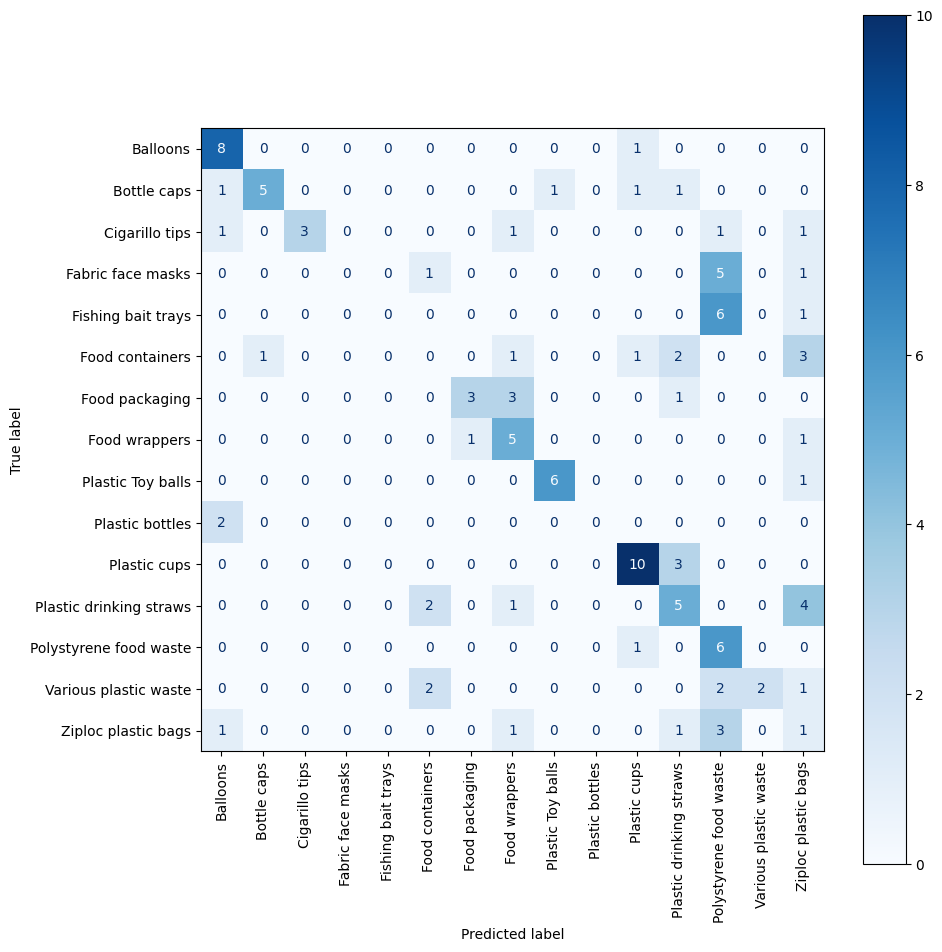

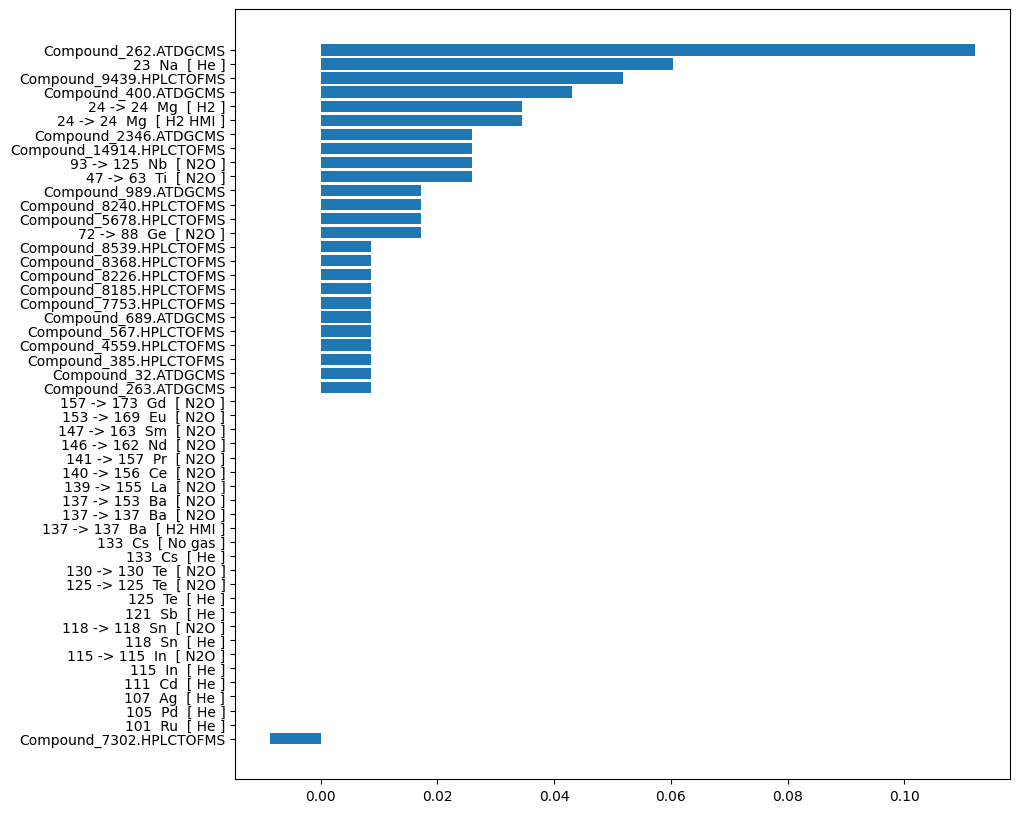

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.42099104599104603
                         precision    recall  f1-score   support

               Balloons       0.73      0.89      0.80         9
            Bottle caps       0.83      0.56      0.67         9
         Cigarillo tips       1.00      0.57      0.73         7
      Fabric face masks       0.33      0.14      0.20         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       1.00      0.12      0.22         8
         Food packaging       0.50      0.14      0.22         7
          Food wrappers       0.44      0.57      0.50         7
      Plastic Toy balls       0.86      0.86      0.86         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.67      0.77      0.71        13
Plastic drinking straws       0.22      0.83      0.34        12
 Polystyrene food waste       0.50      0.43      0.46         7
  Various plastic waste       0.50      0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

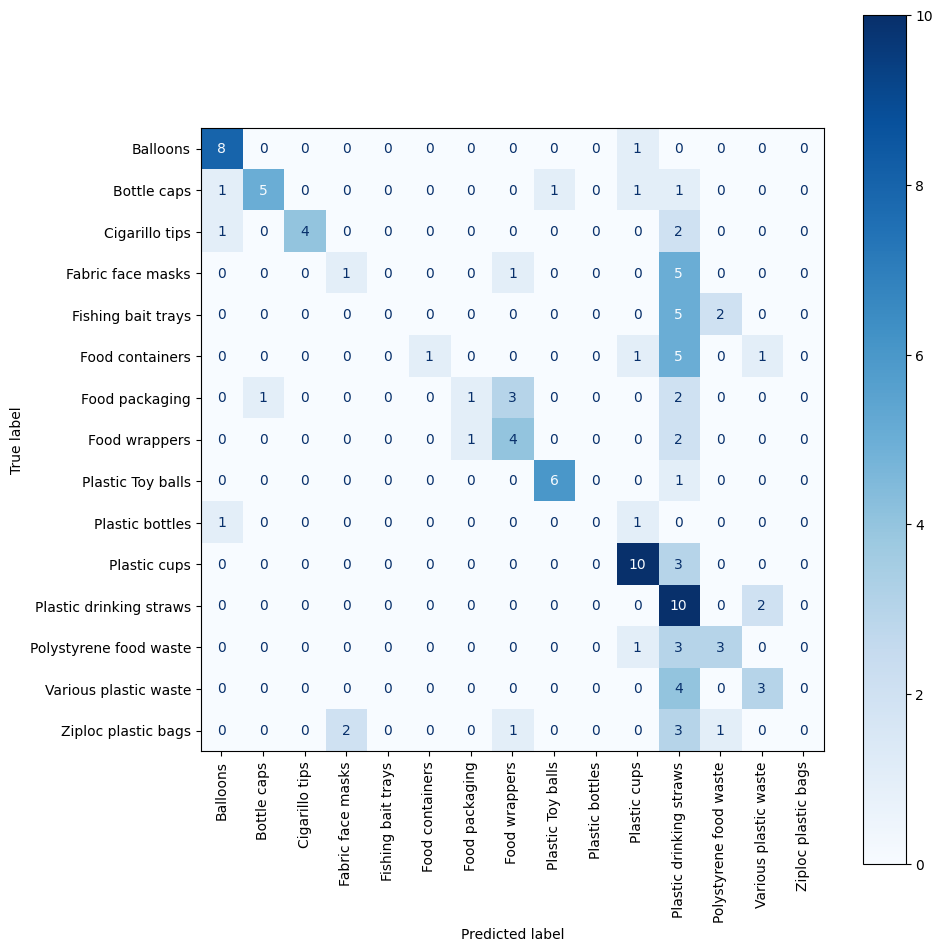

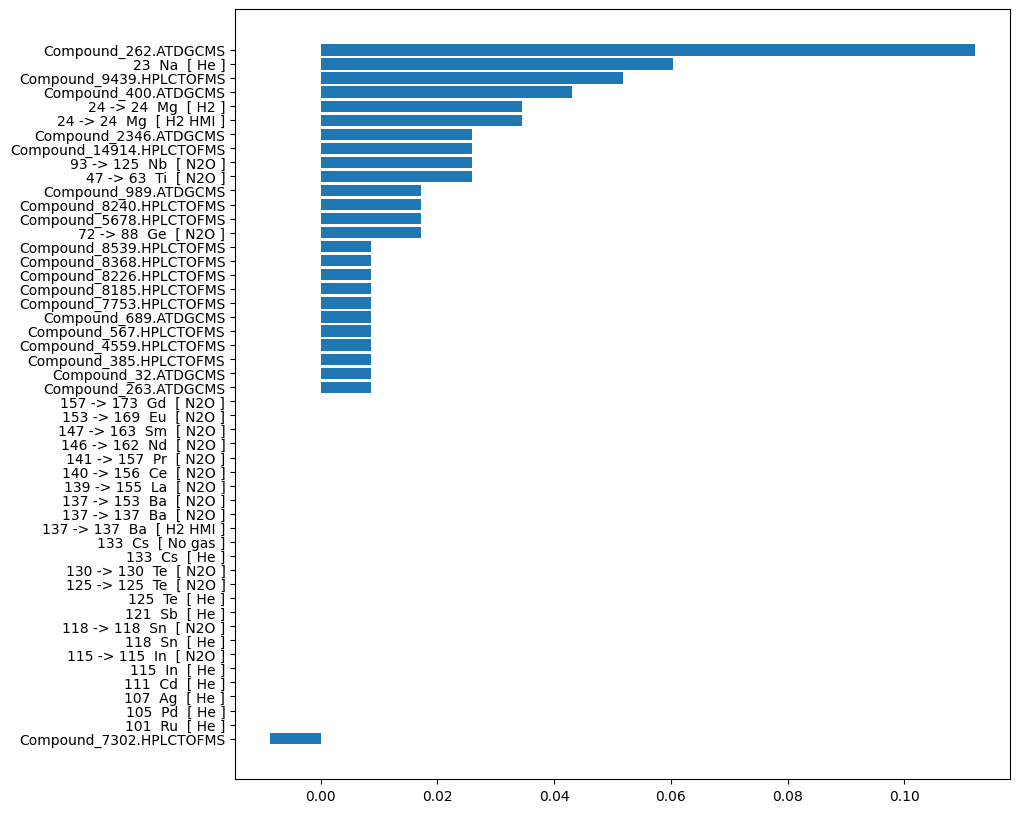

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.45114977614977614
                         precision    recall  f1-score   support

               Balloons       0.62      0.89      0.73         9
            Bottle caps       1.00      0.56      0.71         9
         Cigarillo tips       1.00      0.43      0.60         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.19      0.38      0.25         8
         Food packaging       0.75      0.43      0.55         7
          Food wrappers       0.56      0.71      0.63         7
      Plastic Toy balls       0.86      0.86      0.86         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.67      0.77      0.71        13
Plastic drinking straws       0.45      0.75      0.56        12
 Polystyrene food waste       0.32      0.86      0.46         7
  Various plastic waste       0.00      0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

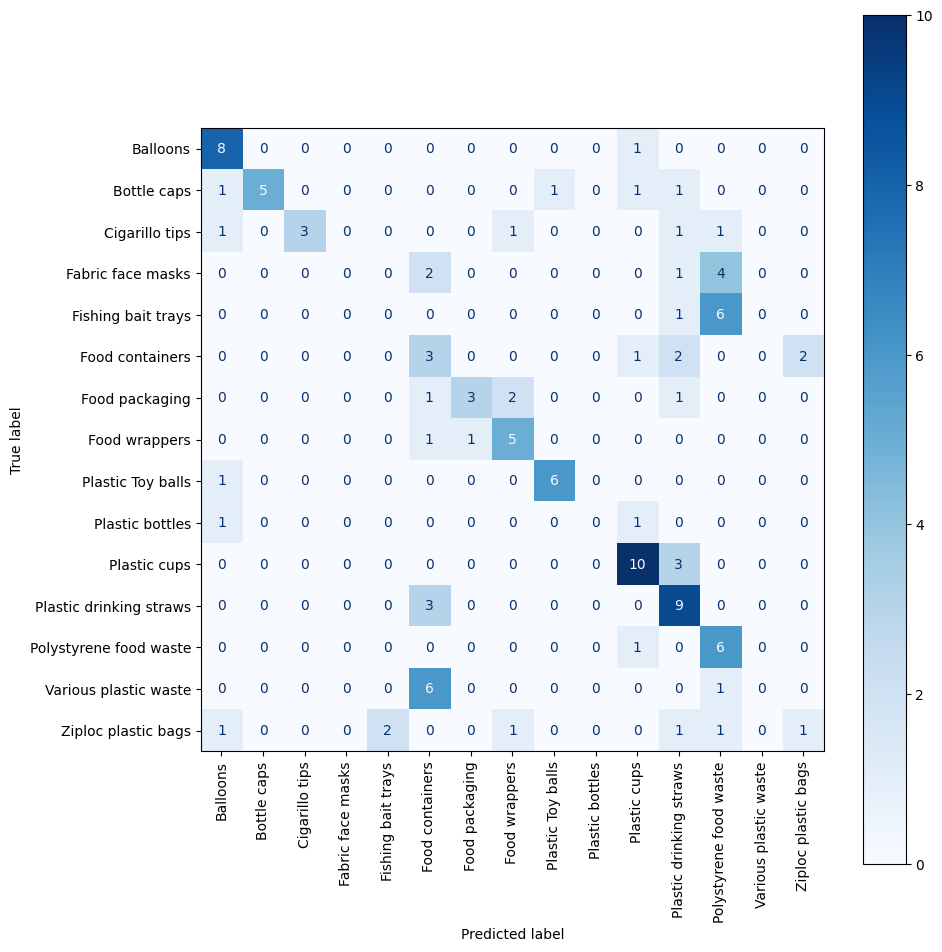

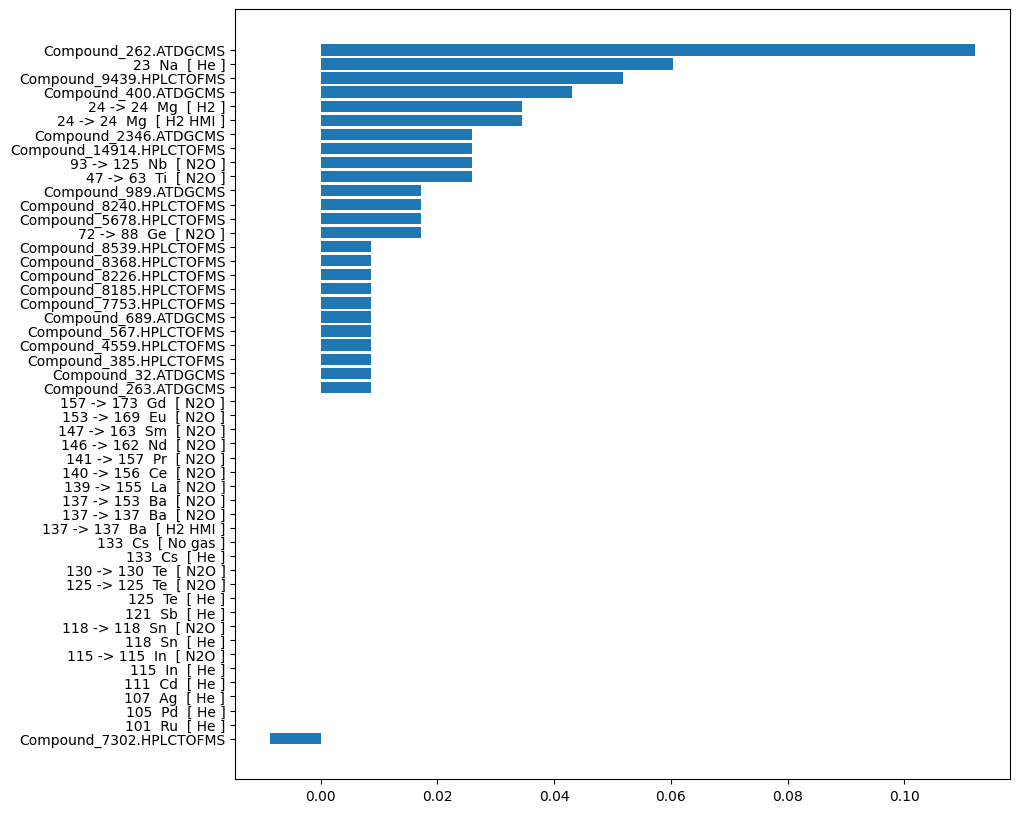

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\729107441.py:23: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Balanced Accuracy (testing):0.395991045991046
                         precision    recall  f1-score   support

               Balloons       0.67      0.89      0.76         9
            Bottle caps       0.71      0.56      0.63         9
         Cigarillo tips       1.00      0.14      0.25         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.75      0.43      0.55         7
          Food wrappers       0.38      0.71      0.50         7
      Plastic Toy balls       0.86      0.86      0.86         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.67      0.77      0.71        13
Plastic drinking straws       0.35      0.58      0.44        12
 Polystyrene food waste       0.30      0.86      0.44         7
  Various plastic waste       0.00      0.0

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

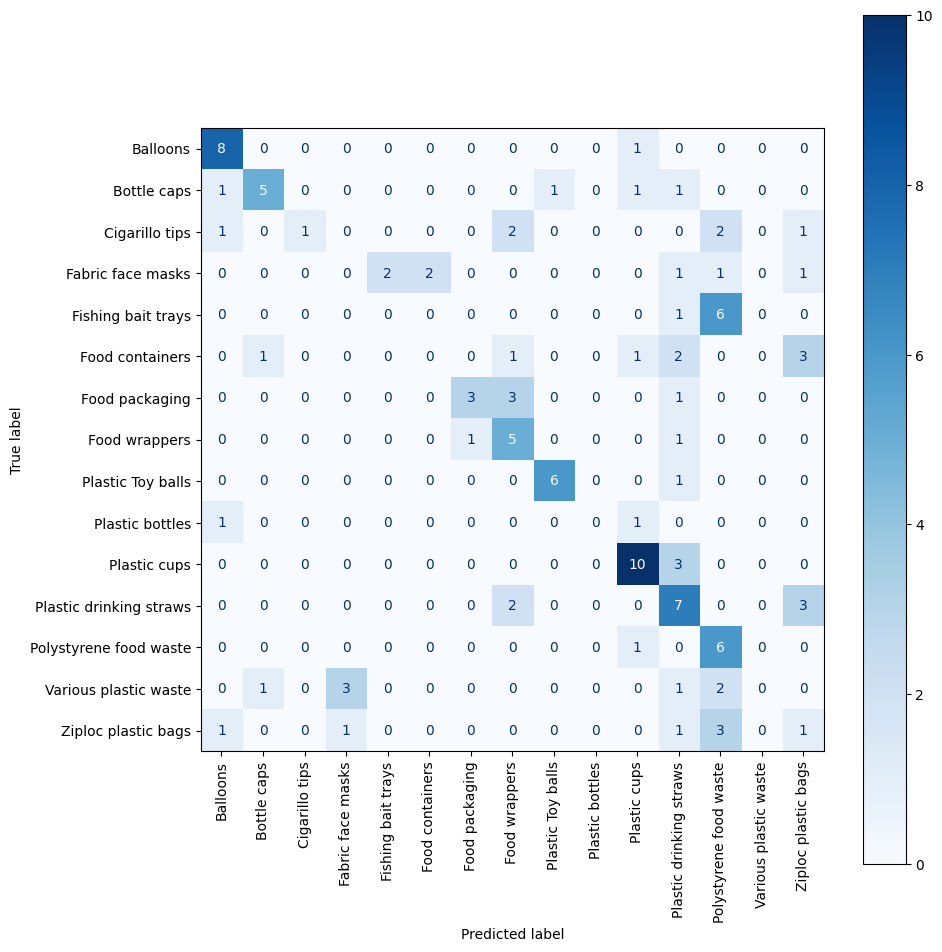

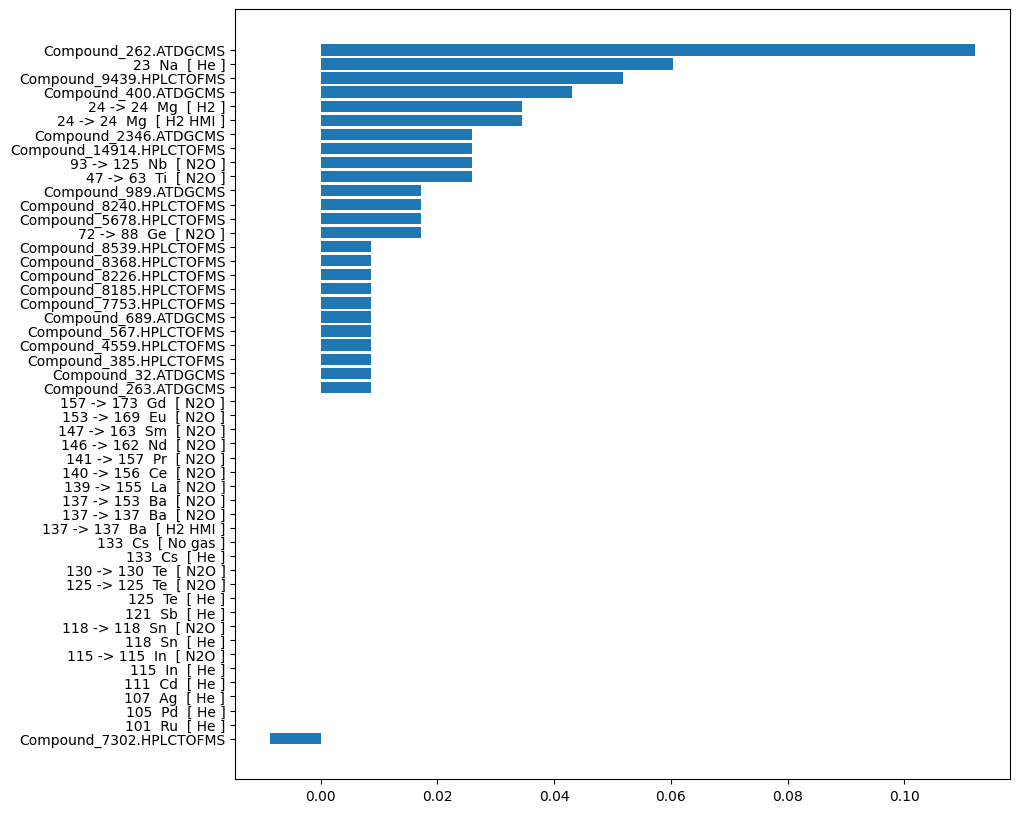

In [ ]:
for i in range(4):
    svm = SVM_res(gc_hplc_icp_list,
                          # sig_comp_list = significant_comp,
                          list_ele = i,
                          split_train = 0.6)

### Penalized Multinomial Logistic Regression <a class="anchor" id="multinom"></a>

In [ ]:
def caret_multinomlog_result(dat_list,
                             # sig_comp_list,
                             list_ele, split_train):

    dat = dat_list[list_ele]
    # Select relevant columns
    dat = dat[['File', 'Subcategory', 'Feature', 'Values']]

    # Group by and take the mean of 'Values'
    dat = dat.groupby(['File', 'Subcategory', 'Feature']).agg({'Values': 'mean'}).reset_index()

    # Pivot the table
    dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

    # Set 'File' as index (equivalent to rownames in R)
    dat.set_index('File', inplace=True)

    # Keep only significant comp from Wilcoxon test
    # sig_comp = sig_comp_list[list_ele]['comp'].unique()
    # df = gc_hplc[np.append(sig_comp, 'Category')]

    # Iterate through each row and replace NaNs
    for idx, row in dat.iterrows():
        na_indices = row.isna()
        na_count = na_indices.sum()

        if na_count > 0:
            dat.loc[idx, na_indices.index[na_indices]] = 0

    # If a class only have 1 member then exclude that class from the ML
    # Count the frequency of each class
    class_counts = dat['Subcategory'].astype(str).value_counts()
    # Filter out classes with only one member
    dat = dat[dat['Subcategory'].astype(str).map(class_counts) > 1]

    # Extract the features and labels
    X = dat.drop(columns=['Subcategory'])
    y = dat['Subcategory']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split_train, stratify = y,
                                                        random_state= 123
                                                       )

    # Standardizing the features (important for logistic regression)
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    # The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf)
    cv = RepeatedStratifiedKFold(n_splits = pd.DataFrame(y_train)['Subcategory'].value_counts().min(),
                                 n_repeats = 10, random_state = 123)
    if pd.DataFrame(y_train)['Subcategory'].value_counts().min() == 1:
        cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 10, random_state = 123)

    # Grid search with 5-fold cross validation for best model parameters
    param_grid = {
    'C':  [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # Generate an array of stepwise values
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'multi_class': ['multinomial']
    }

    multinom_grid = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid,
                                       # number of cv = number of member of classes with least no. of members
                                       cv = cv,
                                       scoring = 'balanced_accuracy', n_jobs = -1, random_state=123).fit(X_train, y_train).best_params_

    # Training the final model after Cross-Validation grid search
    multinomlog_mod = LogisticRegression(solver = multinom_grid['solver'],  penalty = multinom_grid['penalty'], random_state=123,
                                         multi_class = multinom_grid['multi_class'], C = multinom_grid['C'], max_iter=10000, n_jobs=-1)

    # Fitting the model to the whole training data
    multinomlog_mod.fit(X_train, y_train)

    # Prediction results
    # For test set
    predictions_test = multinomlog_mod.predict_proba(X_test)
    pred_df_test = pd.DataFrame(predictions_test, columns=multinomlog_mod.classes_)
    pred_df_test['File'] = X_test.index.get_level_values('File').values

    # Assign true and predicted labels
    y_true_test = y_test
    y_pred_test = pred_df_test.select_dtypes(include=[np.number]).idxmax(axis=1)

    # Balanced accuracy score
    print("Balanced Accuracy (testing) :" + str(balanced_accuracy_score(y_true_test, y_pred_test)))

    # Generate confusion matrix
    conf_matrix_sklearn = confusion_matrix(y_true_test, y_pred_test, labels=multinomlog_mod.classes_)

    # For a more detailed output similar to R's caret package
    print(classification_report(y_true_test, y_pred_test))

    # To visualize the confusion matrix
    ConfusionMatrixDisplay(conf_matrix_sklearn,
                          display_labels=multinomlog_mod.classes_).plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()

     # Plot feature importance
    features_names = list(X_train.columns)
    f_importances(multinomlog_mod.coef_[0],
                  features_names)
    return multinomlog_mod

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.16666666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.07      1.00      0.13         1
         Cigarillo tips       0.00      0.00      0.00         2
      Fabric face masks       0.00      0.00      0.00         2
     Fishing bait trays       0.00      0.00      0.00         2
        Food containers       0.14      1.00      0.25         1
         Food packaging       0.00      0.00      0.00         2
          Food wrappers       0.00      0.00      0.00         2
      Plastic Toy balls       0.00      0.00      0.00         2
Plastic drinking straws       0.00      0.00      0.00         1
 Polystyrene food waste       0.00      0.00      0.00         2
  Various plastic waste       0.00      0.00      0.00         2
    Ziploc plastic bags       0.00      0.00      0.00         2

               accuracy                           0.10        21
              macro avg       0.02     

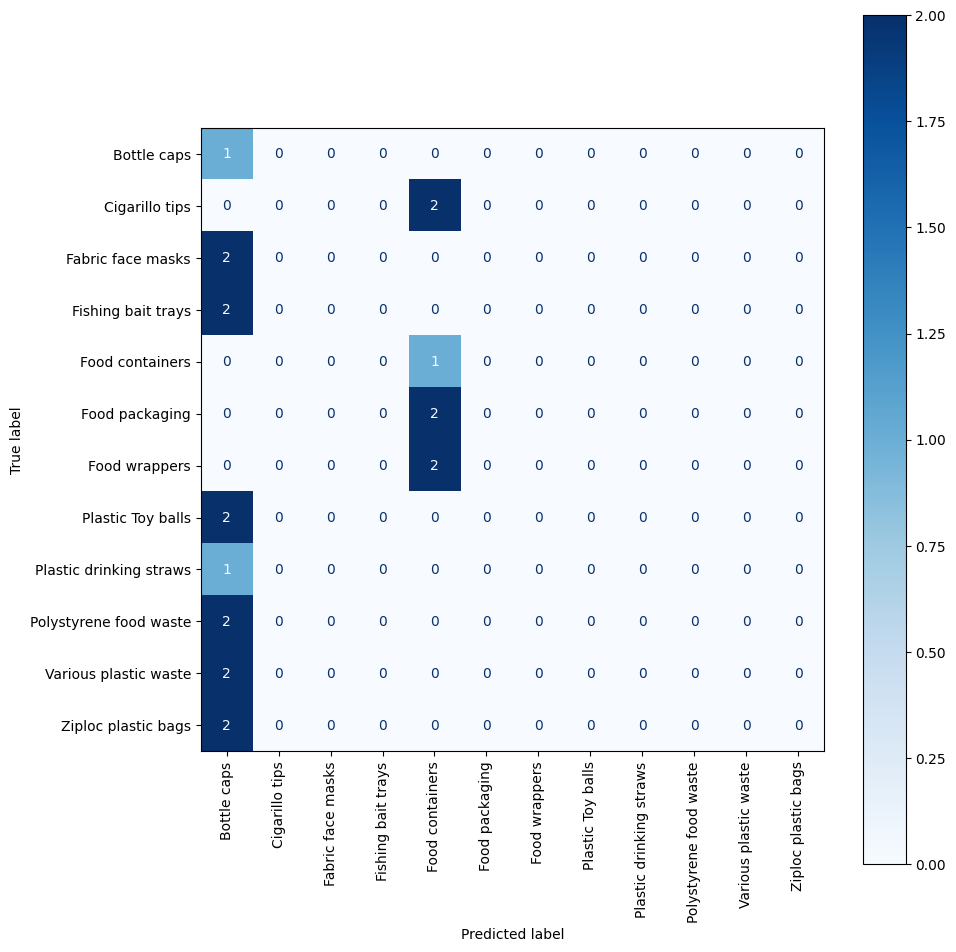

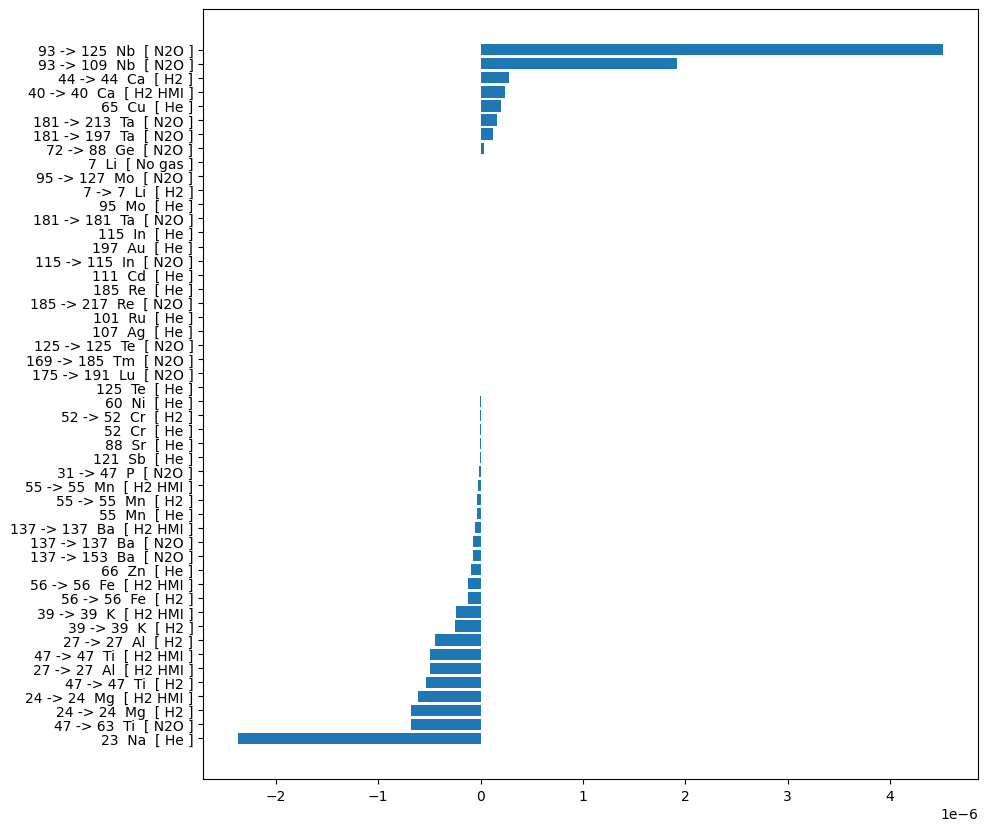

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.16666666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.07      1.00      0.13         1
         Cigarillo tips       0.00      0.00      0.00         2
      Fabric face masks       0.00      0.00      0.00         2
     Fishing bait trays       0.00      0.00      0.00         2
        Food containers       0.14      1.00      0.25         1
         Food packaging       0.00      0.00      0.00         2
          Food wrappers       0.00      0.00      0.00         2
      Plastic Toy balls       0.00      0.00      0.00         2
Plastic drinking straws       0.00      0.00      0.00         1
 Polystyrene food waste       0.00      0.00      0.00         2
  Various plastic waste       0.00      0.00      0.00         2
    Ziploc plastic bags       0.00      0.00      0.00         2

               accuracy                           0.10        21
              macro avg       0.02     

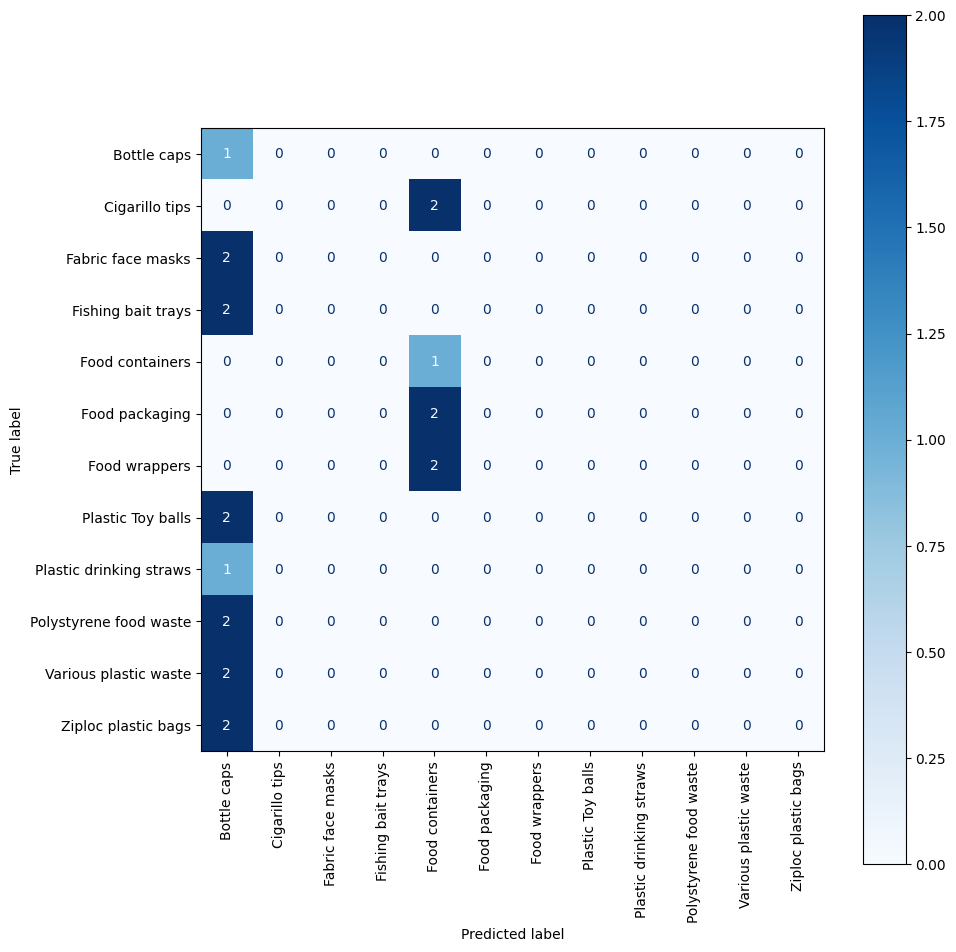

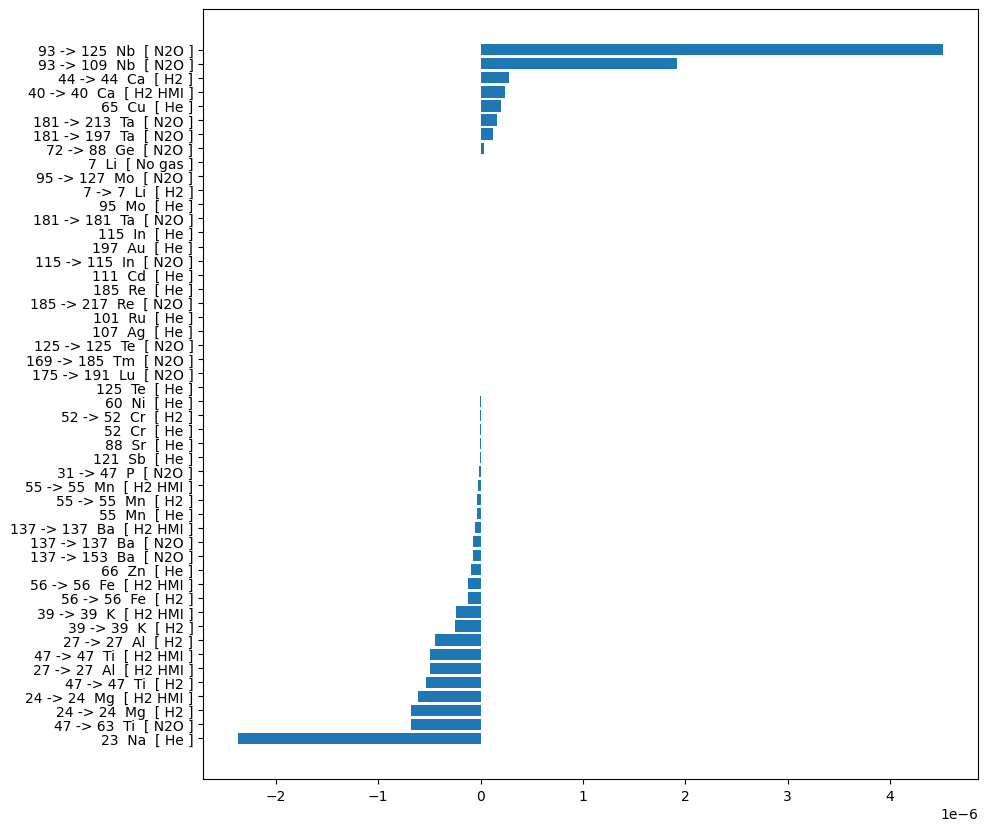

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.16666666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.07      1.00      0.13         1
         Cigarillo tips       0.00      0.00      0.00         2
      Fabric face masks       0.00      0.00      0.00         2
     Fishing bait trays       0.00      0.00      0.00         2
        Food containers       0.14      1.00      0.25         1
         Food packaging       0.00      0.00      0.00         2
          Food wrappers       0.00      0.00      0.00         2
      Plastic Toy balls       0.00      0.00      0.00         2
Plastic drinking straws       0.00      0.00      0.00         1
 Polystyrene food waste       0.00      0.00      0.00         2
  Various plastic waste       0.00      0.00      0.00         2
    Ziploc plastic bags       0.00      0.00      0.00         2

               accuracy                           0.10        21
              macro avg       0.02     

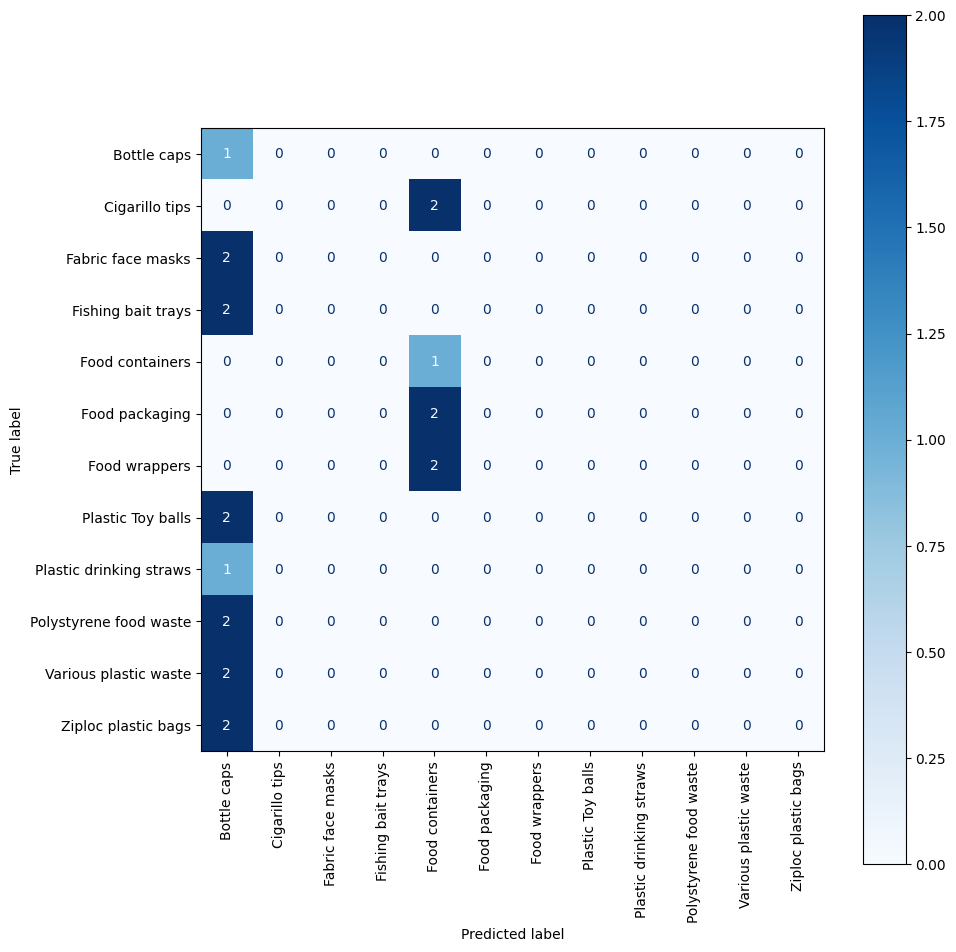

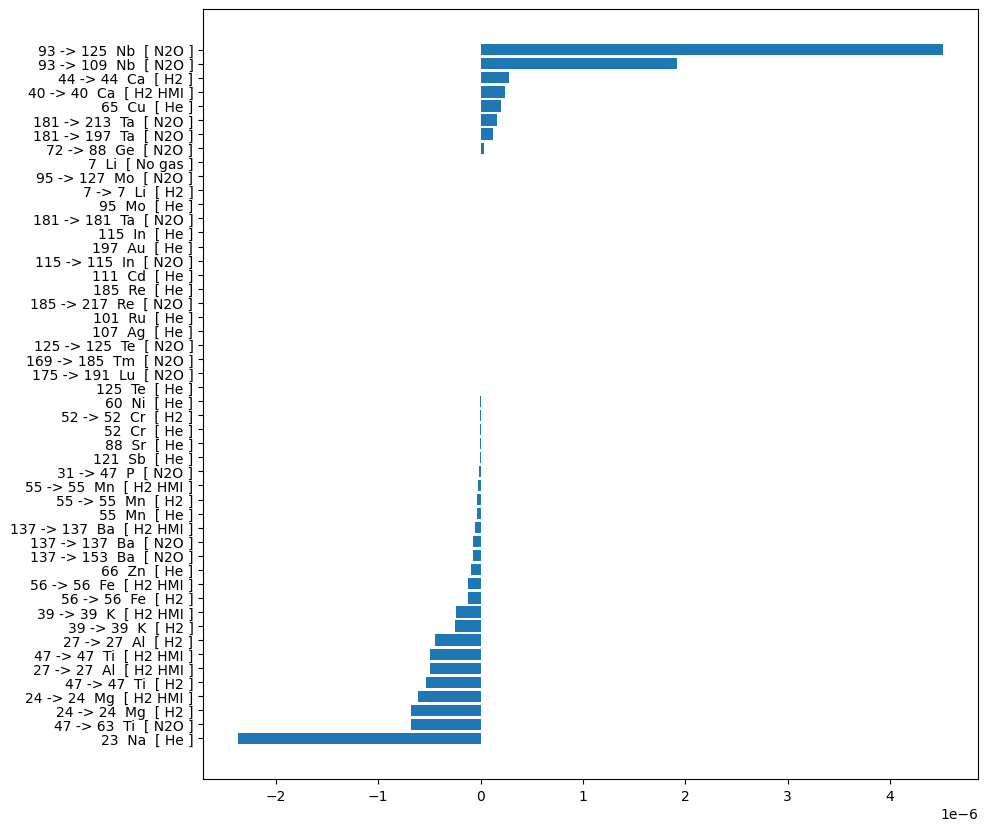

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.16666666666666666
                         precision    recall  f1-score   support

            Bottle caps       0.07      1.00      0.13         1
         Cigarillo tips       0.00      0.00      0.00         2
      Fabric face masks       0.00      0.00      0.00         2
     Fishing bait trays       0.00      0.00      0.00         2
        Food containers       0.14      1.00      0.25         1
         Food packaging       0.00      0.00      0.00         2
          Food wrappers       0.00      0.00      0.00         2
      Plastic Toy balls       0.00      0.00      0.00         2
Plastic drinking straws       0.00      0.00      0.00         1
 Polystyrene food waste       0.00      0.00      0.00         2
  Various plastic waste       0.00      0.00      0.00         2
    Ziploc plastic bags       0.00      0.00      0.00         2

               accuracy                           0.10        21
              macro avg       0.02     

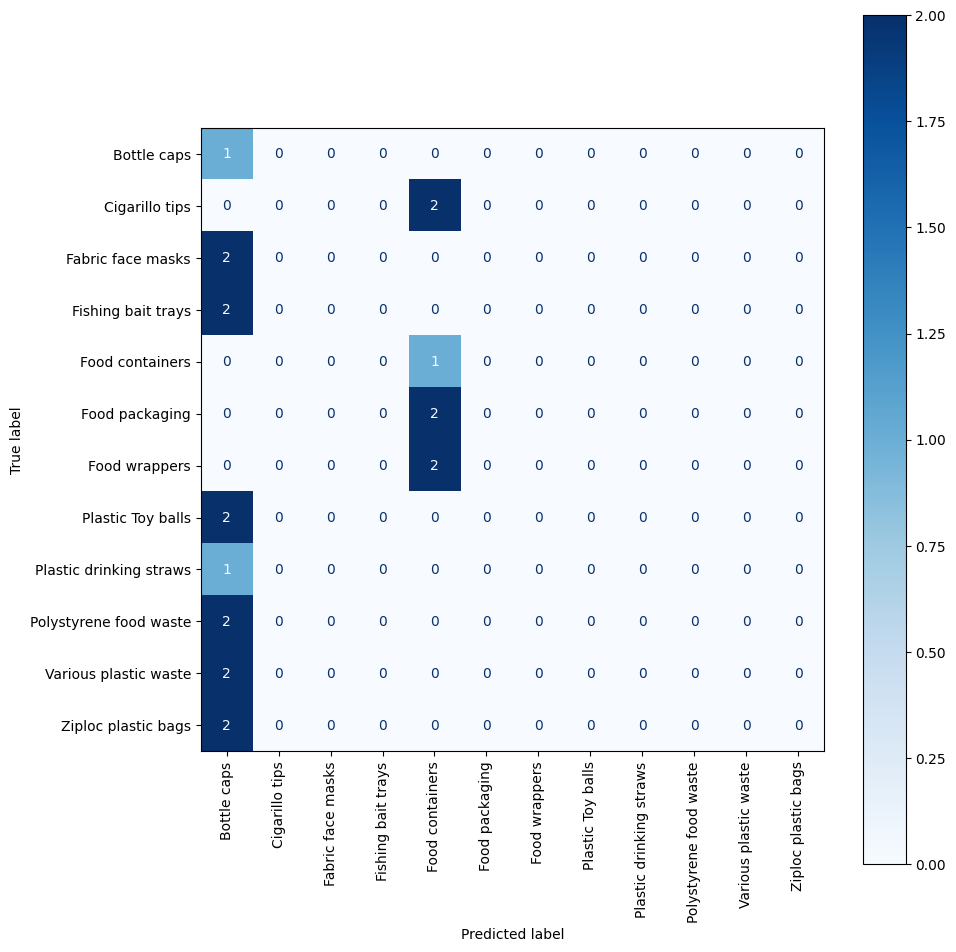

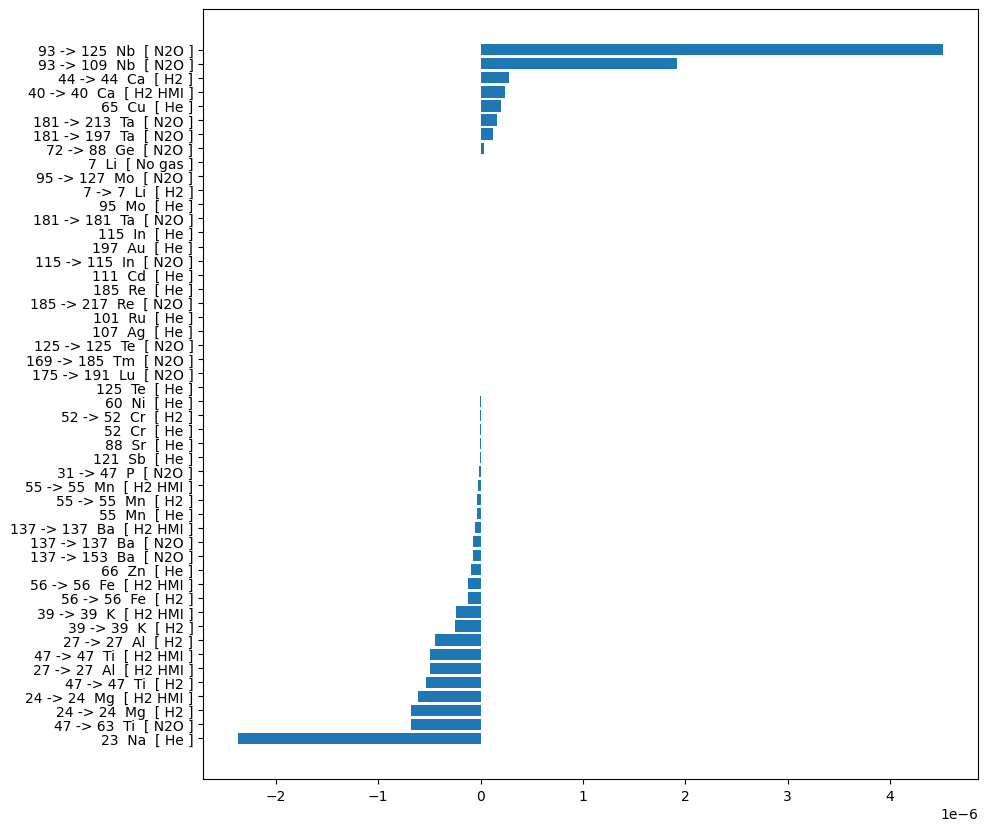

In [ ]:
for i in range(4):
    multinom = caret_multinomlog_result(dat_list = icp_list,
                                           # sig_comp_list = significant_comp,
                                           list_ele = i,
                                           split_train = 0.6)

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.11752136752136752
                         precision    recall  f1-score   support

               Balloons       0.00      0.00      0.00         9
            Bottle caps       0.00      0.00      0.00         9
         Cigarillo tips       0.00      0.00      0.00         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.00      0.00      0.00         7
          Food wrappers       0.00      0.00      0.00         7
      Plastic Toy balls       0.00      0.00      0.00         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.65      0.85      0.73        13
Plastic drinking straws       0.11      0.92      0.20        12
 Polystyrene food waste       0.00      0.00      0.00         7
  Various plastic waste       0.00      

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

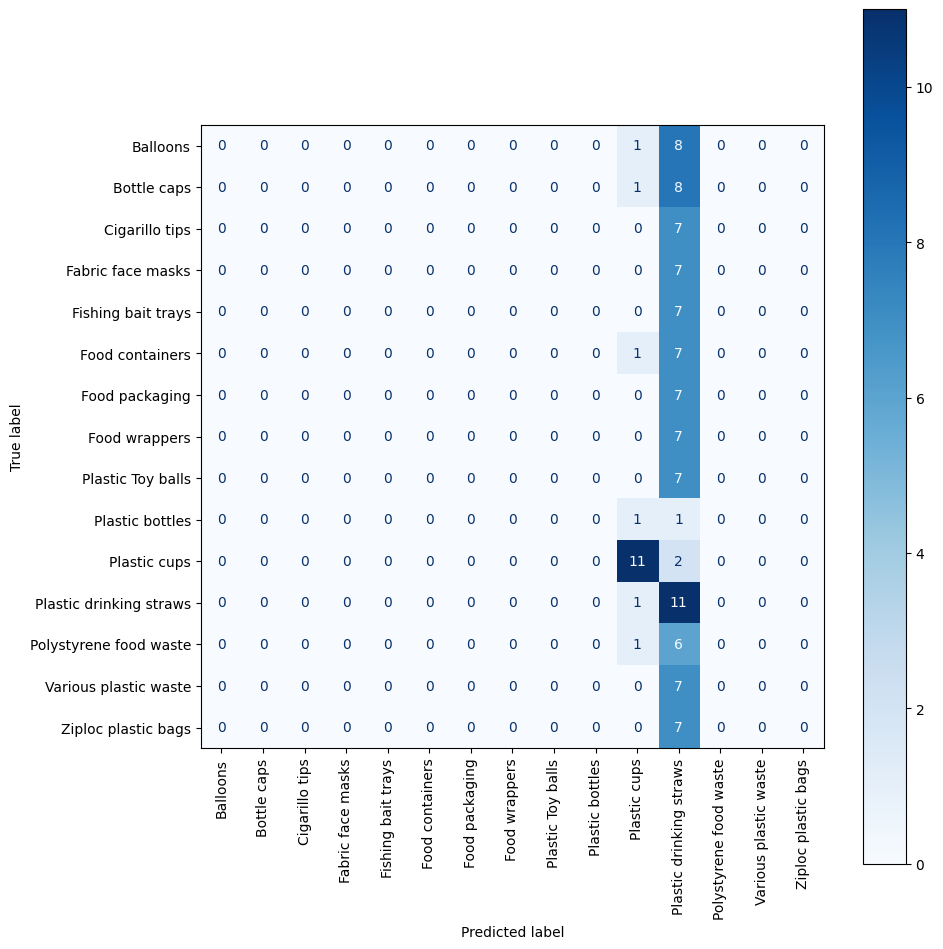

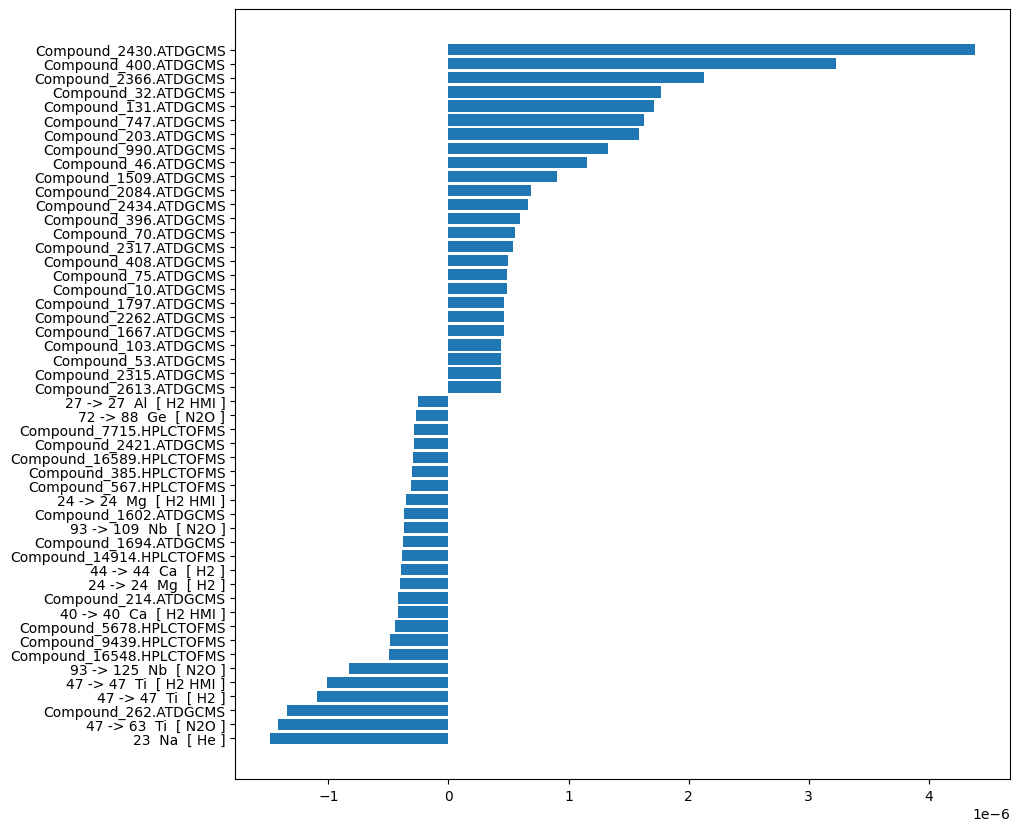

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.11752136752136752
                         precision    recall  f1-score   support

               Balloons       0.00      0.00      0.00         9
            Bottle caps       0.00      0.00      0.00         9
         Cigarillo tips       0.00      0.00      0.00         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.00      0.00      0.00         7
          Food wrappers       0.00      0.00      0.00         7
      Plastic Toy balls       0.00      0.00      0.00         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.65      0.85      0.73        13
Plastic drinking straws       0.11      0.92      0.20        12
 Polystyrene food waste       0.00      0.00      0.00         7
  Various plastic waste       0.00      

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

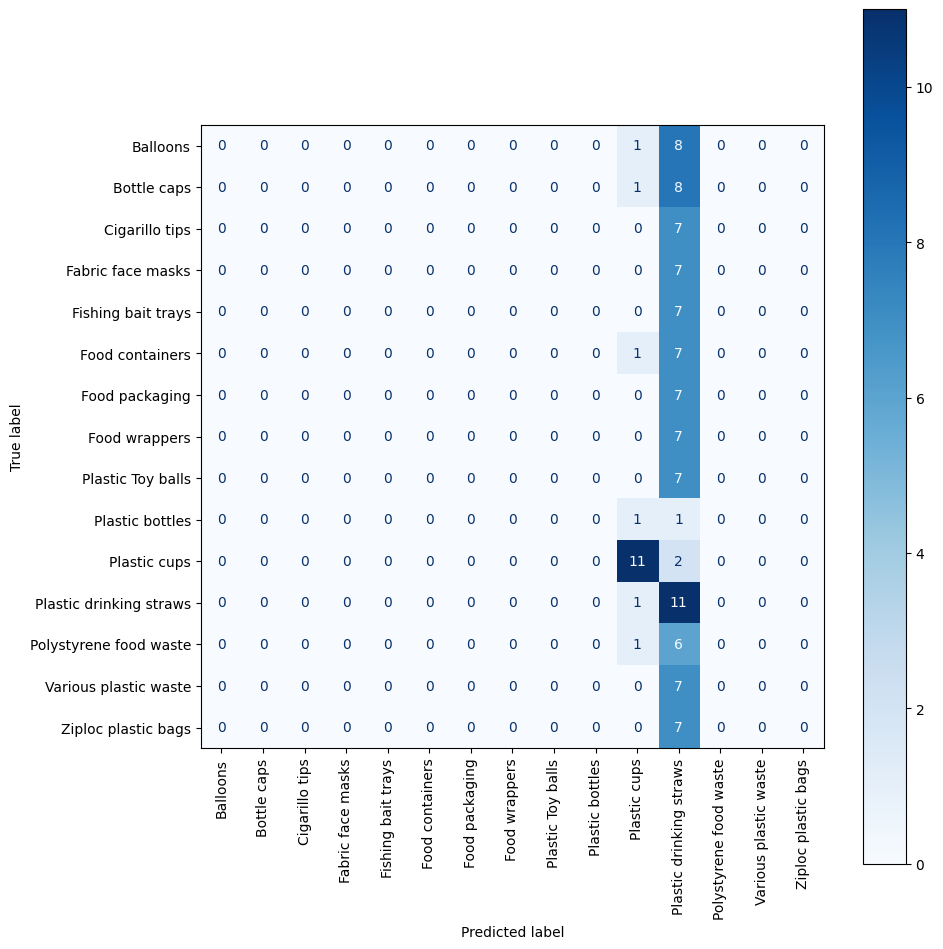

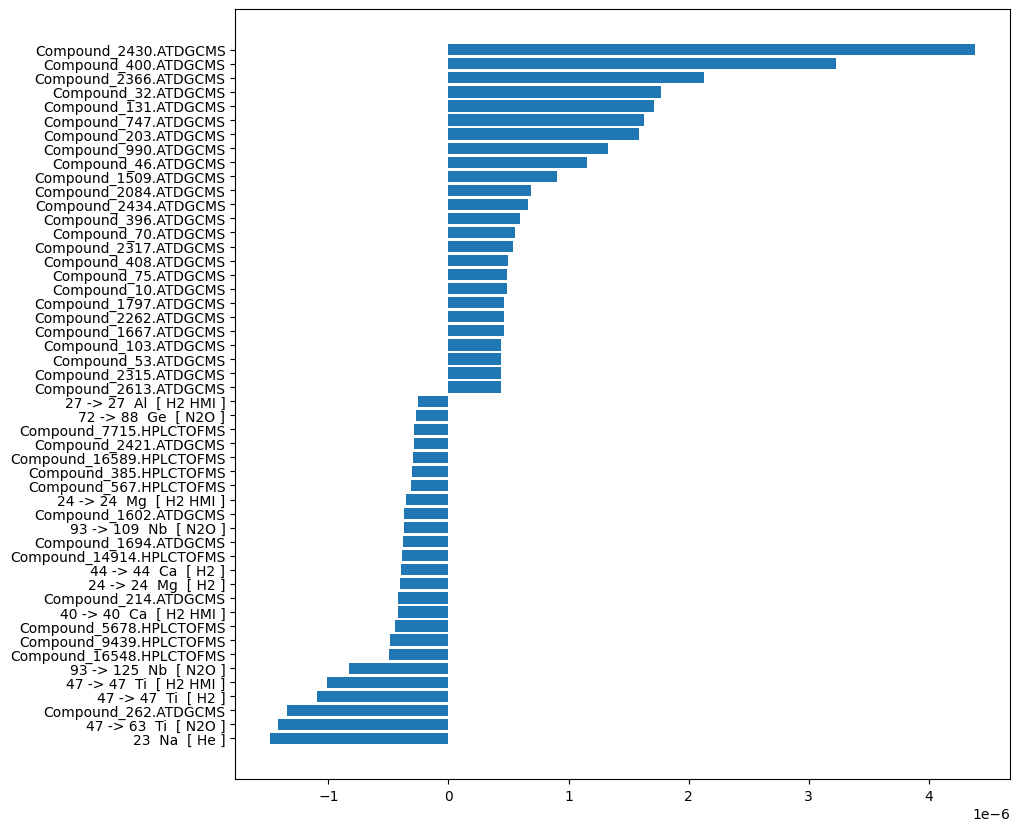

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.11752136752136752
                         precision    recall  f1-score   support

               Balloons       0.00      0.00      0.00         9
            Bottle caps       0.00      0.00      0.00         9
         Cigarillo tips       0.00      0.00      0.00         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.00      0.00      0.00         7
          Food wrappers       0.00      0.00      0.00         7
      Plastic Toy balls       0.00      0.00      0.00         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.65      0.85      0.73        13
Plastic drinking straws       0.11      0.92      0.20        12
 Polystyrene food waste       0.00      0.00      0.00         7
  Various plastic waste       0.00      

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

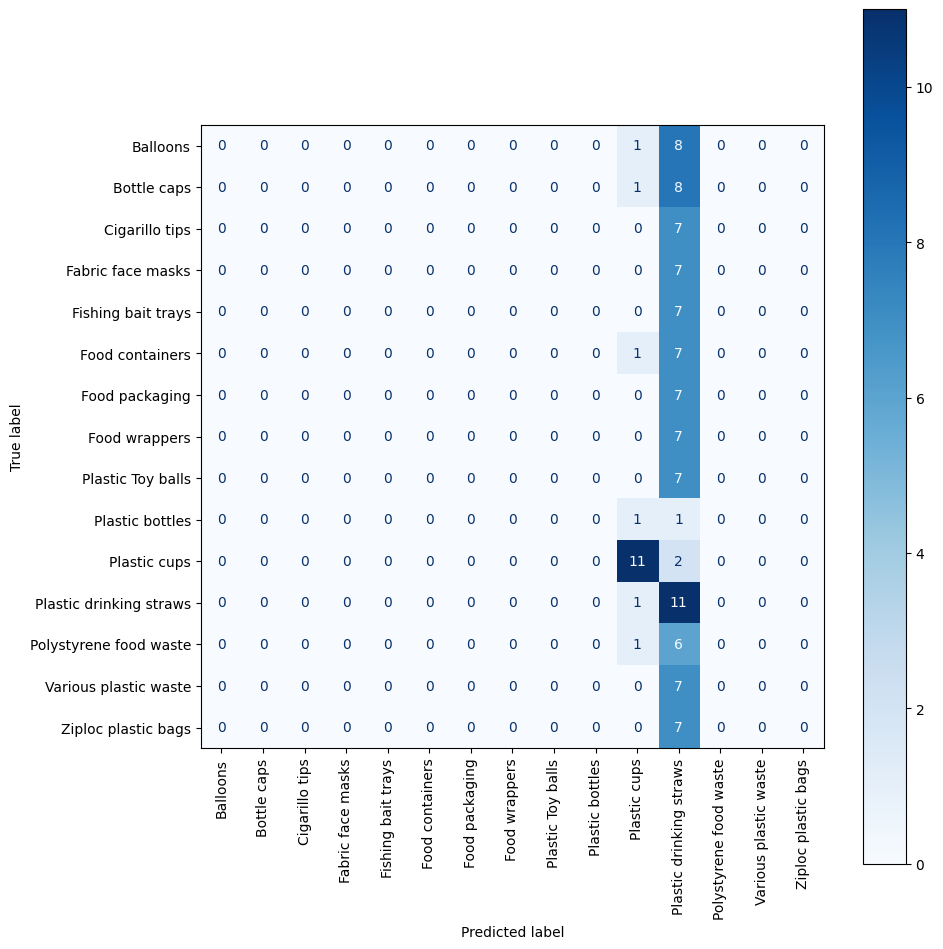

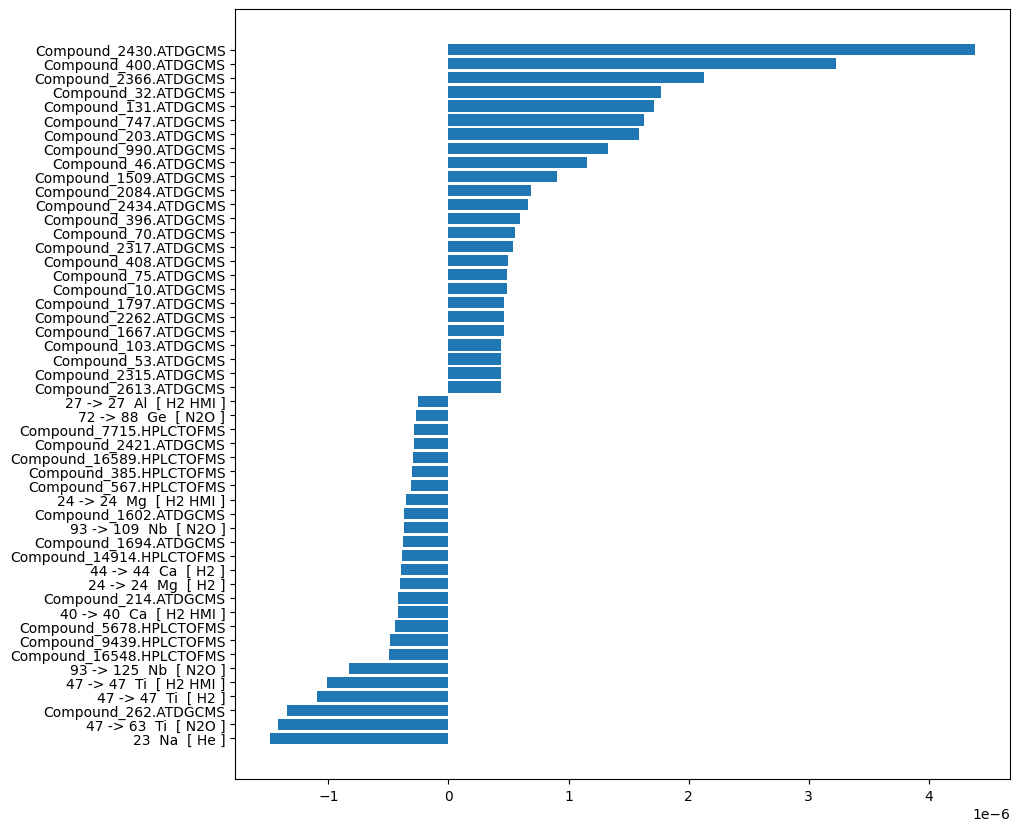

C:\Users\Emerging contaminant\AppData\Local\Temp\ipykernel_12992\1824453053.py:13: FutureWarning: The provided callable <function mean at 0x000001E276229440> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  dat = dat.pivot_table(index=['File', 'Subcategory'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
16 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by

Balanced Accuracy (testing) :0.11752136752136752
                         precision    recall  f1-score   support

               Balloons       0.00      0.00      0.00         9
            Bottle caps       0.00      0.00      0.00         9
         Cigarillo tips       0.00      0.00      0.00         7
      Fabric face masks       0.00      0.00      0.00         7
     Fishing bait trays       0.00      0.00      0.00         7
        Food containers       0.00      0.00      0.00         8
         Food packaging       0.00      0.00      0.00         7
          Food wrappers       0.00      0.00      0.00         7
      Plastic Toy balls       0.00      0.00      0.00         7
        Plastic bottles       0.00      0.00      0.00         2
           Plastic cups       0.65      0.85      0.73        13
Plastic drinking straws       0.11      0.92      0.20        12
 Polystyrene food waste       0.00      0.00      0.00         7
  Various plastic waste       0.00      

C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emerging contaminant\.conda\envs\microplastic\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

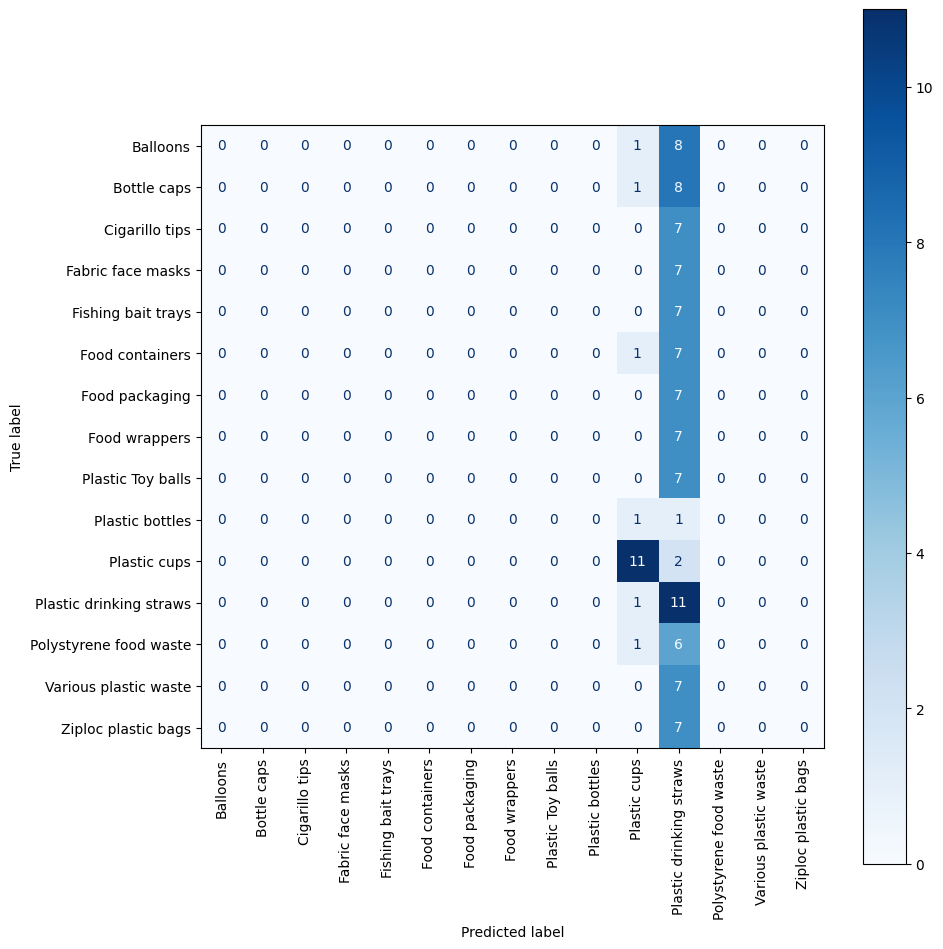

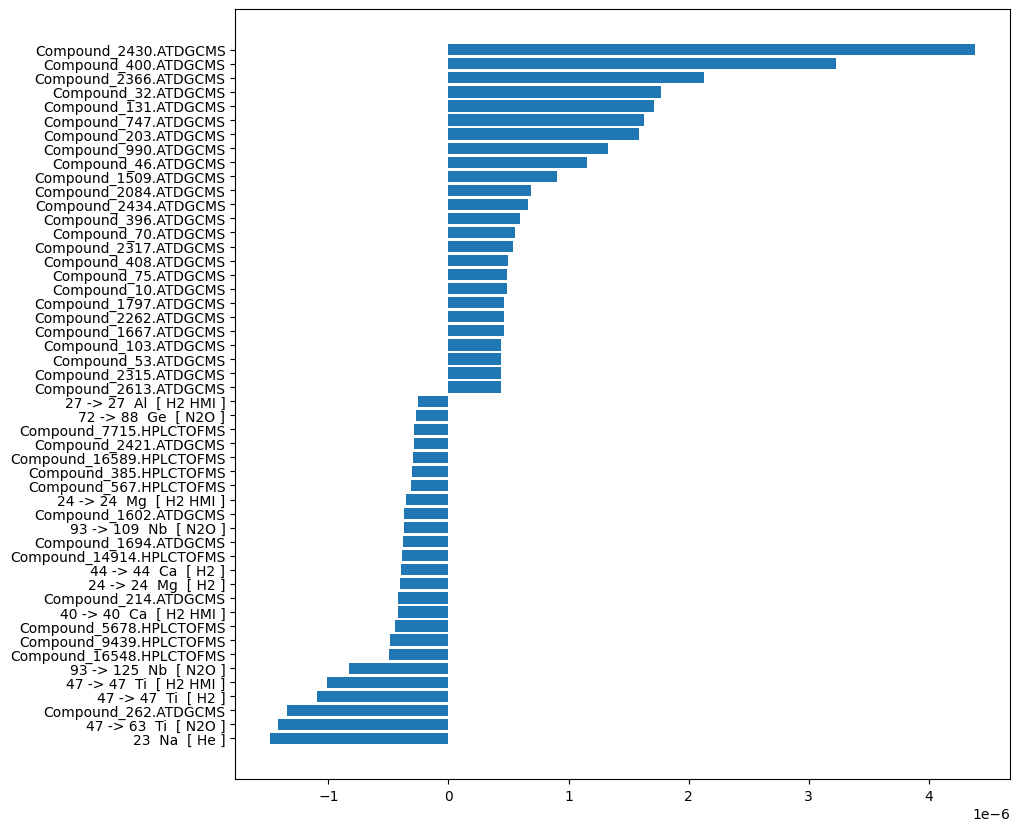

In [ ]:
for i in range(4):
    multinom = caret_multinomlog_result(dat_list = gc_hplc_icp_list,
                                           # sig_comp_list = significant_comp,
                                           list_ele = i,
                                           split_train = 0.6)

### Deep Neural Network <a class="anchor" id="dnn"></a>

The deep neural network (DNN) ensemble used for this work was an ensemble of 10 fully-connected feedforward multilayer perceptron deep neural networks, each with three hidden layers, one input layer, and one output layer.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
def create_model():
    model = Sequential([
        Dense(10, input_shape=(10,), activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def ensemble_predict(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    avg_prediction = tf.reduce_mean(predictions, axis=0)
    return avg_prediction

In [ ]:
dat = gc_hplc_list[0]
# Select relevant columns
dat = dat[['File', 'Category', 'Feature', 'Values']]

# Group by and take the mean of 'Values'
dat = dat.groupby(['File', 'Category', 'Feature']).agg({'Values': 'mean'}).reset_index()

# Pivot the table
dat = dat.pivot_table(index=['File', 'Category'], columns='Feature', values='Values', aggfunc = np.mean).reset_index()

# Set 'File' as index (equivalent to rownames in R)
dat.set_index('File', inplace=True)

# Keep only significant comp from Wilcoxon test
# sig_comp = sig_comp_list[list_ele]['comp'].unique()
# df = gc_hplc[np.append(sig_comp, 'Category')]

# Iterate through each row and replace NaNs
for idx, row in dat.iterrows():
    na_indices = row.isna()
    na_count = na_indices.sum()

    if na_count > 0:
        dat.loc[idx, na_indices.index[na_indices]] = 0

# If a class only have 1 member then exclude that class from the ML
# Count the frequency of each class
class_counts = dat['Category'].astype(str).value_counts()
# Filter out classes with only one member
dat = dat[dat['Category'].astype(str).map(class_counts) > 1]

# Extract the features and labels
X = dat.drop(columns=['Category'])
y = dat['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= split_train, stratify = y,
                                                    random_state= 123
                                                   )

In [ ]:
ensemble_models = [compile_model(create_model()) for _ in range(10)]
for model in ensemble_models:
    model.fit(X_train, Y_train, epochs=10, batch_size=32)

ensemble_accuracy = ensemble_predict(ensemble_models, X_test)